# ENCUESTA DE CURSADA
## Segundo Cuatrimestre de 2022
### Departamento de Computación FIUBA

Se recomienda ejecutar este notebook con [jupyterlab](https://jupyterlab.readthedocs.io/en/stable/).

Código disponible en [github.com/CrossNox/FIUBA-encuesta-depto-computacion](https://github.com/CrossNox/FIUBA-encuesta-depto-computacion).

In [1]:
import sys
from textwrap import wrap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

sns.set(style="darkgrid")

pd.options.display.max_colwidth = None
pd.set_option("display.max_rows", None)

In [2]:
comp = pd.read_csv("../datasets/2022c2/Encuesta 2C 2022 (Respuestas) - Respuestas de formulario 1.csv")

# Análisis de respuestas

## Total de Encuestas Procesadas

In [3]:
comp.pipe(len)

281

Dato anecdótico: es la encuesta que menos respuestas ha tenido (al menos desde el 1C2020)

## Hay duplicados?

In [4]:
comp.duplicated().any()

False

## Encoding de preguntas de opción múltiple

In [5]:
map_opinion = {"Excelente": 5, "Muy Bueno": 4, "Bueno": 3, "Regular": 2, "Malo": 1}
map_sino = {"Sí": 5, "No": 0}
map_temas = {
    "Muy Interesantes": 5,
    "Interesantes": 4,
    "Poco Interesantes": 2,
    "Nada Interesantes": 1,
}
map_clases_teoricas = {
    "Excelentes": 5,
    "Muy Buenas": 4,
    "Buenas": 3,
    "Regulares": 2,
    "Malas": 1,
    "No hay clases teóricas": np.nan,
    "No hay clase teóricas": np.nan,
}
map_clases_practicas = {
    "Excelentes": 5,
    "Muy Buenas": 4,
    "Buenas": 3,
    "Regulares": 2,
    "Malas": 1,
    "No Hay Clases Prácticas": np.NaN,
}
map_dificultad_curso = {
    "Muy Facil": 5,
    "Muy Fácil": 5,
    "Facil": 4,
    "Fácil": 4,
    "Normal": 3,
    "Dificil": 2,
    "Difícil": 2,
    "Muy Dificil": 1,
    "Muy Difícil": 1,
}
map_dificultad_tp = {
    "Muy dificil": 1,
    "Muy difícil": 1,
    "Dificil": 2,
    "Difícil": 2,
    "Normal": 3,
    "Fácil": 4,
    "Facil": 4,
    "Muy Fácil": 5,
    "Muy fácil": 5,
    "Muy Facil": 5,
    "No hay TP": np.NaN,
}

comp.replace(
    {
        "Opinión general sobre el curso": map_opinion,
        "¿Aprobó la cursada?": map_sino,
        "¿Cómo te resultaron los temas de la materia?": map_temas,
        "¿Los temas de la materia están actualizados?": map_sino,
        "Nivel de las clases teóricas del curso": map_clases_teoricas,
        "Nivel de las clases prácticas del curso": map_clases_practicas,
        "Dificultad del curso": map_dificultad_curso,
        "Dificultad del TP": map_dificultad_tp,
    },
    inplace=True,
)

cols_sino = ["¿Aprobó la Cursada?", "¿Los Temas de la Materia Están Actualizados?"]

# comp['¿Aprobó la Cursada?'] = comp['¿Aprobó la Cursada?'].astype('category')
# comp['¿Los Temas de la Materia Están Actualizados?'] = comp['¿Los Temas de la Materia Están Actualizados?'].astype('category')

In [6]:
comp["Promedio nivel teóricas y prácticas"] = (
    comp["Nivel de las clases teóricas del curso"]
    + comp["Nivel de las clases prácticas del curso"]
) / 2

## Opinión general del curso

In [7]:
def reverse_map(m):
    return {v: k for k, v in m.items()}

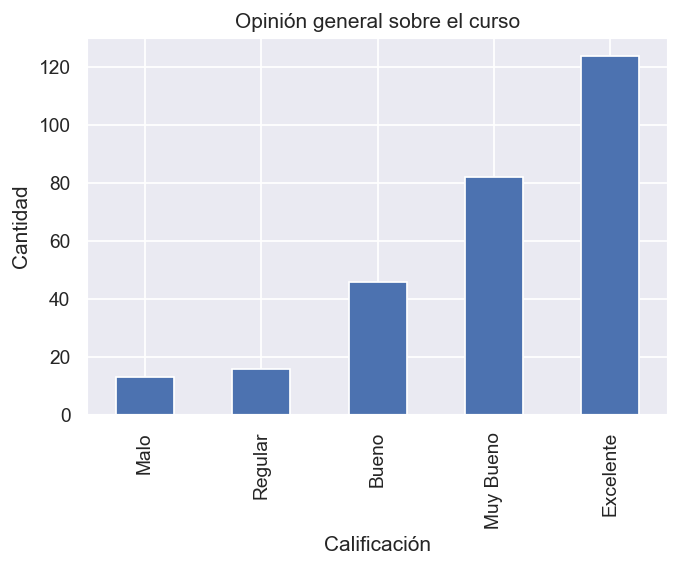

In [8]:
plt.figure(dpi=125)
plt.title("Opinión general sobre el curso")
ax = comp["Opinión general sobre el curso"].value_counts().sort_index().plot(kind="bar")
ax.set_xticklabels(
    [reverse_map(map_opinion)[int(x.get_text())] for x in ax.get_xticklabels()]
)
plt.xlabel("Calificación")
plt.ylabel("Cantidad")
plt.show()

## Cantidad de Encuestados por Curso
Cantidad de encuestas completadas por cada Curso.

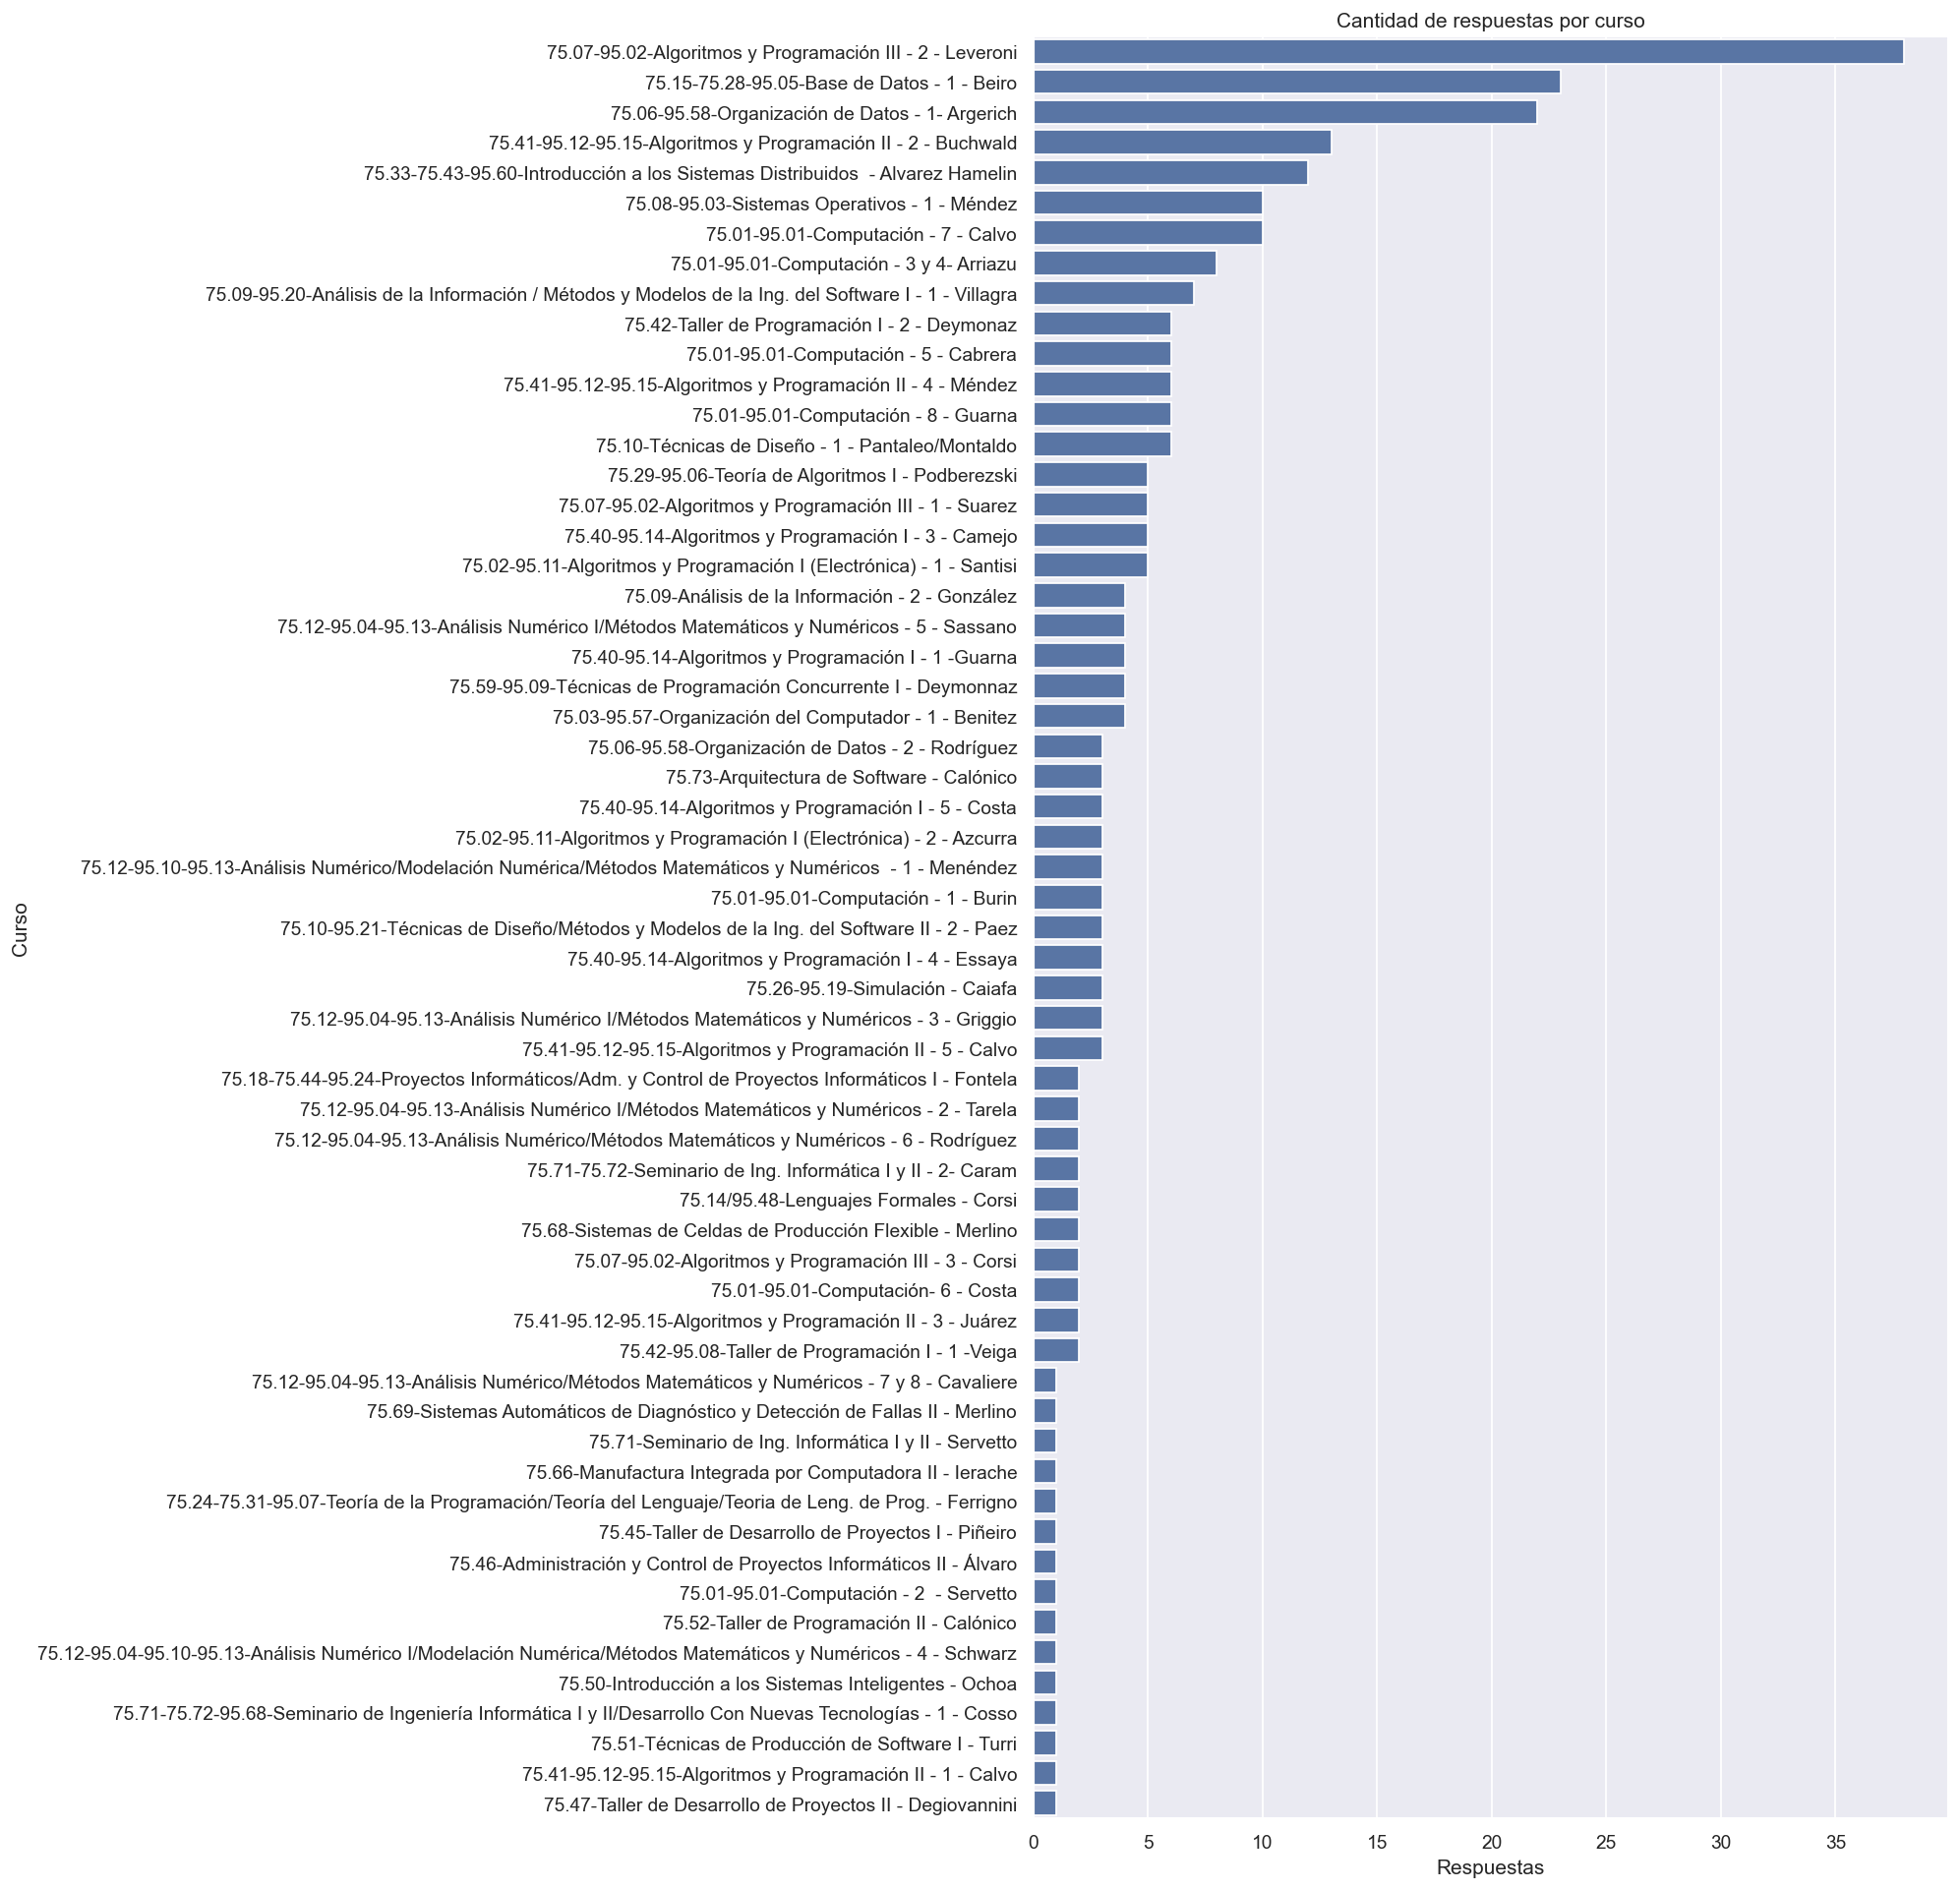

In [9]:
plt.figure(dpi=125, figsize=(6.4 * 1.5, 4.8 * 4))

data = comp["Elige el curso"].value_counts().sort_values(ascending=False)
ax = sns.barplot(x=data.values, y=data.index, color="b")

plt.title("Cantidad de respuestas por curso")
plt.xlabel("Respuestas")
plt.ylabel("Curso")

plt.show()

## Varianza de la Opinión por Curso
Este gráfico muestra la variabilidad de la pregunta "Opinión General Sobre el Curso", a menor valor mas consistentes los resultados de la encuesta. Los valores mayores muestran disparidad de resultados en cuanto a la opinión general sobre el curso.

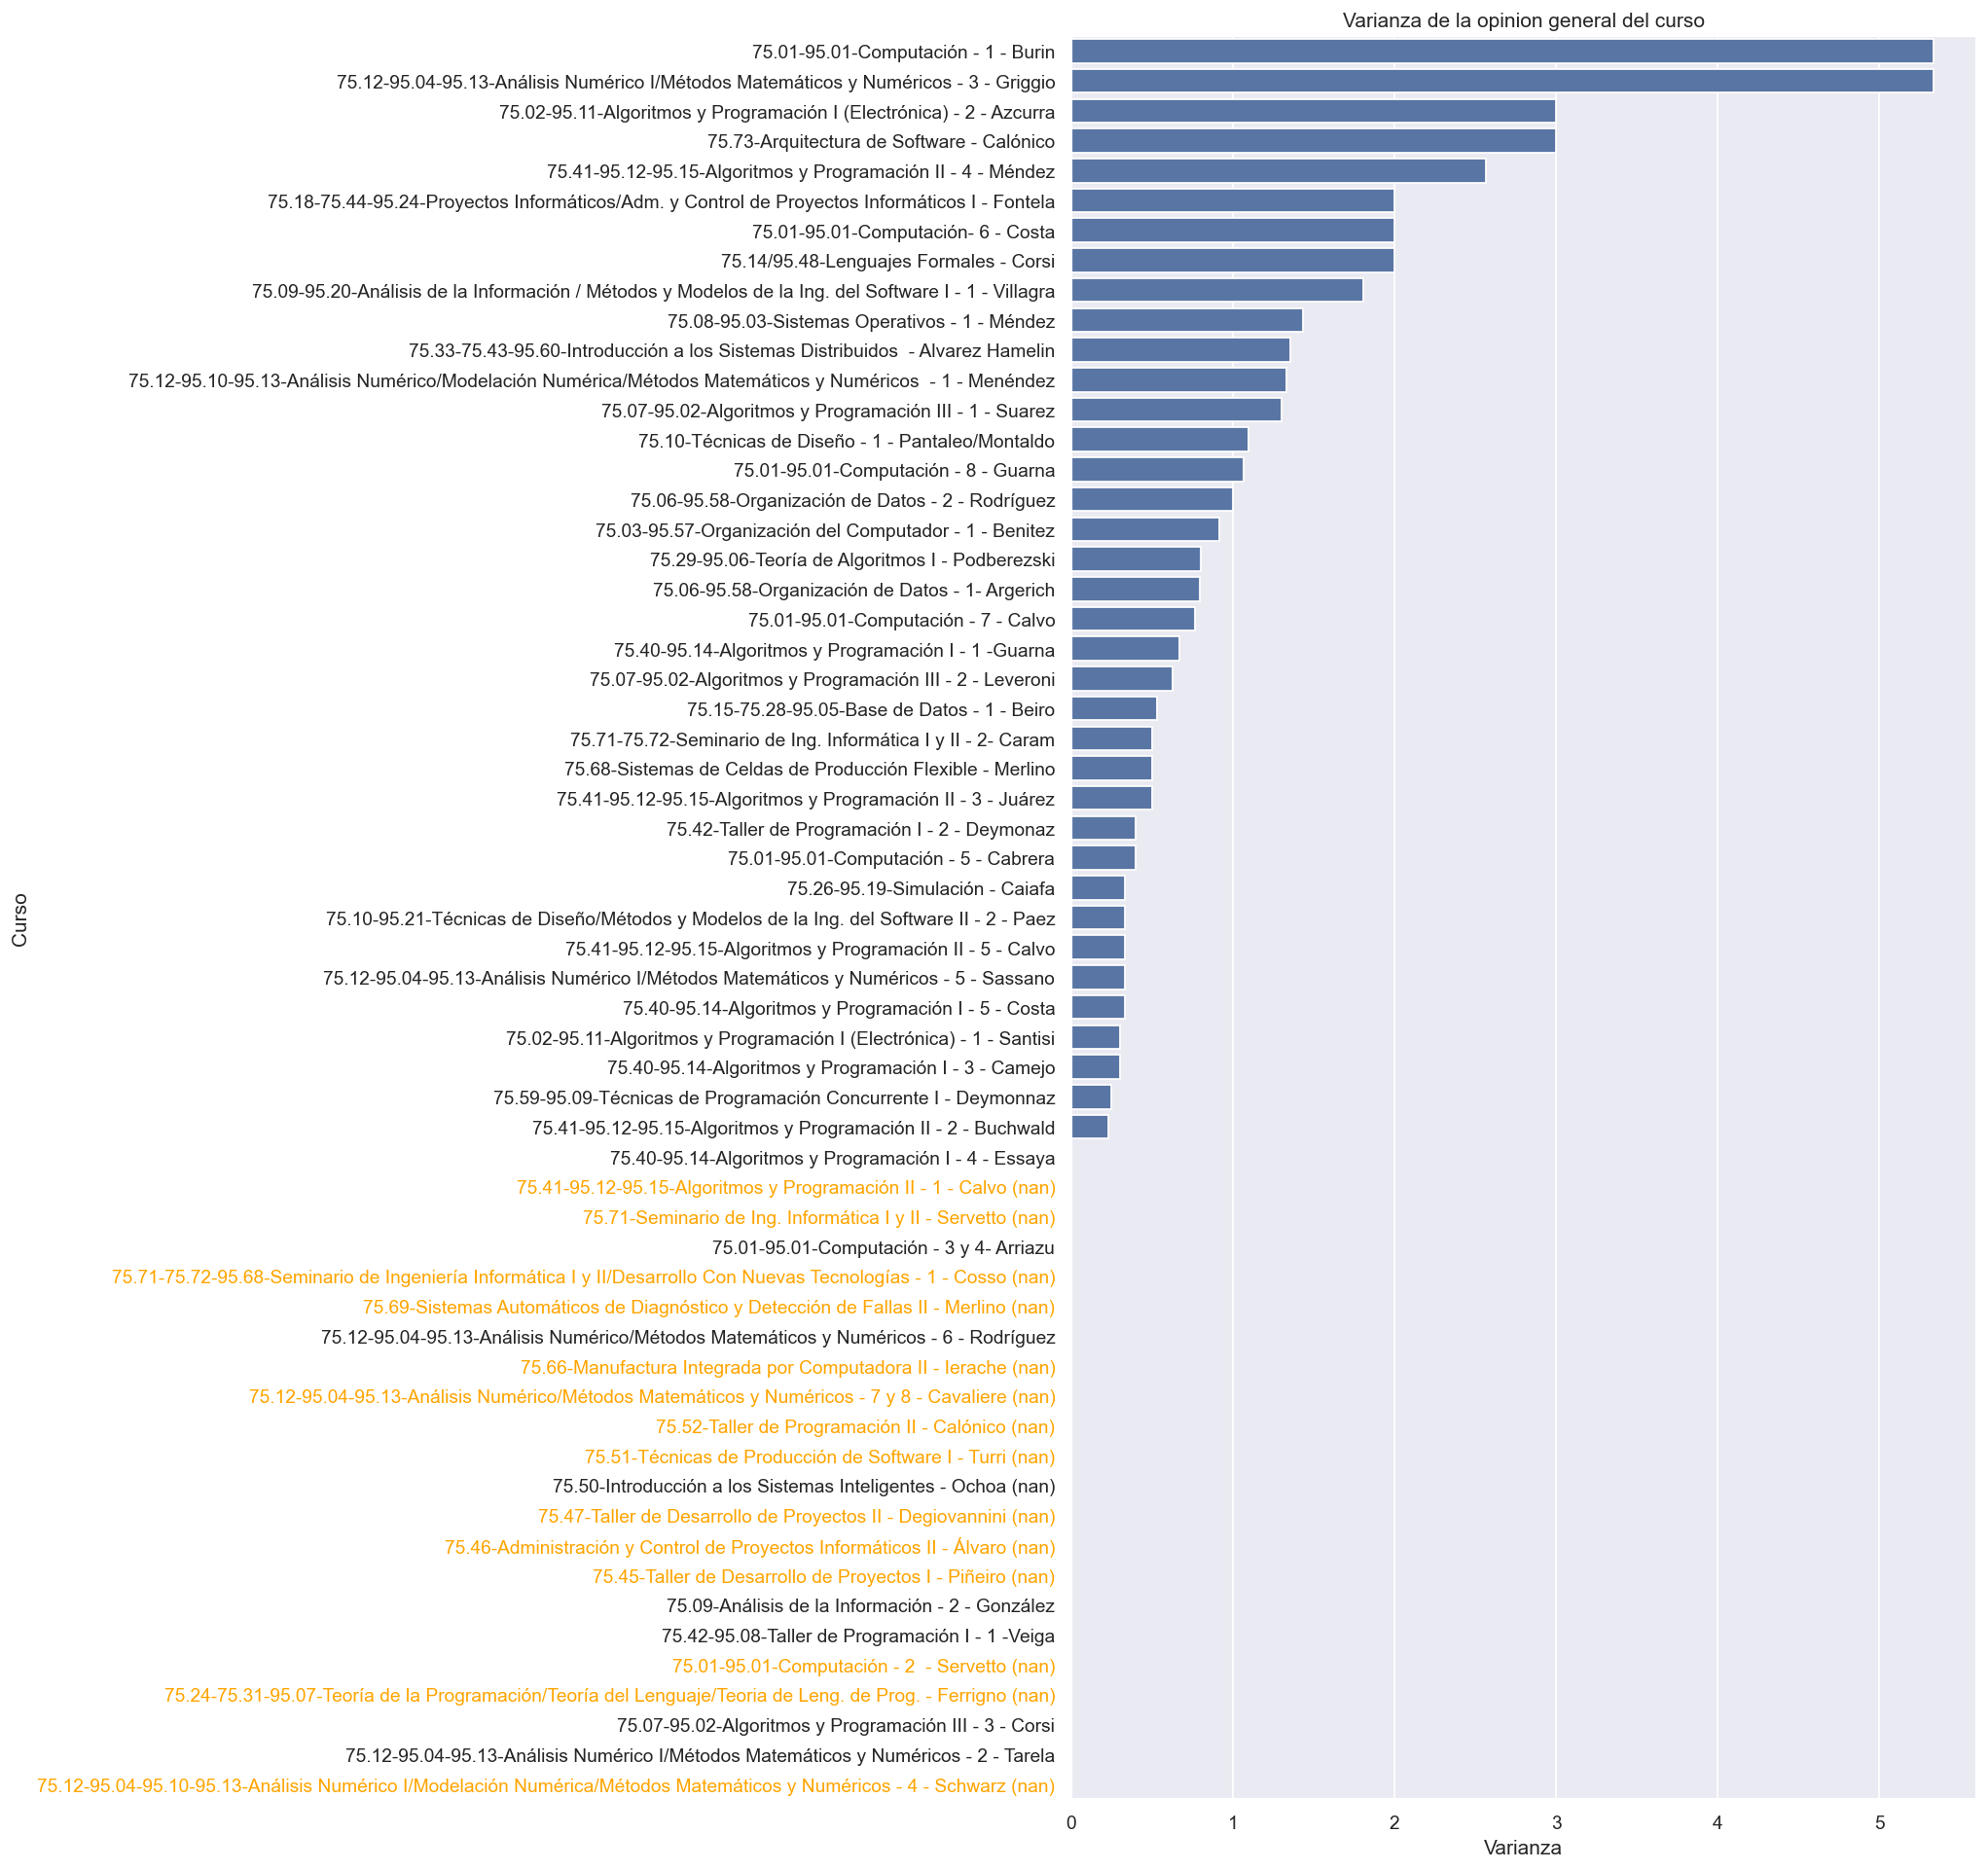

In [10]:
plt.figure(dpi=125, figsize=(6.4 * 1.5, 4.8 * 4))

var_curso = comp.groupby("Elige el curso")["Opinión general sobre el curso"].var()
nan_var = var_curso[var_curso.isna()].index.tolist()

data = var_curso.fillna(0).sort_values(ascending=False)

ax = sns.barplot(x=data.values, y=data.index, color="b")

ax.set_yticklabels(
    [
        x if x.get_text() not in nan_var else f"{x.get_text()} (nan)"
        for x in ax.get_yticklabels()
    ]
)

for yticklabel in ax.get_yticklabels():
    if yticklabel.get_text().rstrip(" (na)") in nan_var:
        yticklabel.set_color("orange")

plt.title("Varianza de la opinion general del curso")
plt.xlabel("Varianza")
plt.ylabel("Curso")

plt.show()

## Comparativa de promedios por pregunta
Esta matriz muestra el promedio de calificaciones para cada pregunta de la encuesta para los cursos que tienen 5 o mas encuestas. Orden alfabético por curso.

In [11]:
num_cols = [
    "Opinión general sobre el curso",
    "¿Aprobó la cursada?",
    "¿Cómo te resultaron los temas de la materia?",
    "¿Los temas de la materia están actualizados?",
    "Nivel de las clases teóricas del curso",
    "Nivel de las clases prácticas del curso",
    "Dificultad del curso",
    "Dificultad del TP",
    "Promedio nivel teóricas y prácticas",
]

In [12]:
cursos_5p_respuestas = (
    comp["Elige el curso"]
    .value_counts()
    .where(lambda x: x >= 5)
    .dropna()
    .index.tolist()
)
comp_5p = comp[comp["Elige el curso"].isin(cursos_5p_respuestas)].sort_values(
    by="Elige el curso"
)
comp_5p_mean = comp_5p.groupby("Elige el curso")[num_cols].mean().sort_index()

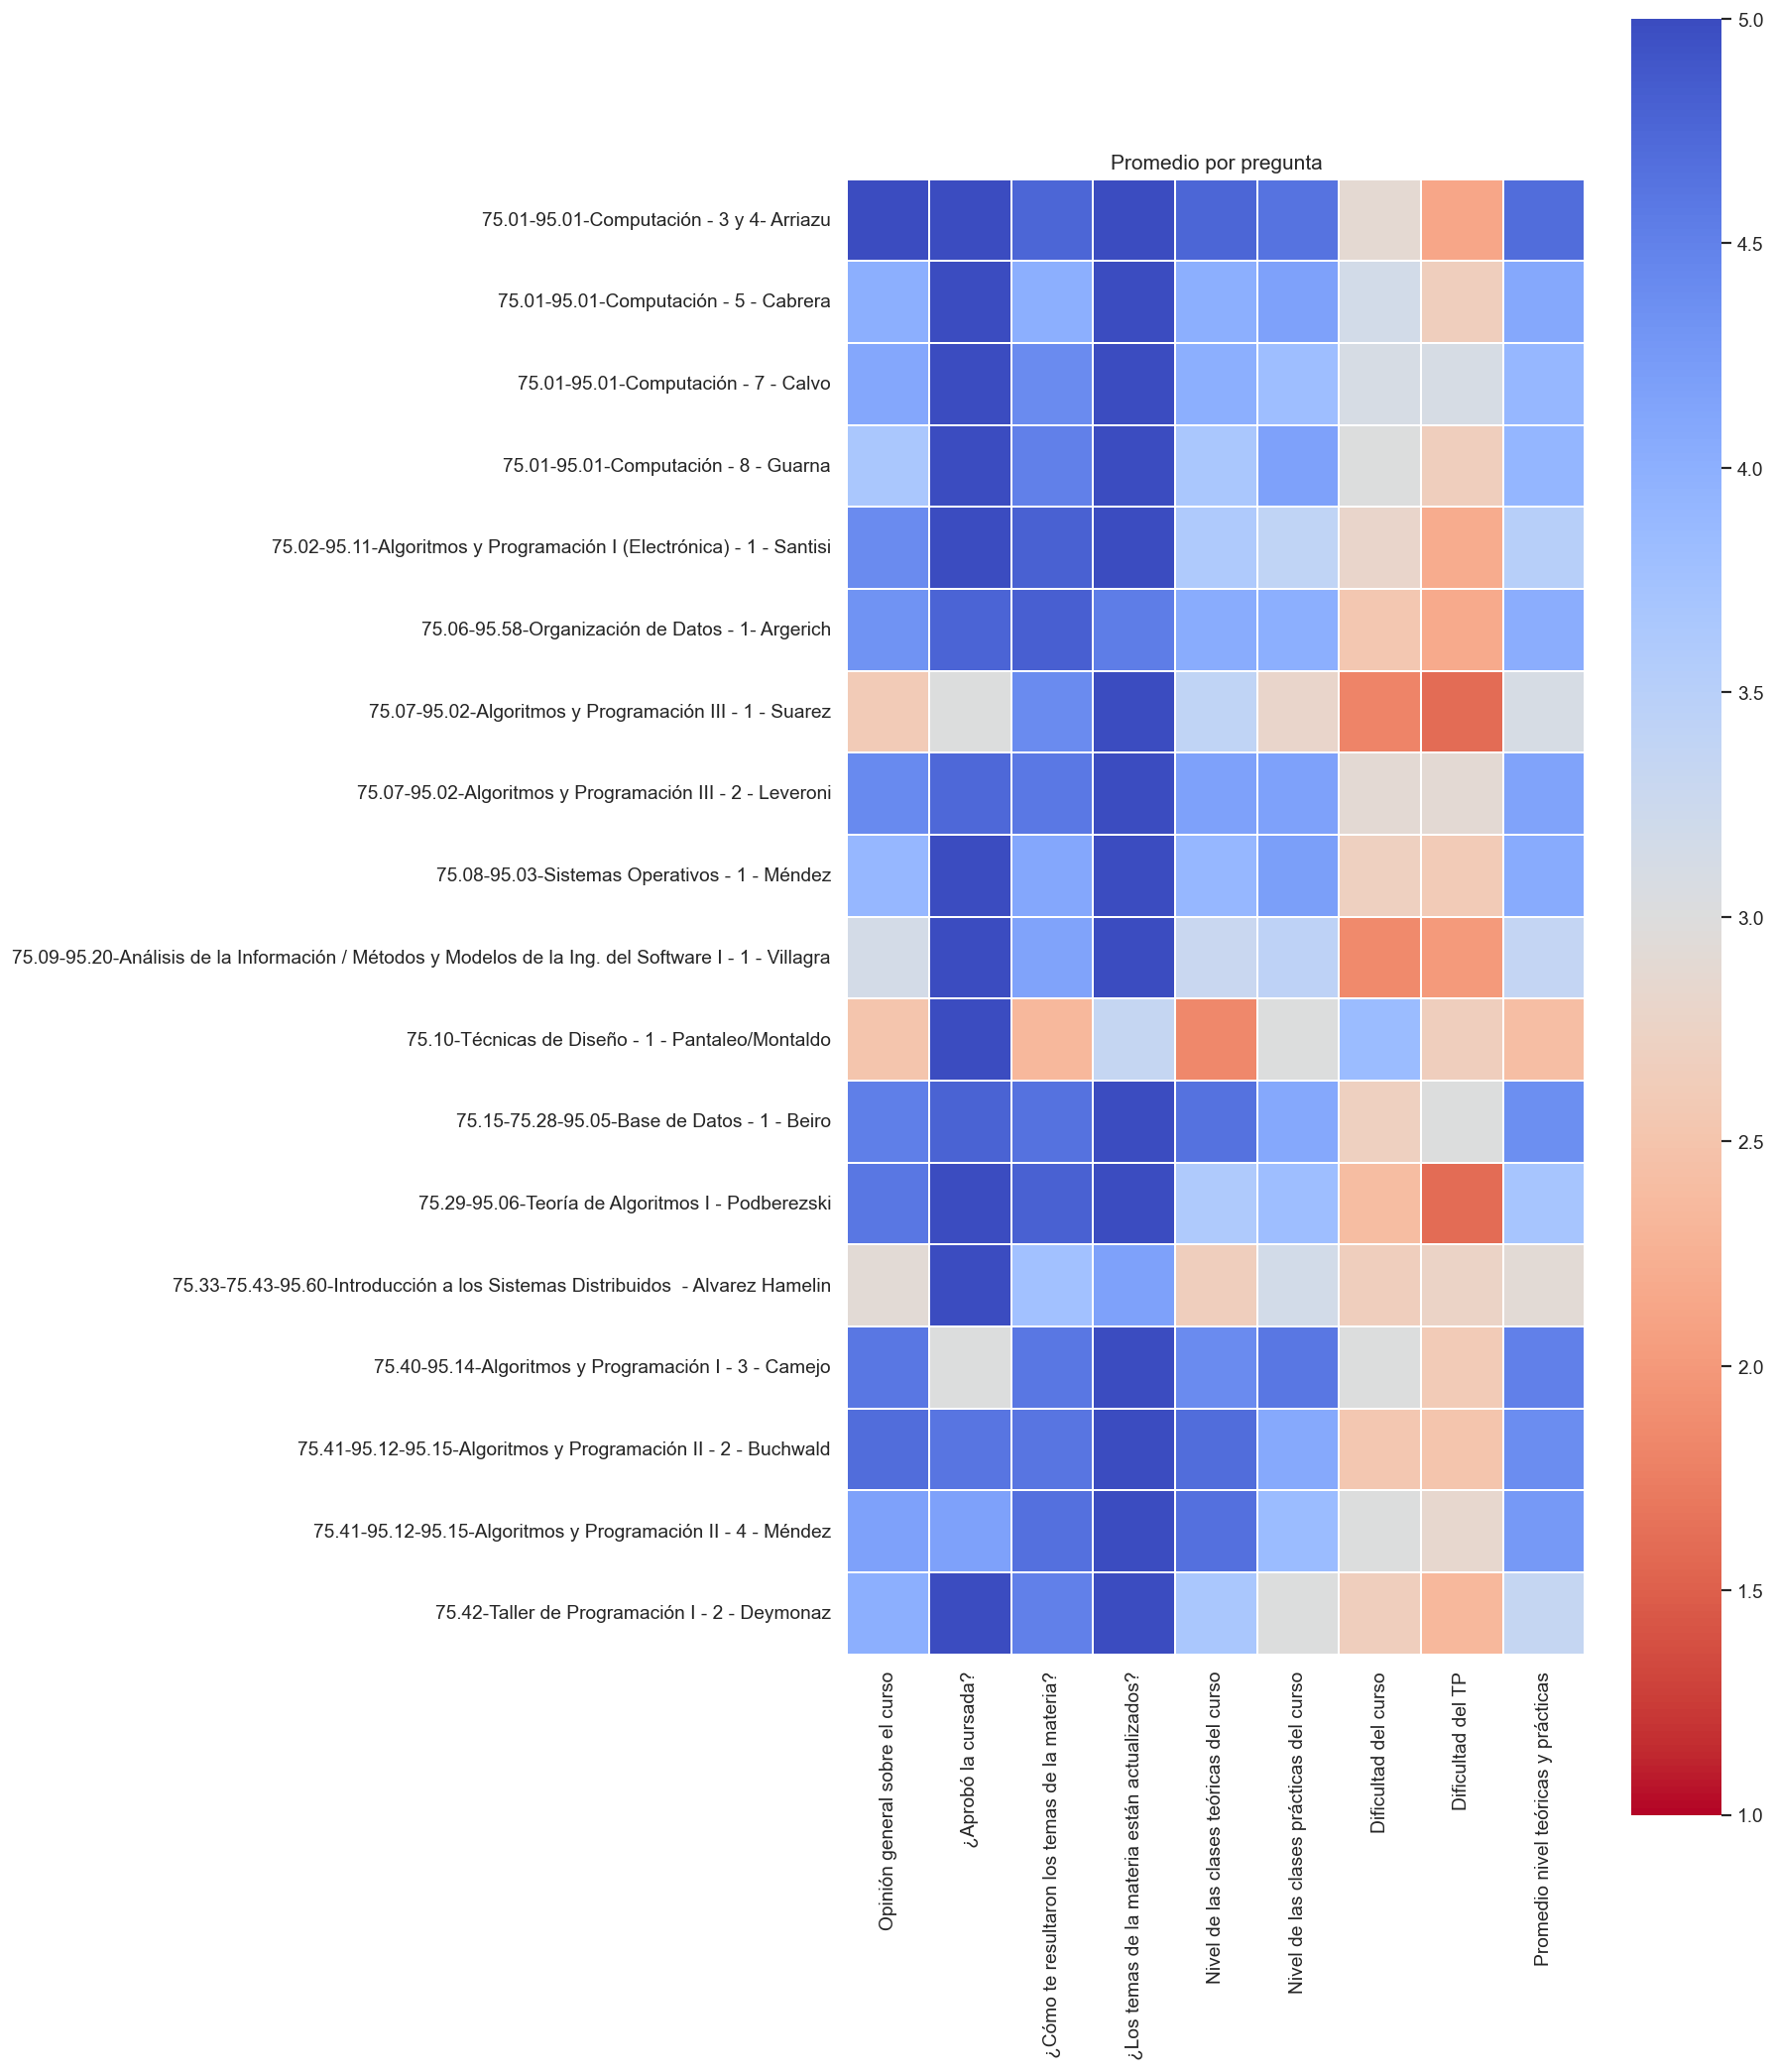

In [13]:
plt.figure(dpi=125, figsize=(6.4 * 1.5, 4.8 * 4))

sns.heatmap(
    data=comp_5p_mean, cmap="coolwarm_r", linewidths=0.2, square=True, vmin=1, vmax=5
)
plt.ylabel("")
plt.title("Promedio por pregunta")
plt.show()

## Histograma de promedios por pregunta
Por cada curso se calcula el promedio de cada pregunta numérica y luego se hace un histograma de esos promedios.

### Histograma de promedios de Opinión general sobre el curso

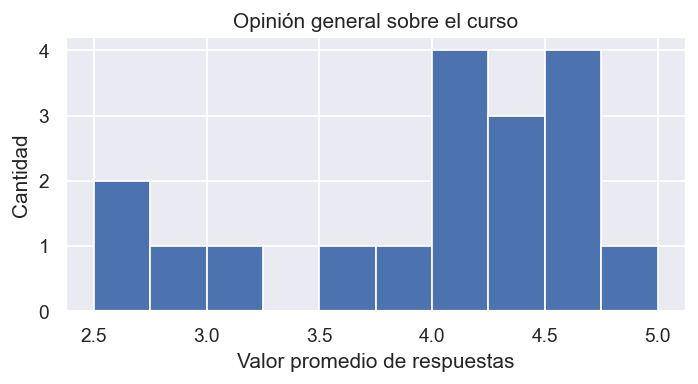

### Histograma de promedios de ¿Aprobó la cursada?

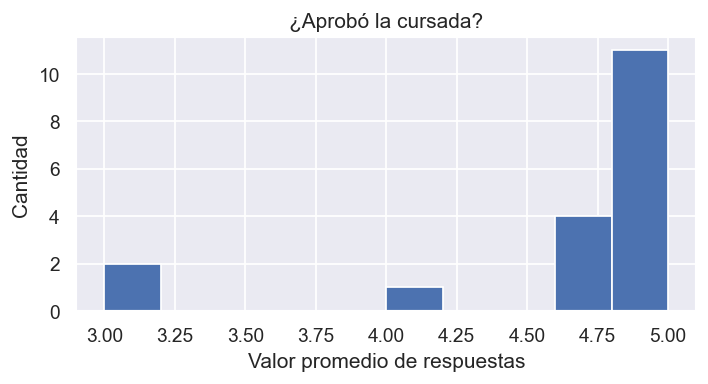

### Histograma de promedios de ¿Cómo te resultaron los temas de la materia?

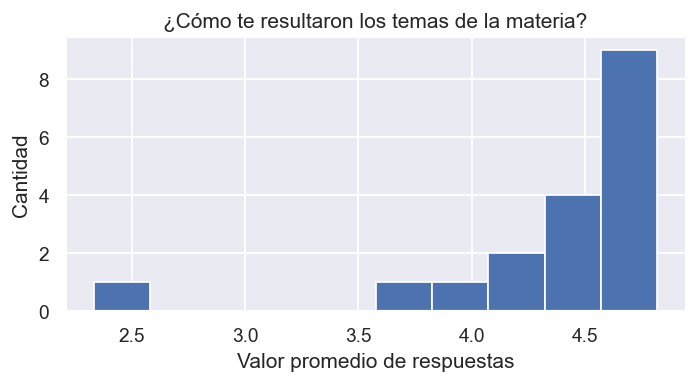

### Histograma de promedios de ¿Los temas de la materia están actualizados?

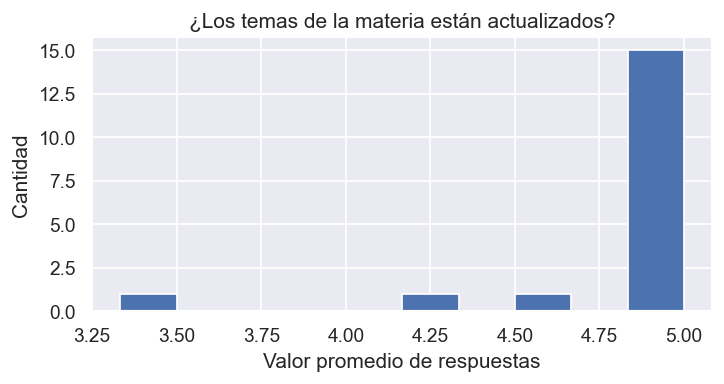

### Histograma de promedios de Nivel de las clases teóricas del curso

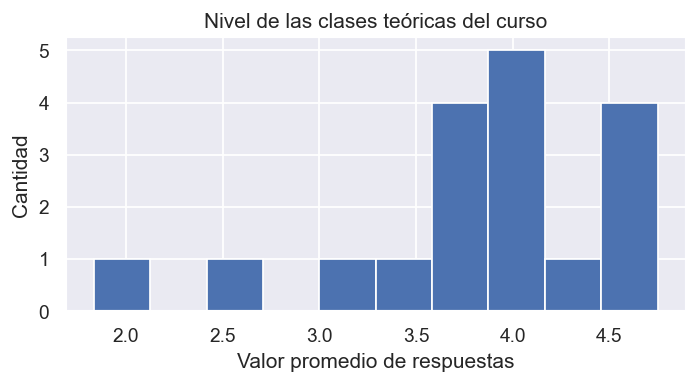

### Histograma de promedios de Nivel de las clases prácticas del curso

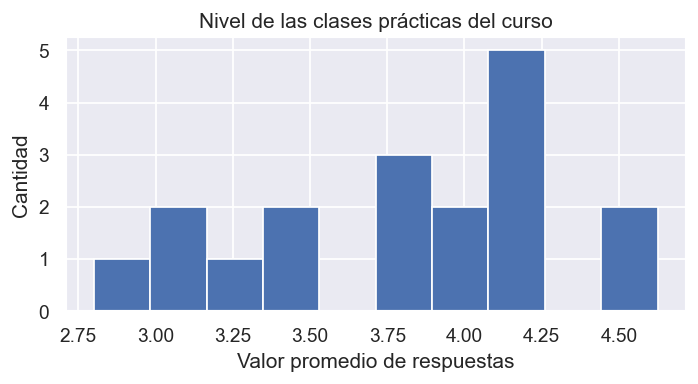

### Histograma de promedios de Dificultad del curso

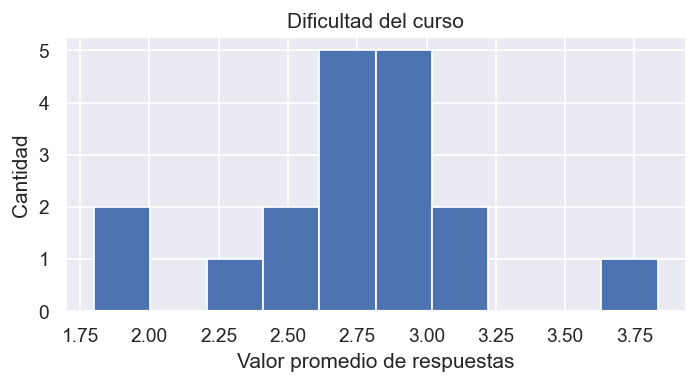

### Histograma de promedios de Dificultad del TP

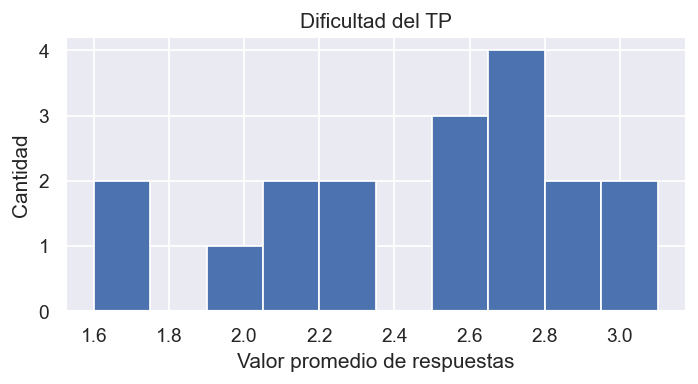

### Histograma de promedios de Promedio nivel teóricas y prácticas

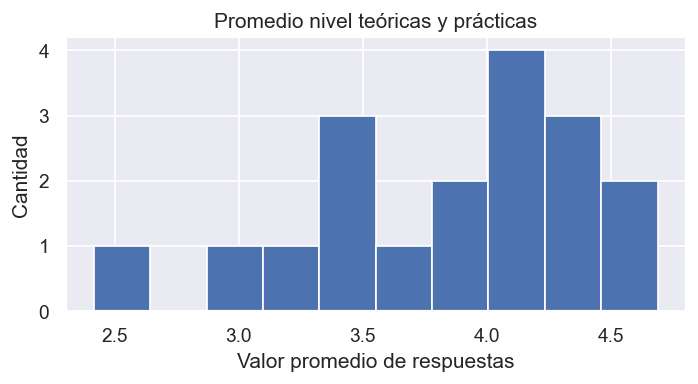

In [14]:
for col in num_cols:

    display(Markdown(f"### Histograma de promedios de {col}"))
    fig = plt.figure(dpi=125, figsize=(6.4, 2.9))

    values = comp_5p_mean[col].copy()
    if col in cols_sino:
        values *= 20

    plt.hist(values, bins=10)
    plt.title(col)
    plt.ylabel("Cantidad")

    xlabel = "Valor promedio de respuestas"
    if col in cols_sino:
        xlabel = f"{xlabel} (%)"

    plt.xlabel(xlabel)
    plt.show()

## Ranking de cursos por promedio

### Opinión general sobre el curso

Se analizan los promedios por curso de Opinión general sobre el curso. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

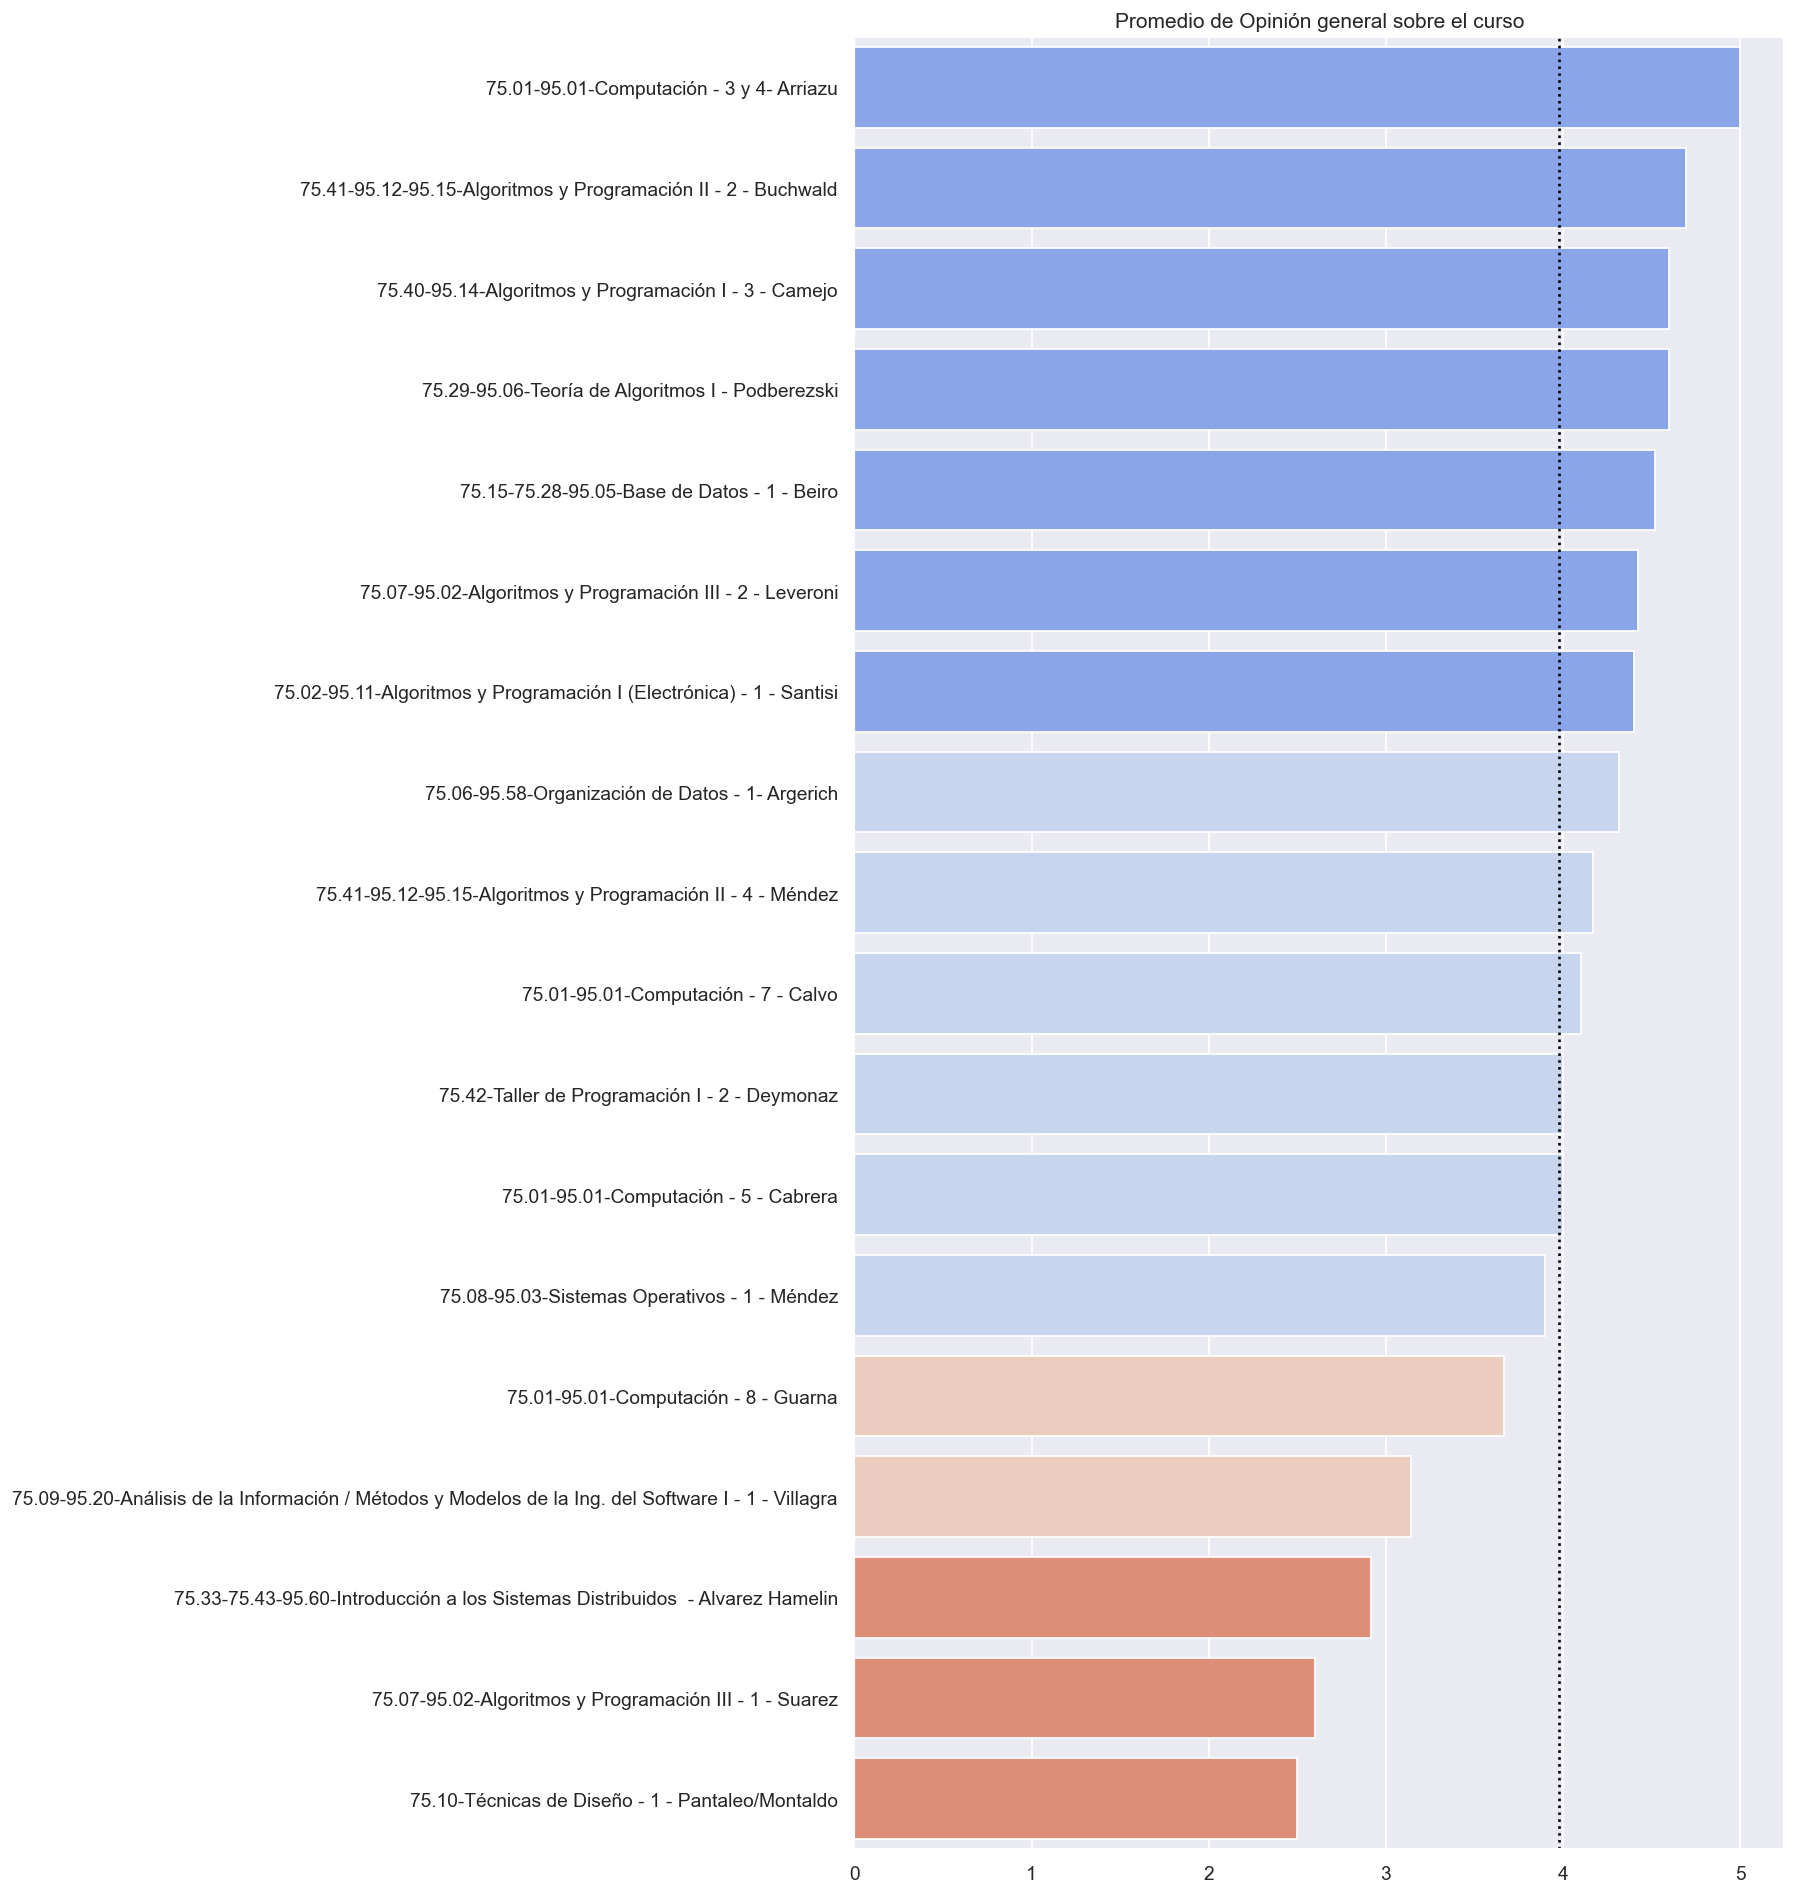

### ¿Aprobó la cursada?

Se analizan los promedios por curso de ¿Aprobó la cursada?. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

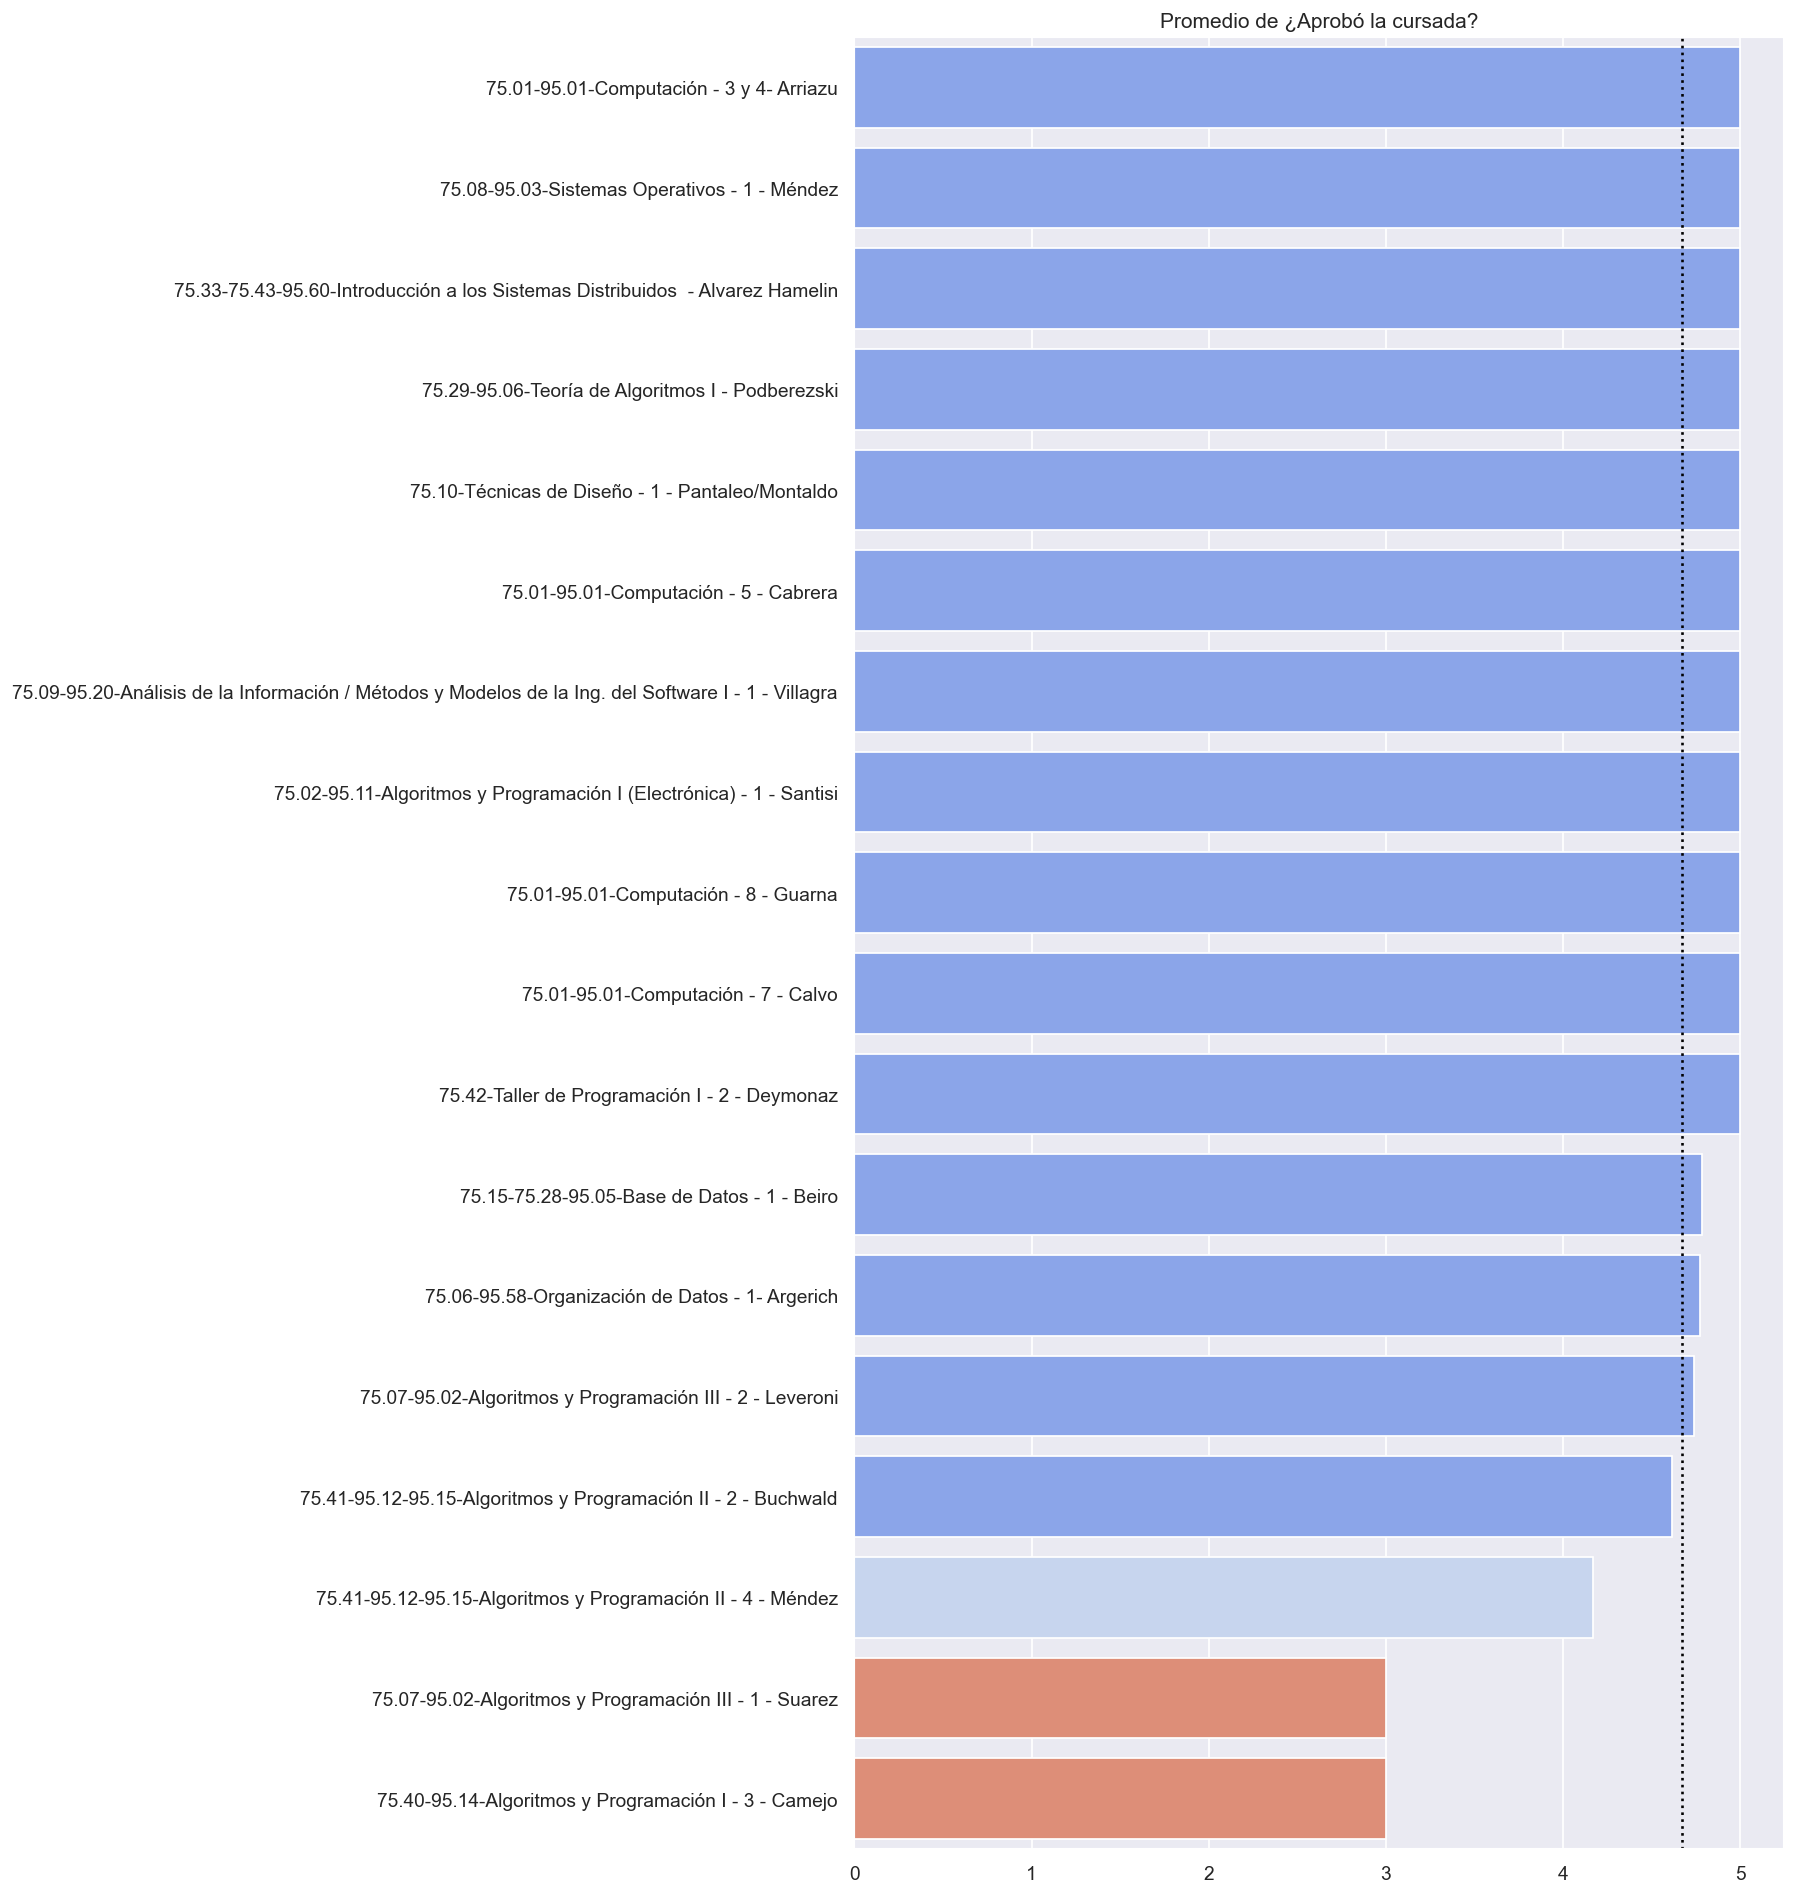

### ¿Cómo te resultaron los temas de la materia?

Se analizan los promedios por curso de ¿Cómo te resultaron los temas de la materia?. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

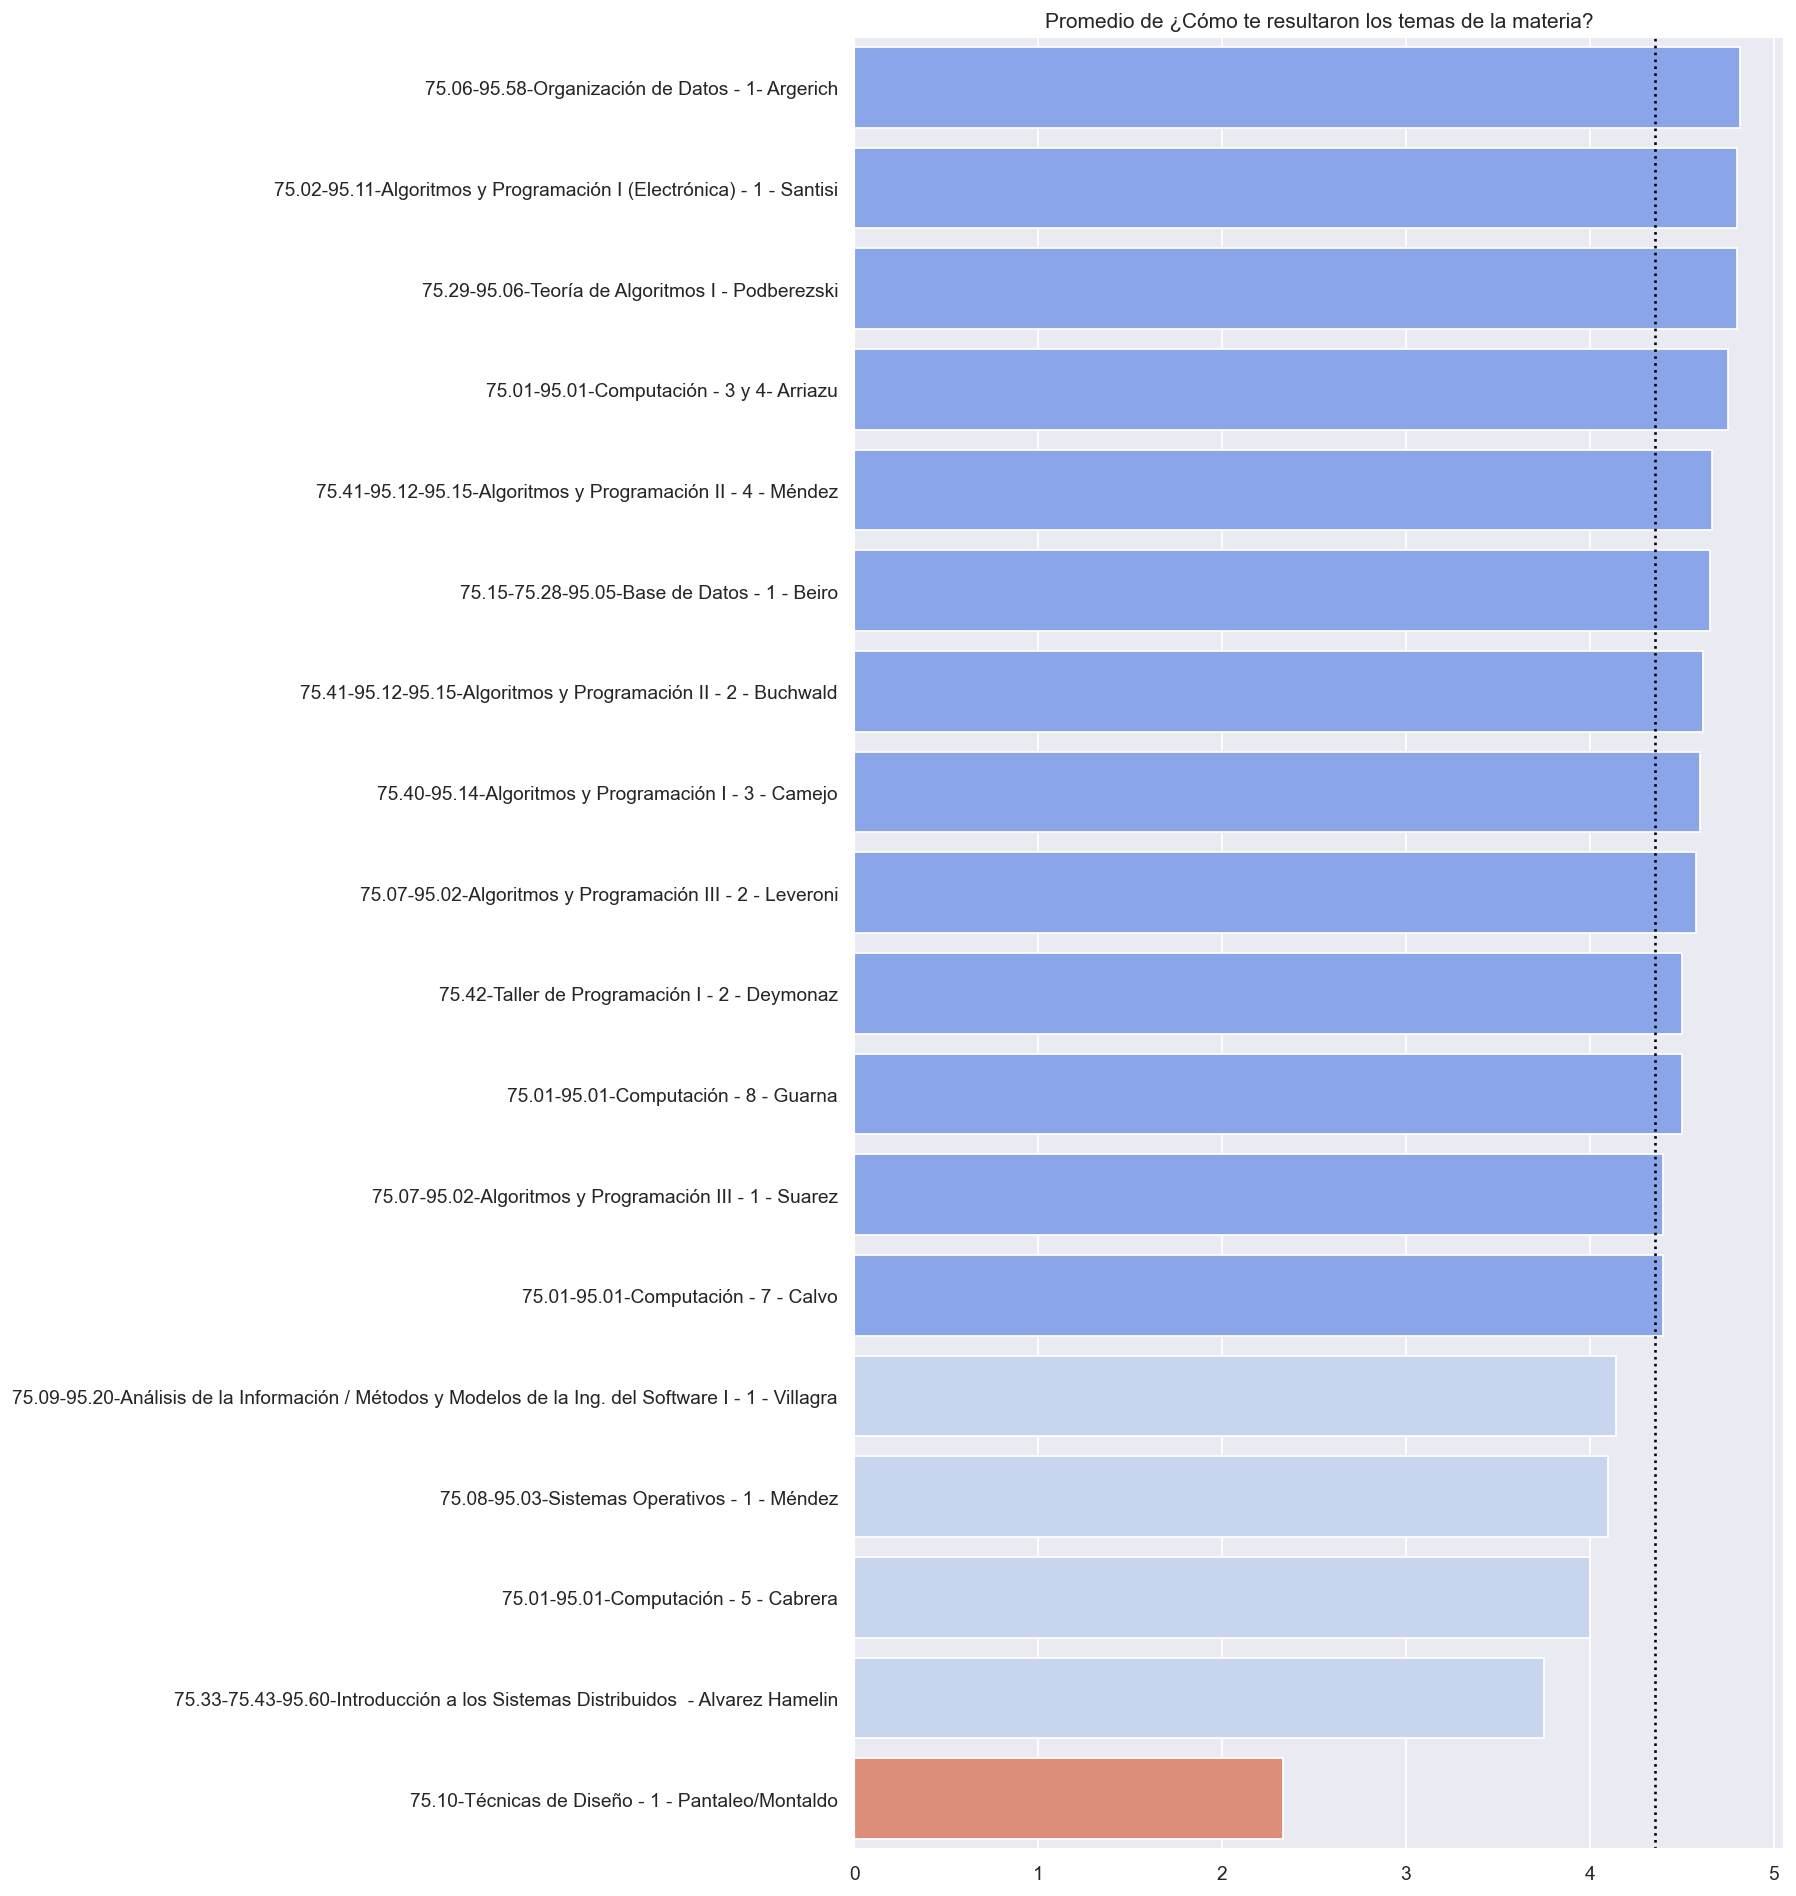

### ¿Los temas de la materia están actualizados?

Se analizan los promedios por curso de ¿Los temas de la materia están actualizados?. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

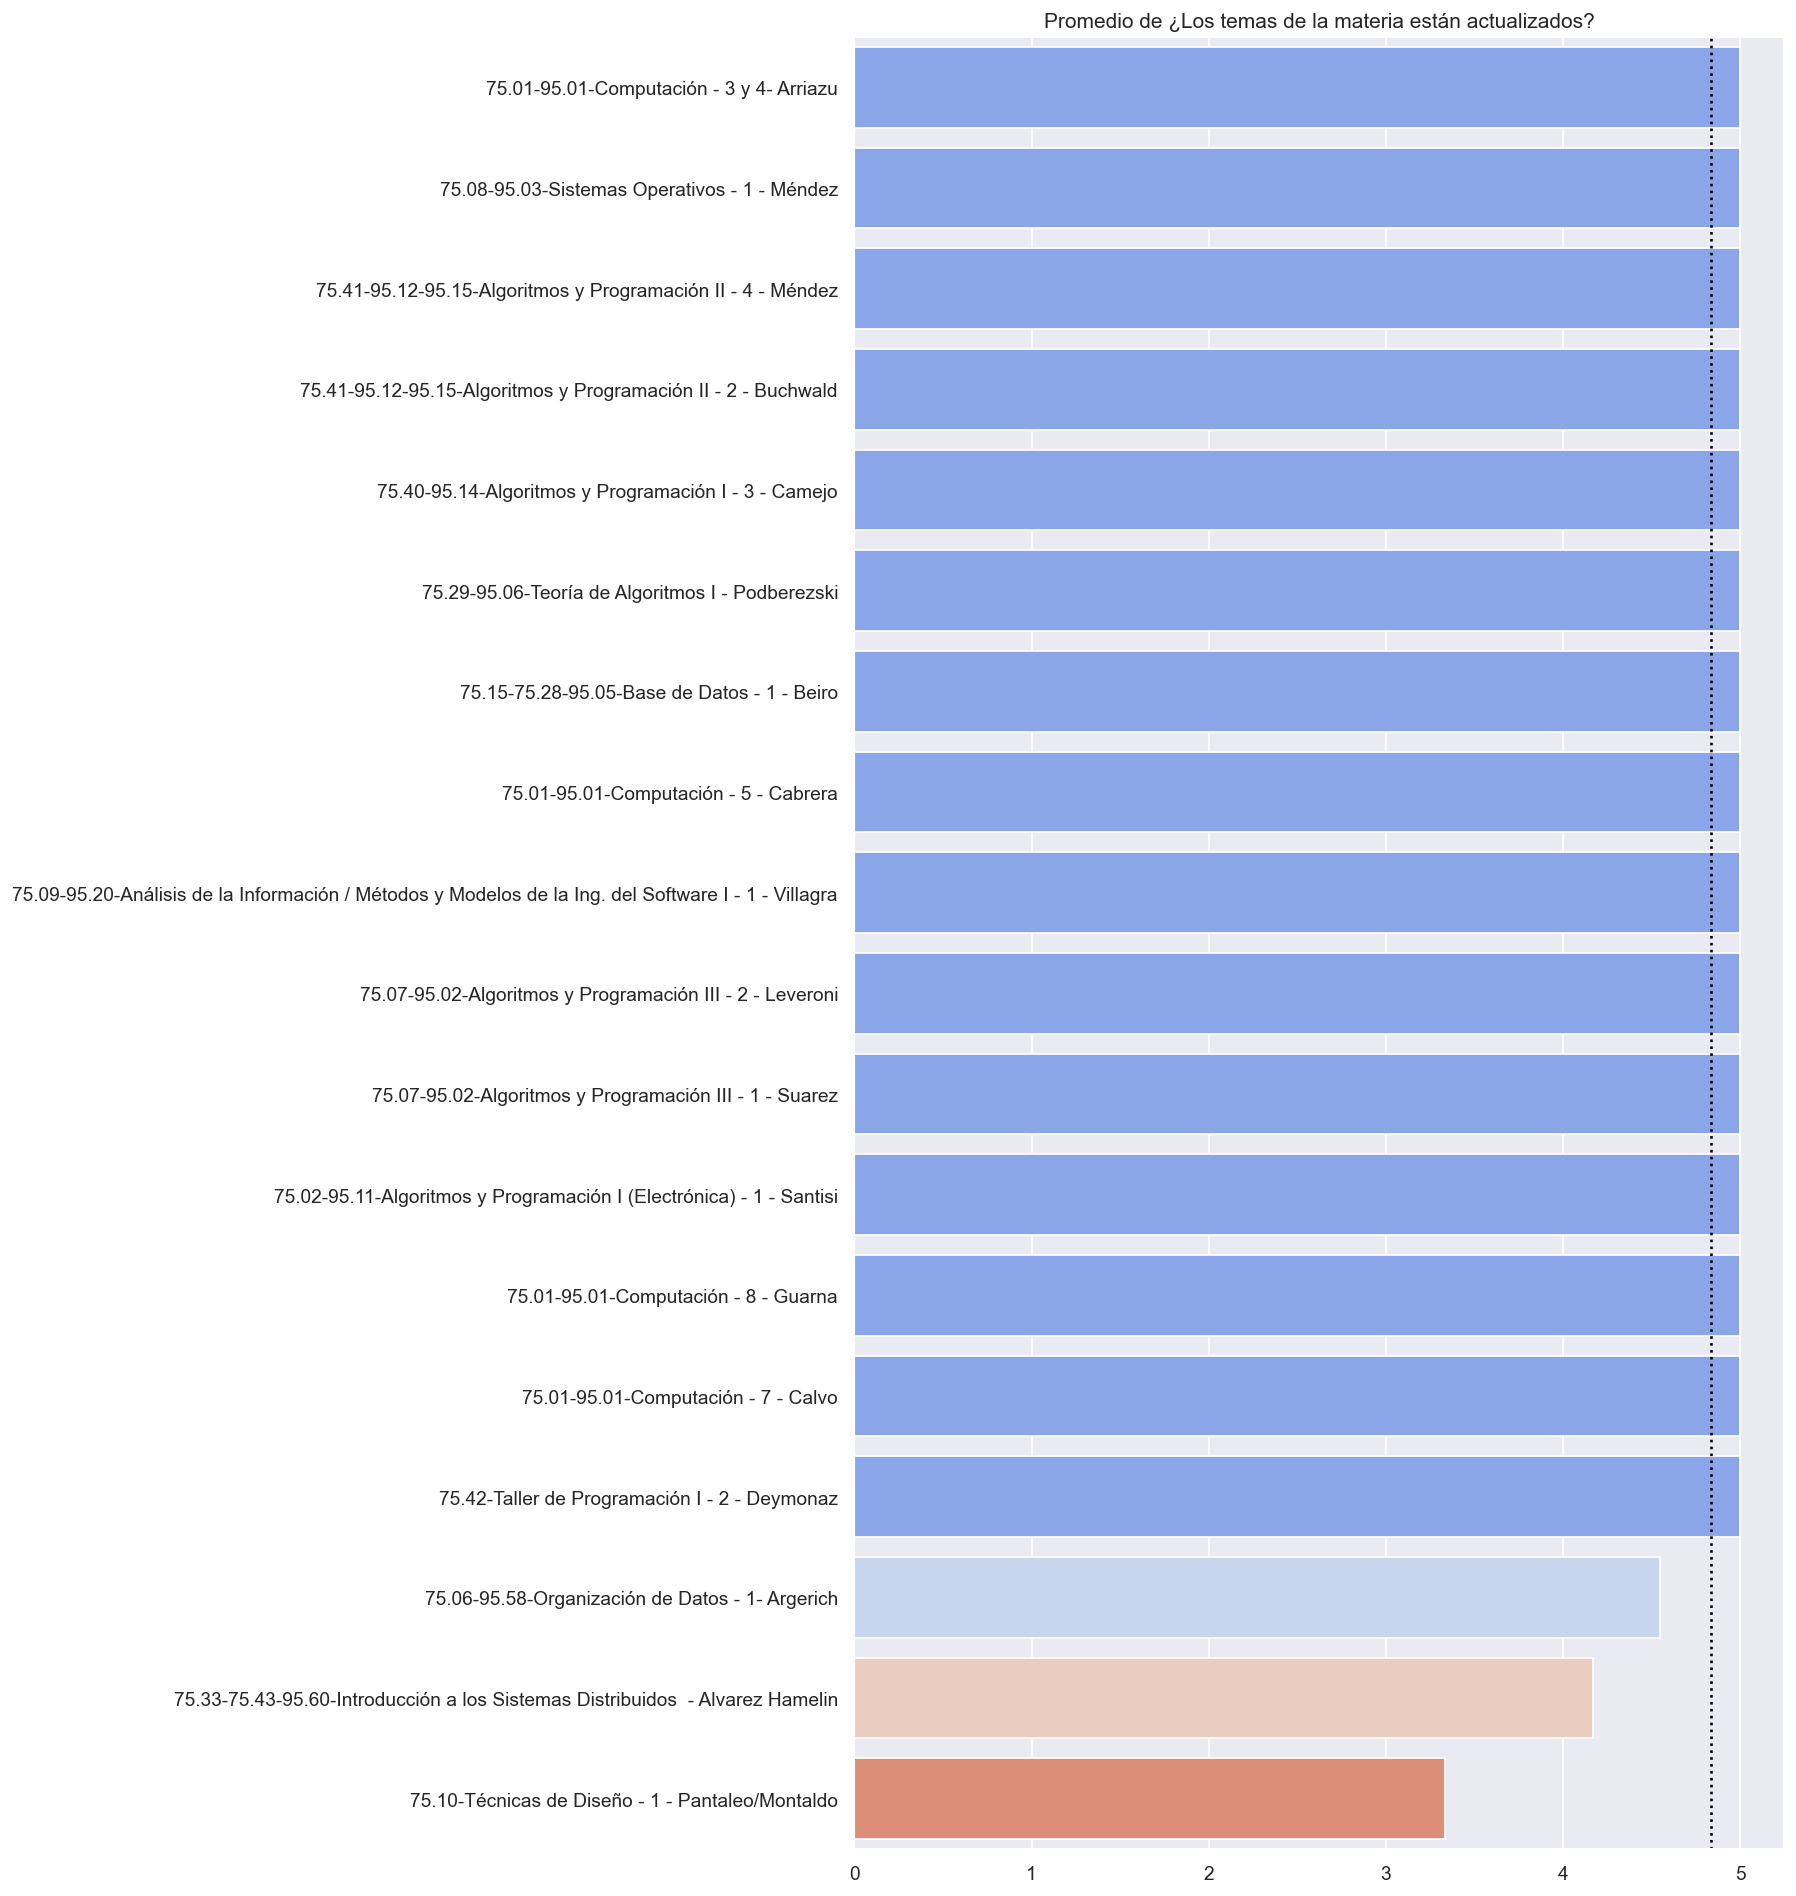

### Nivel de las clases teóricas del curso

Se analizan los promedios por curso de Nivel de las clases teóricas del curso. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

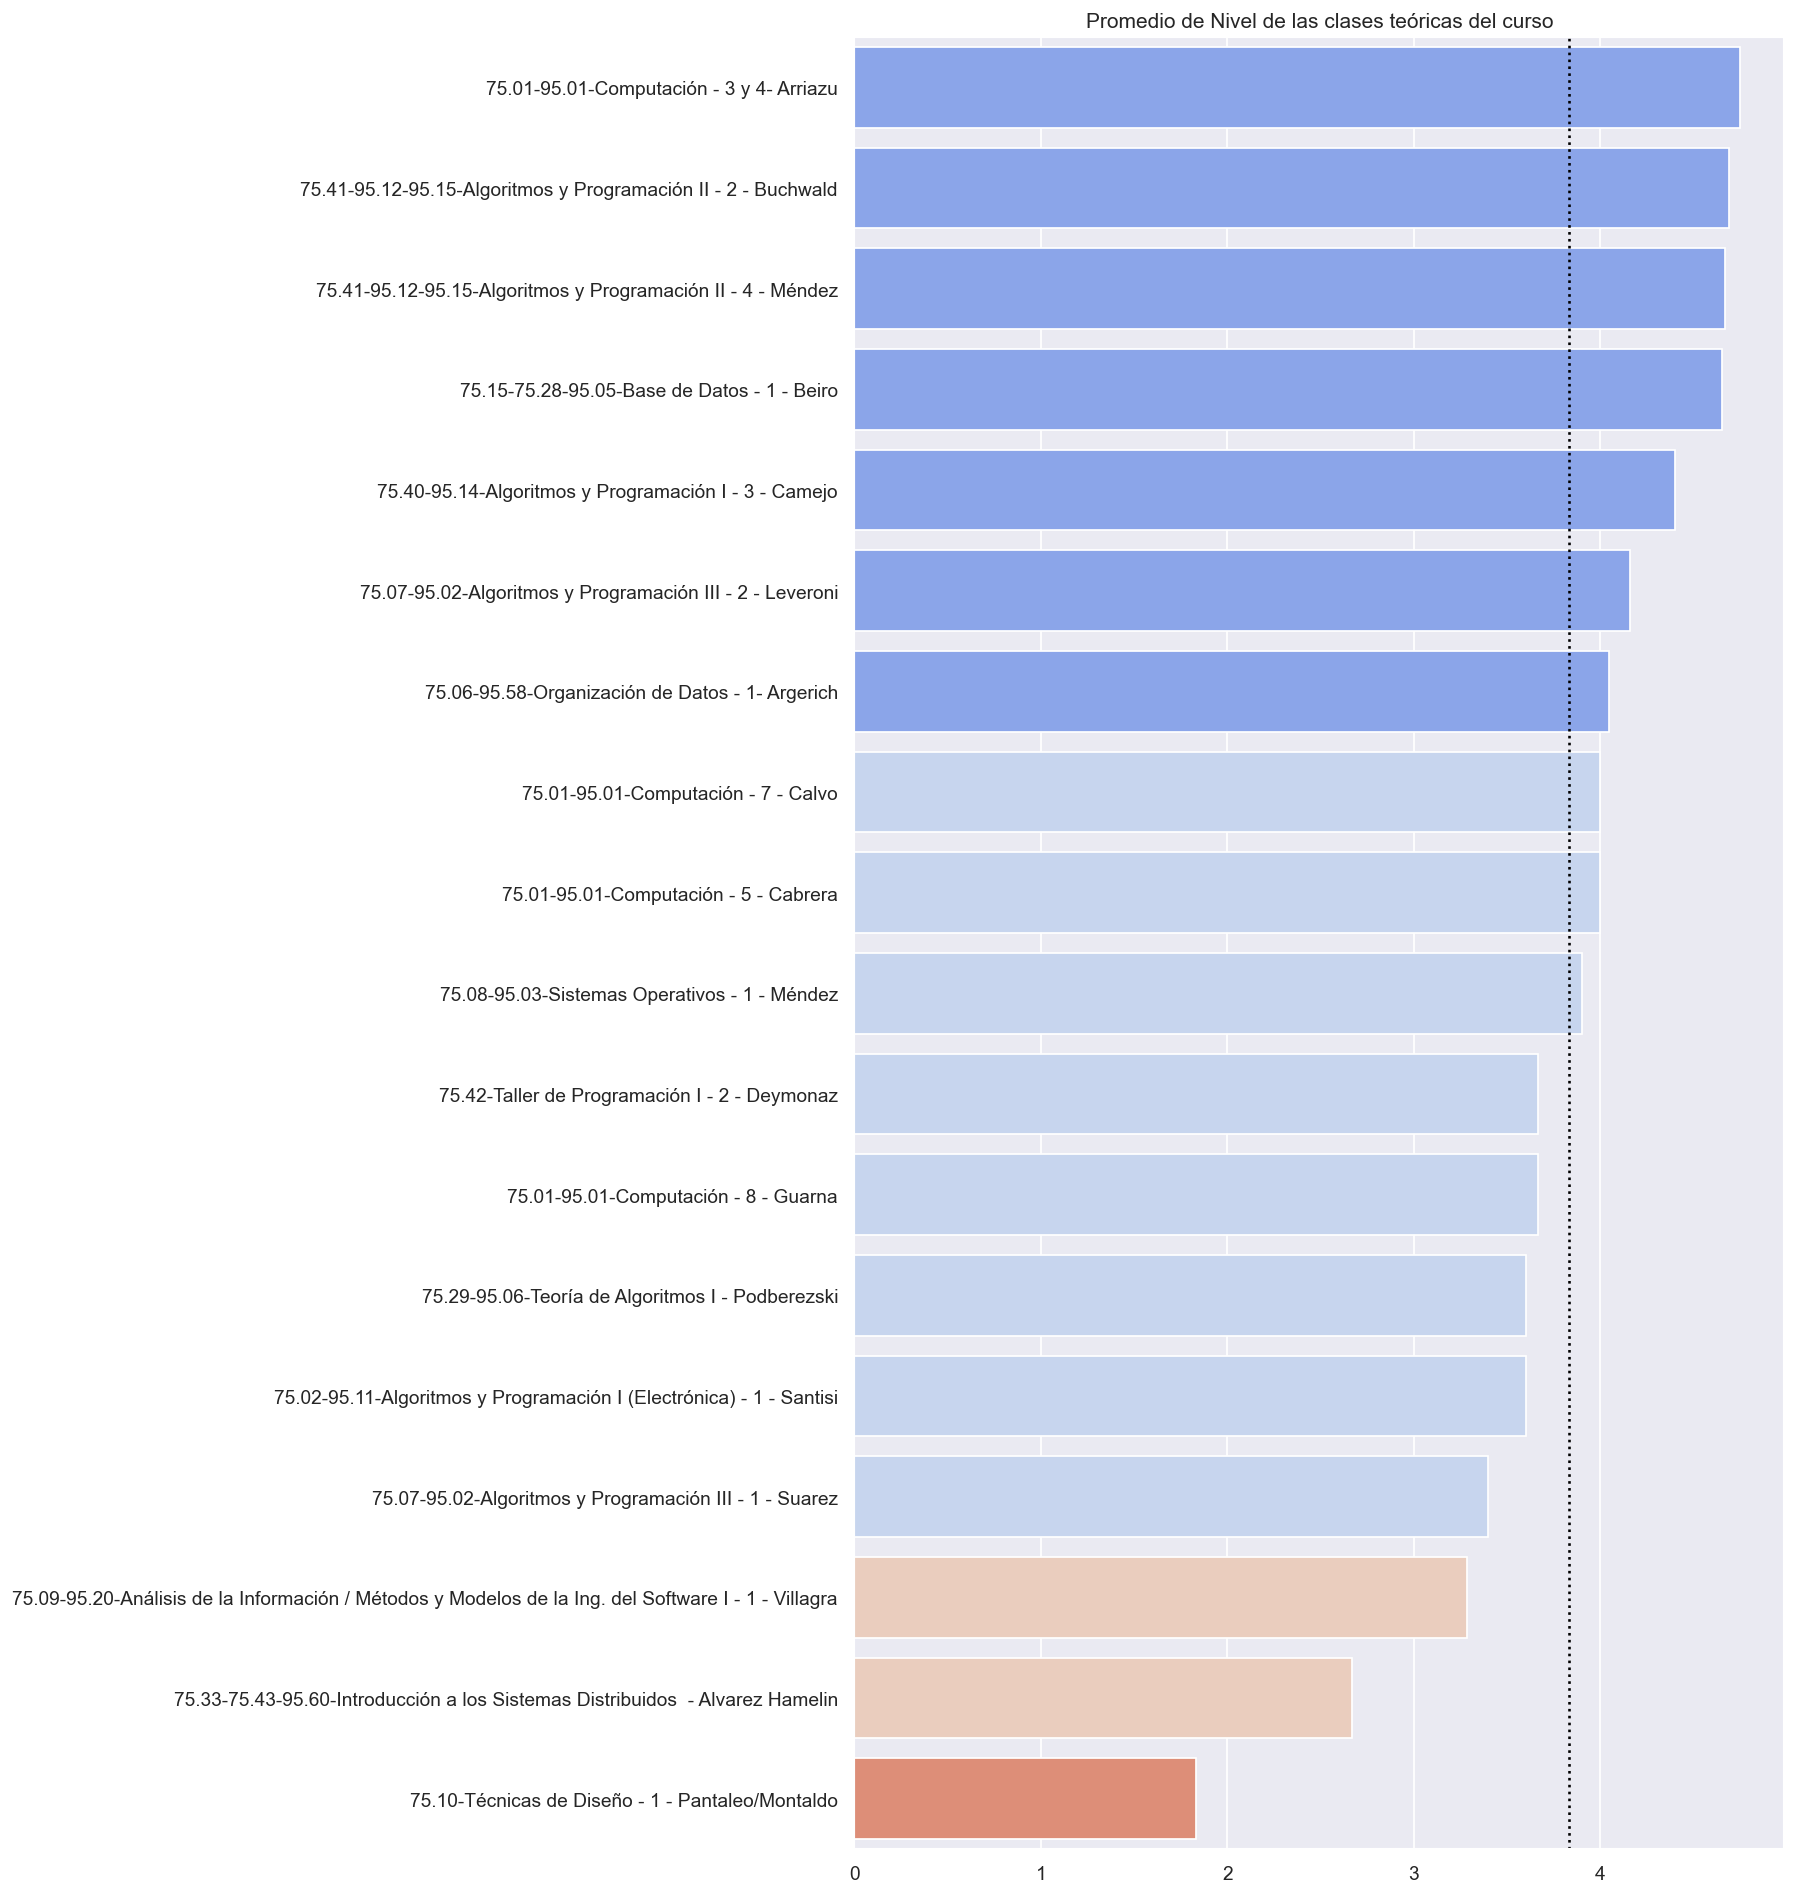

### Nivel de las clases prácticas del curso

Se analizan los promedios por curso de Nivel de las clases prácticas del curso. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

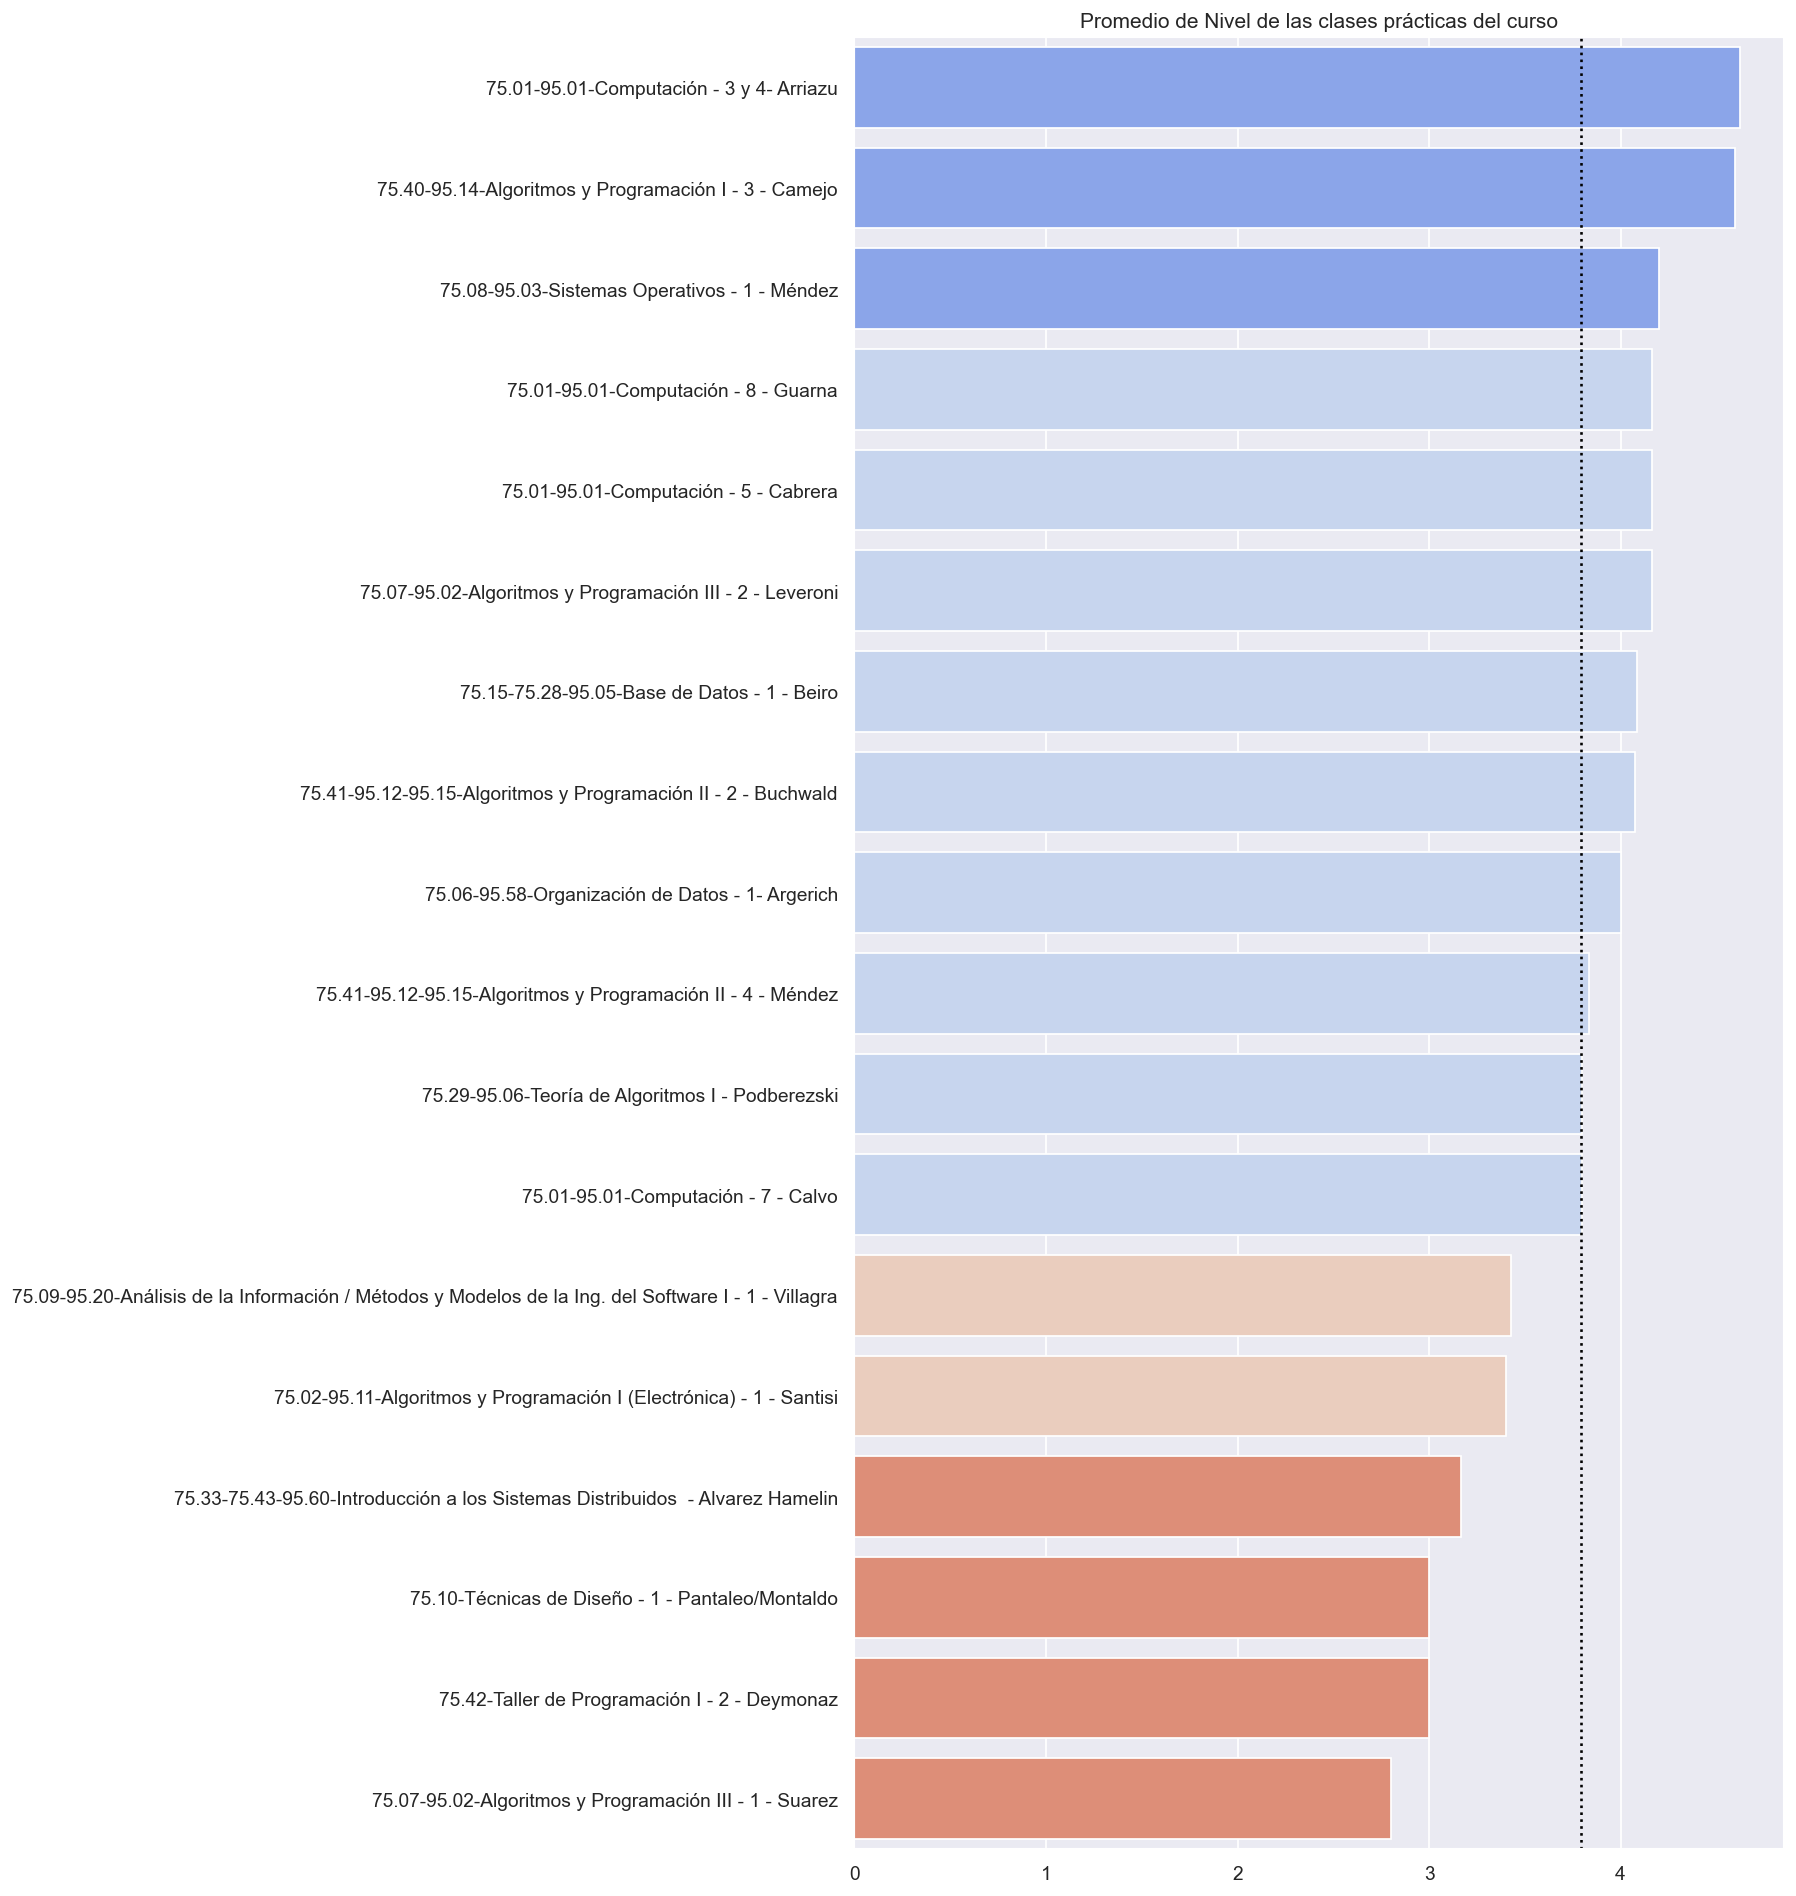

### Dificultad del curso

Se analizan los promedios por curso de Dificultad del curso. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

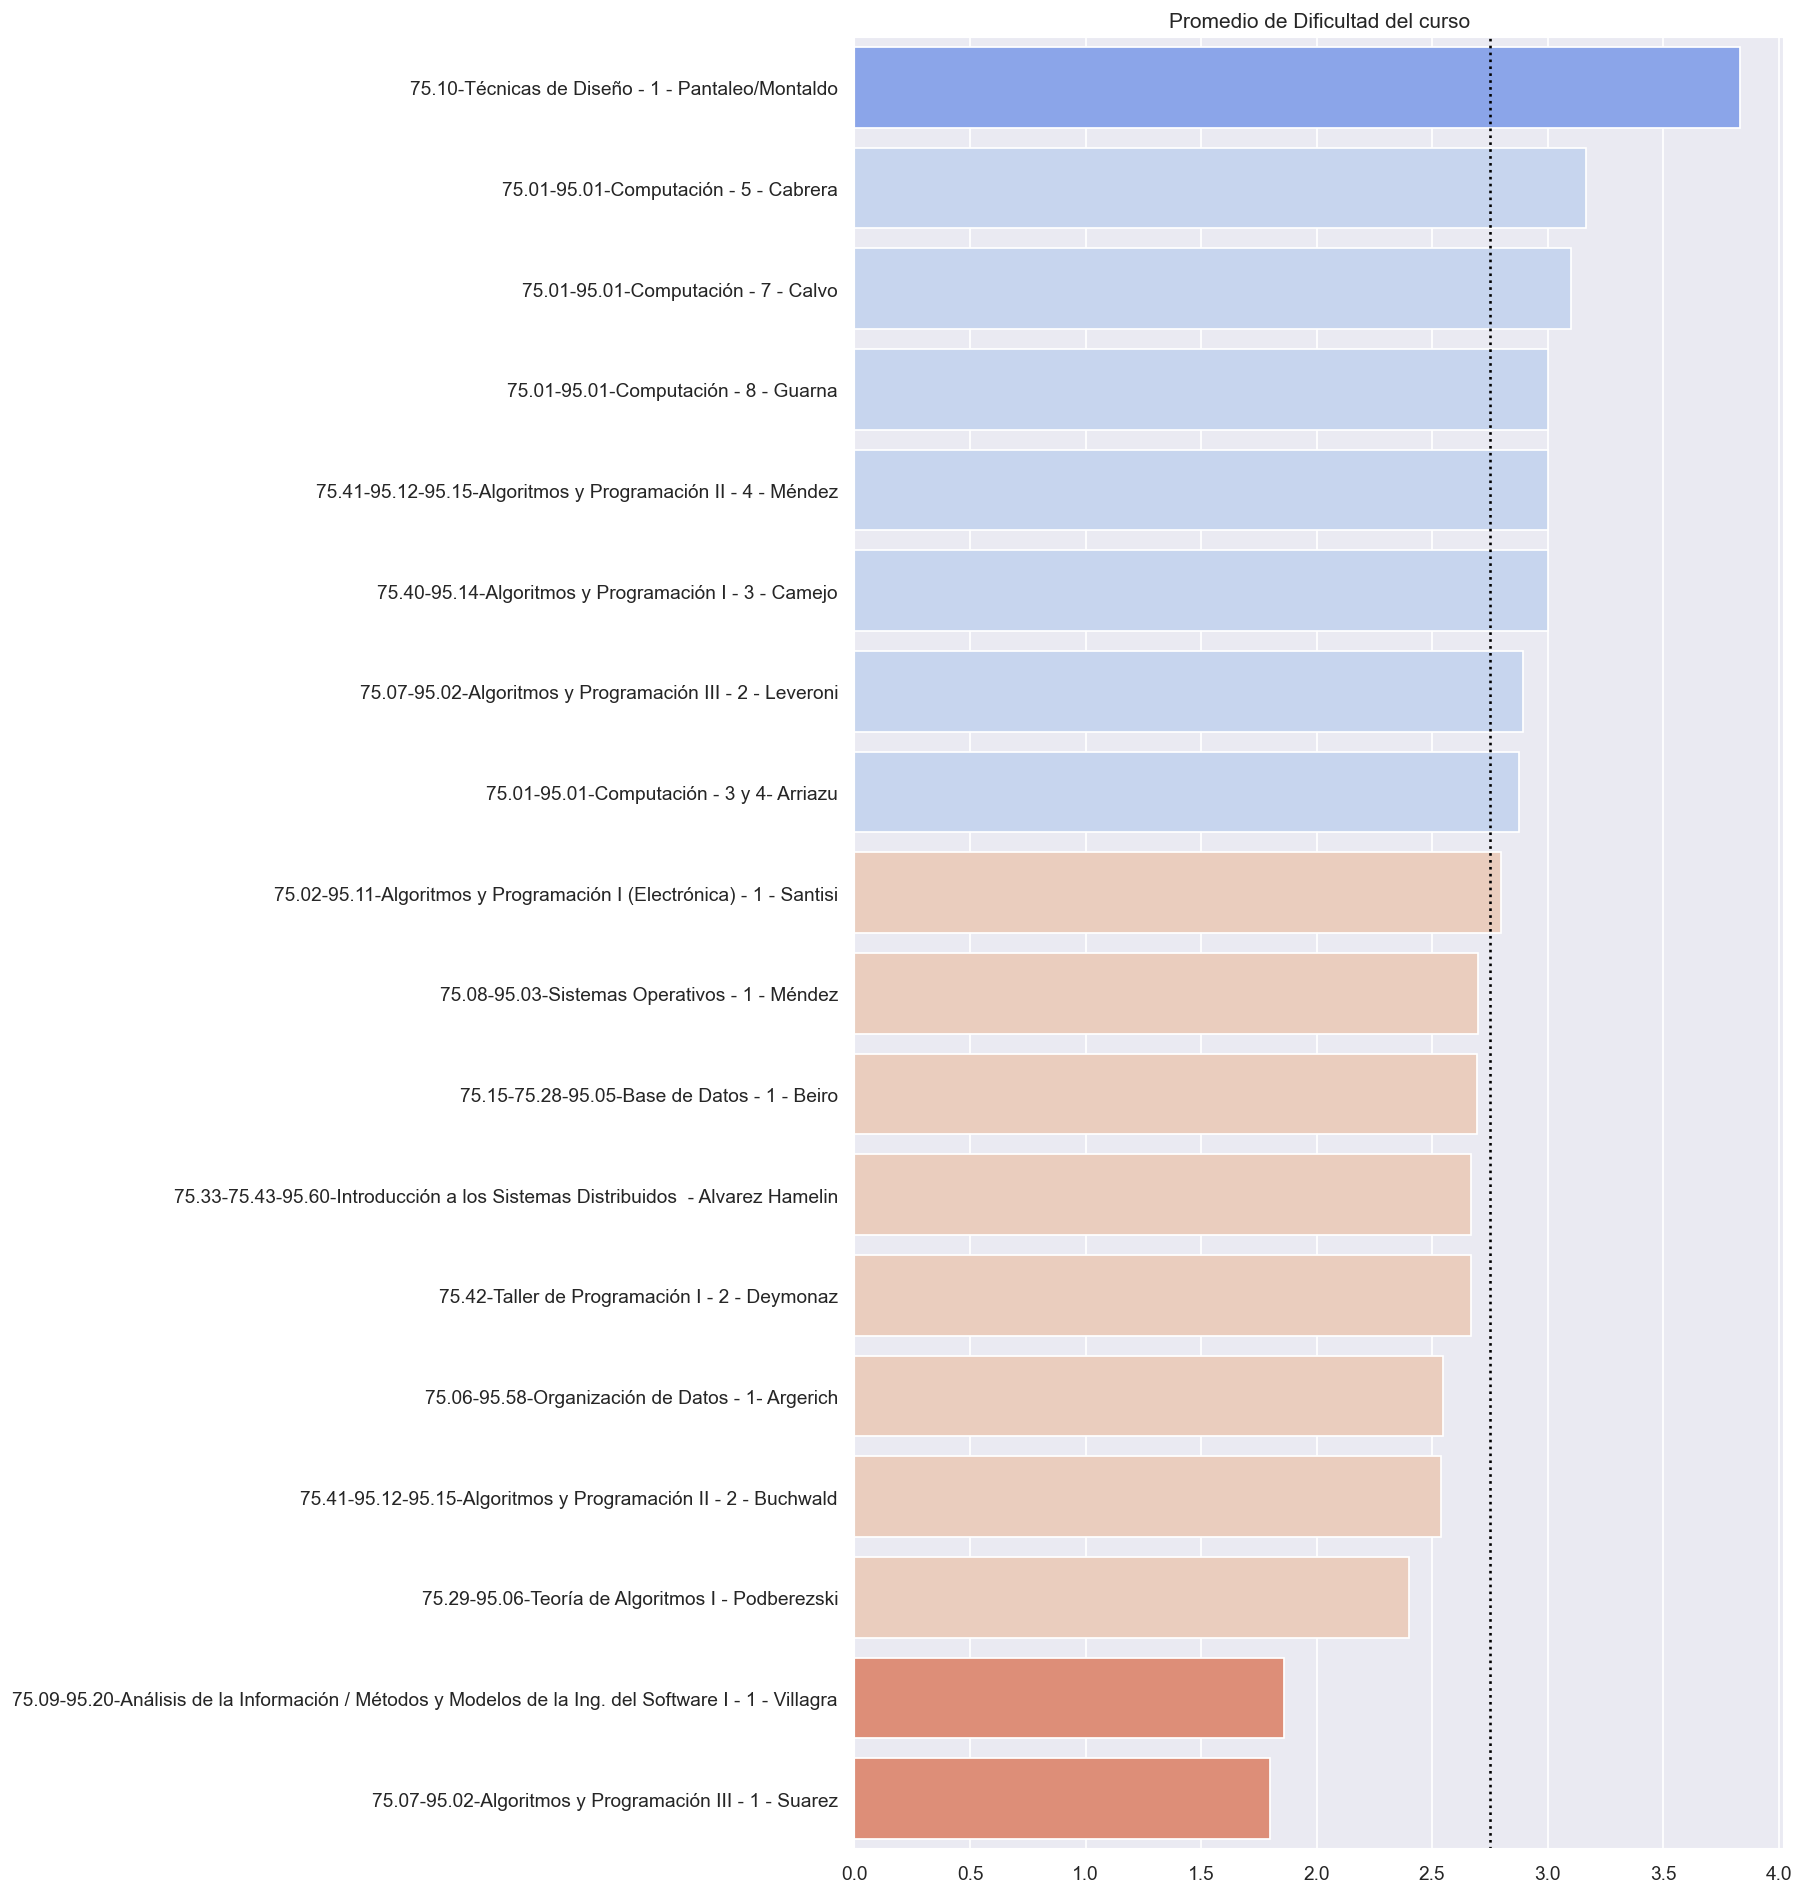

### Dificultad del TP

Se analizan los promedios por curso de Dificultad del TP. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

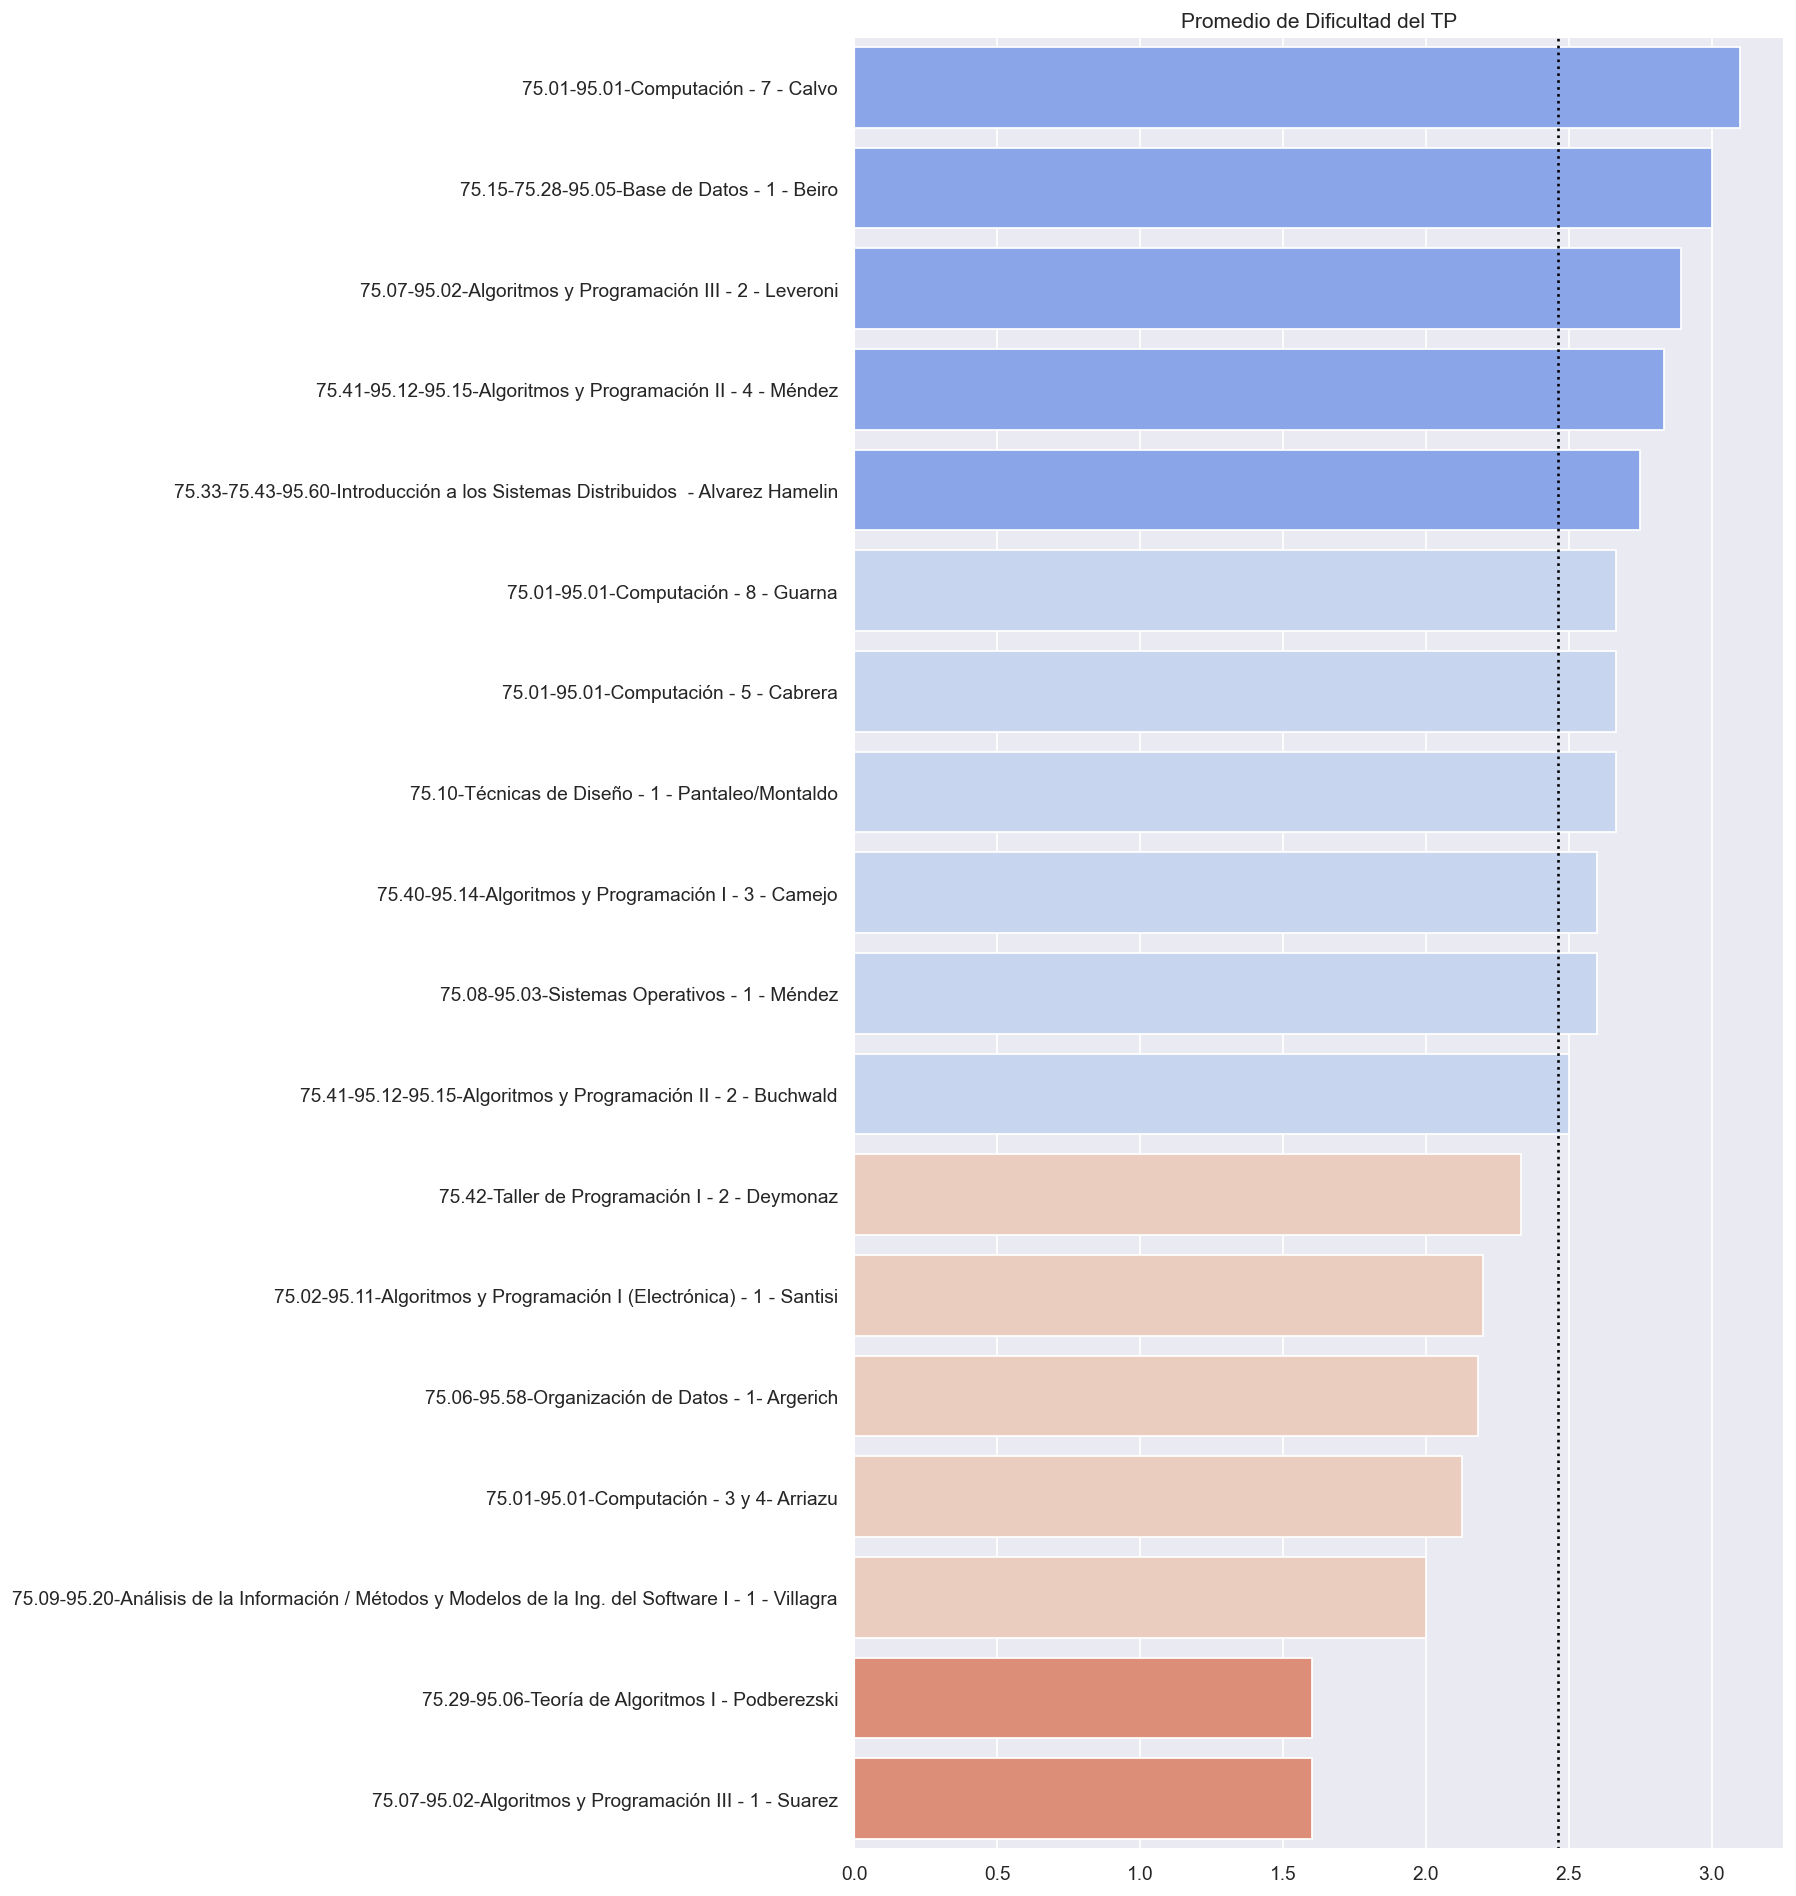

### Promedio nivel teóricas y prácticas

Se analizan los promedios por curso de Promedio nivel teóricas y prácticas. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

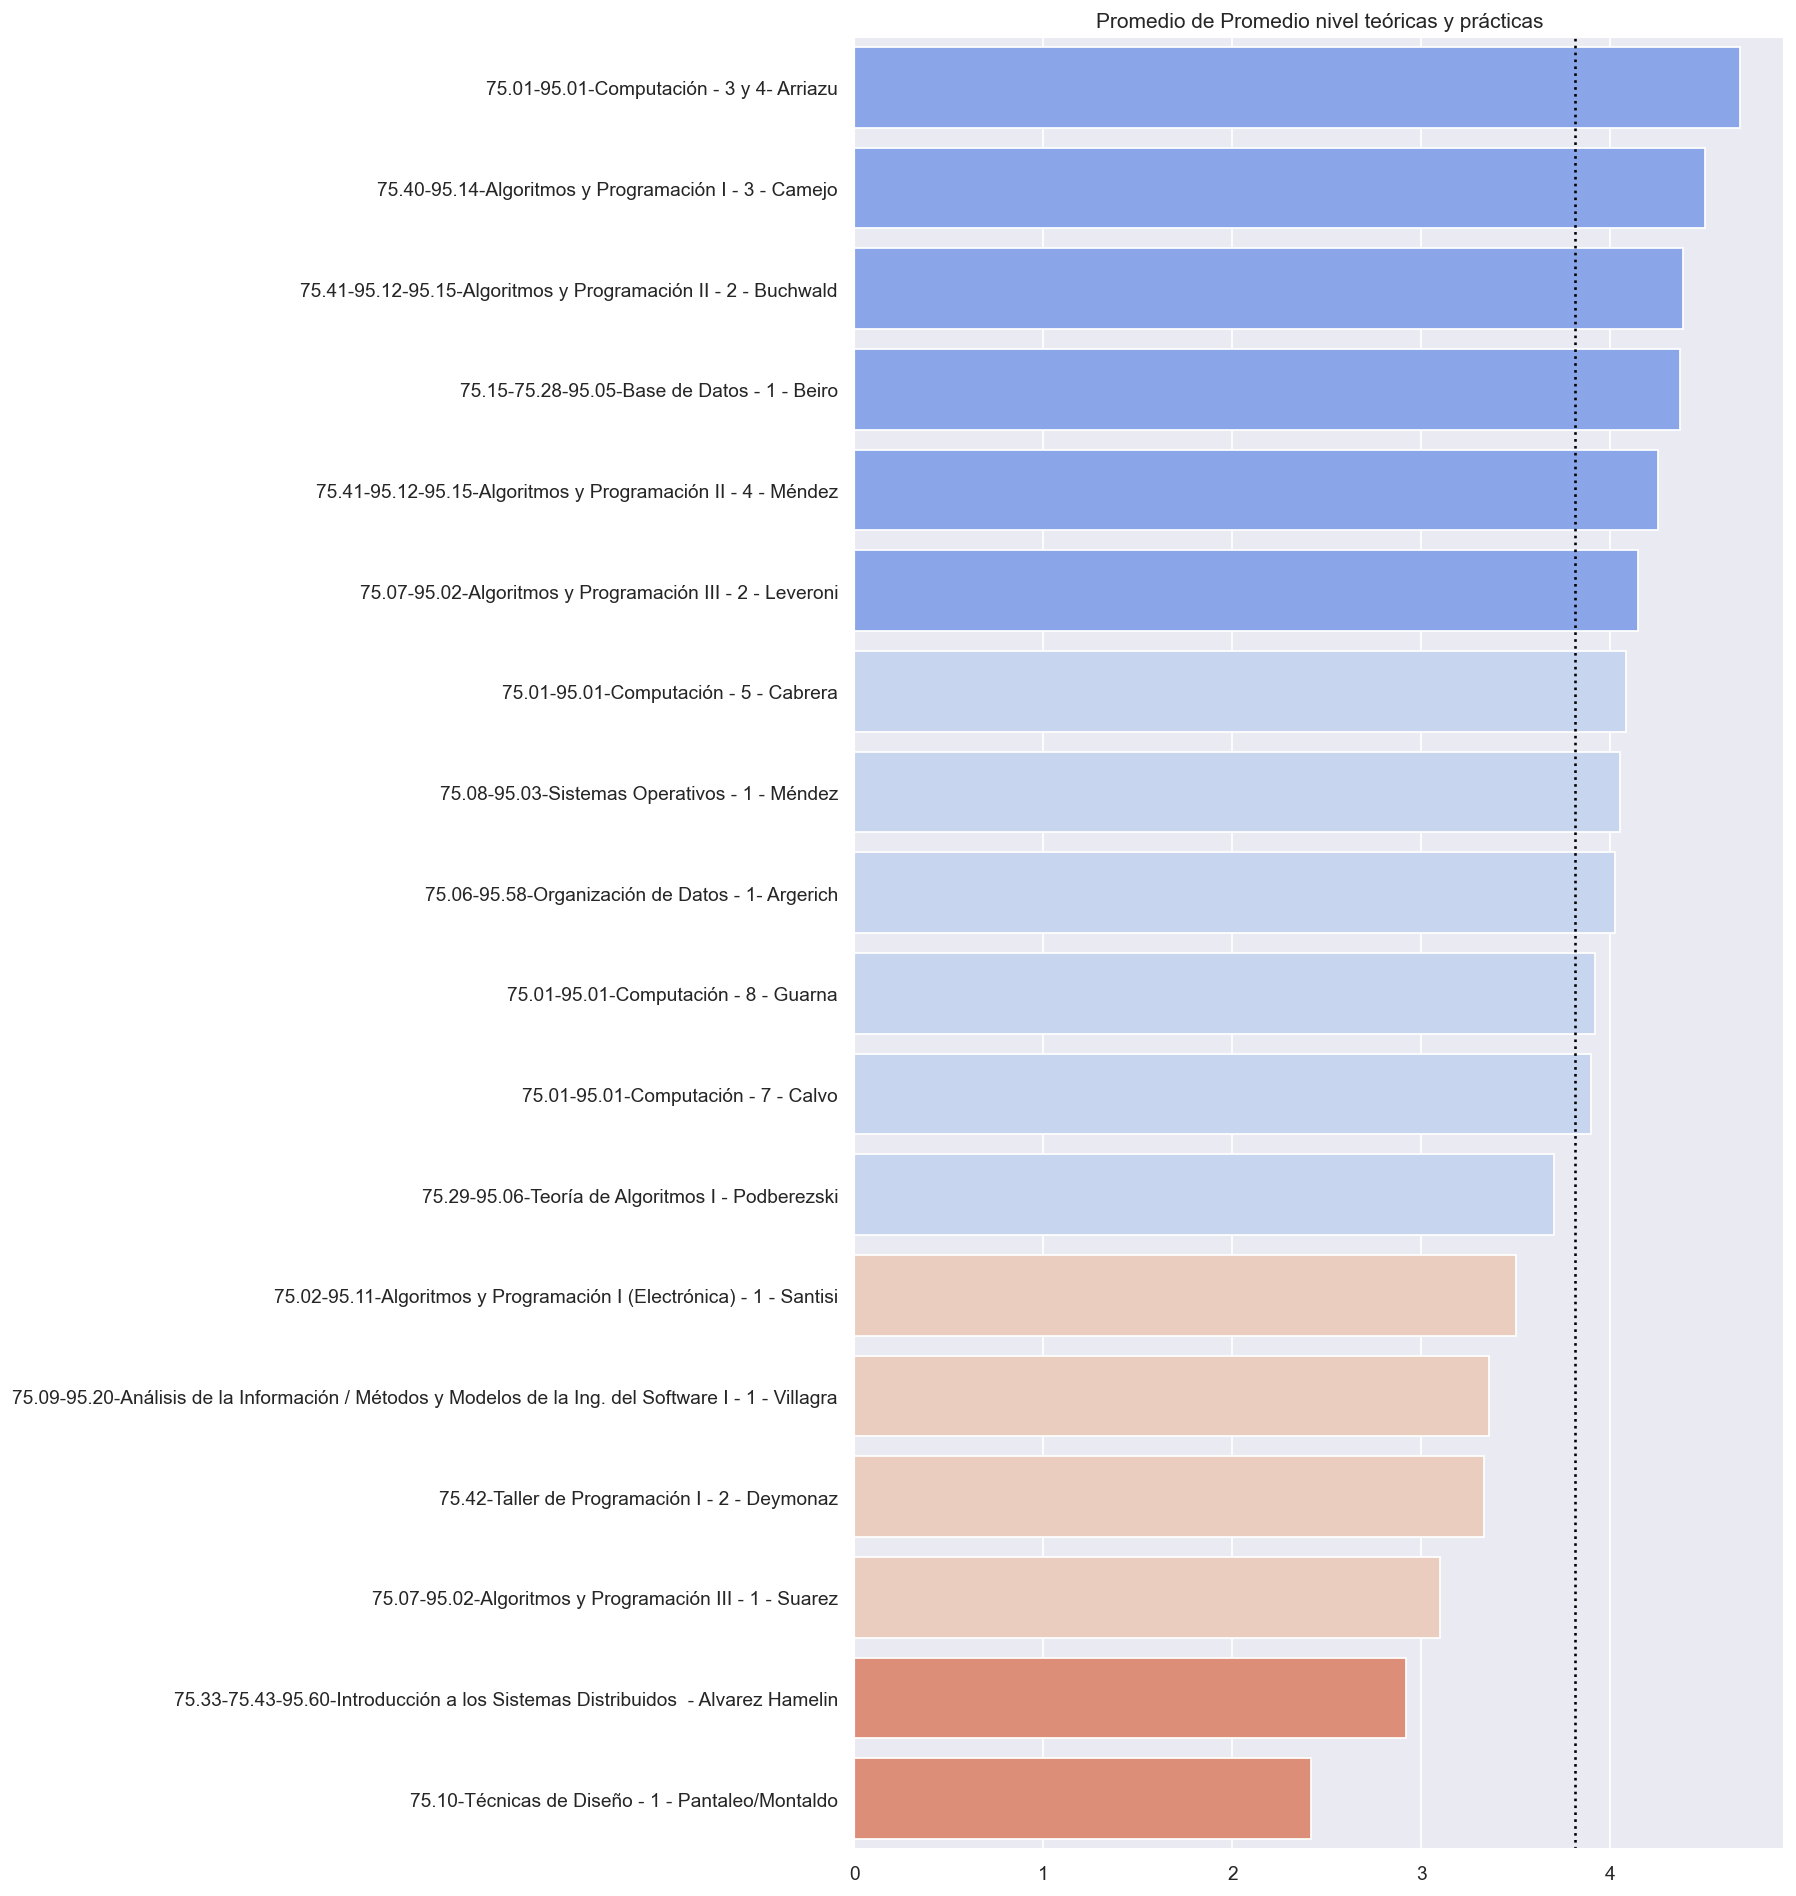

In [15]:
n_bins = 4

for col in num_cols:

    display(Markdown(f"### {col}"))
    display(
        Markdown(
            f"Se analizan los promedios por curso de {col}. Se dividen en {n_bins} contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores."
        )
    )

    values = comp_5p_mean[col].sort_values(ascending=False)

    c = pd.cut(
        values, bins=n_bins, labels=sns.color_palette("coolwarm_r", n_colors=n_bins),
    )

    plt.figure(dpi=125, figsize=(6.4 * 1.5, 4.8 * 4))
    ax = sns.barplot(x=values.values, y=values.index, palette=c.values)
    # ax = values.plot(kind='barh', color=c.values)

    ax.axvline(values.mean(), linestyle=":", color="black")

    plt.title(f"Promedio de {col}")
    plt.ylabel("")
    plt.show()

## Correlacion Entre Variables

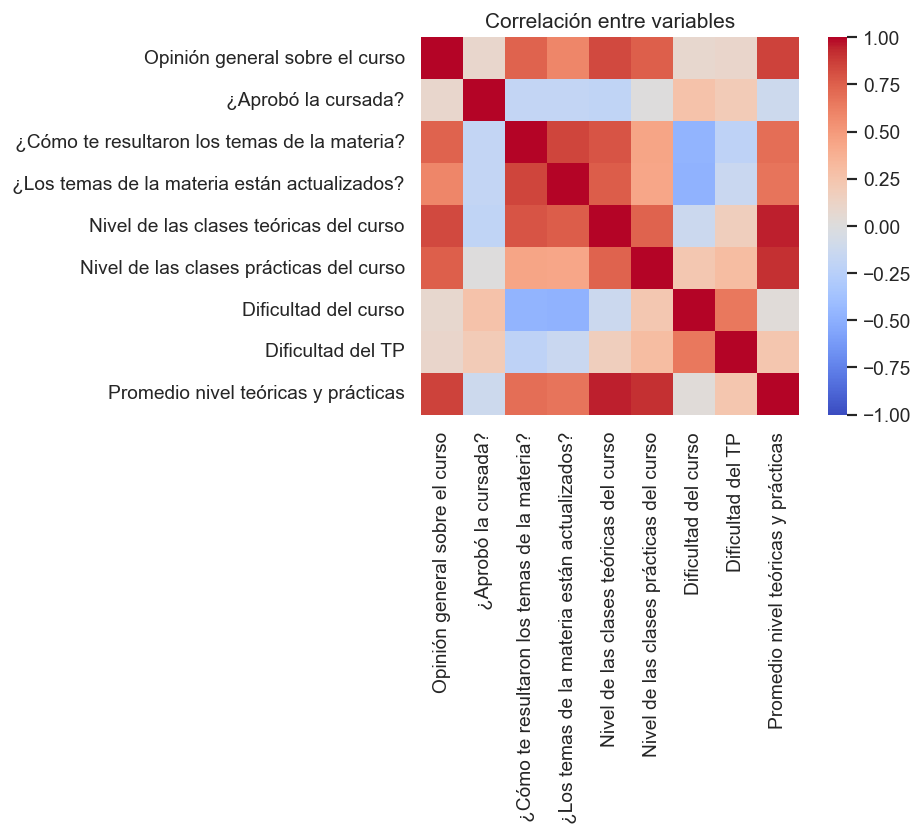

In [16]:
plt.figure(dpi=125)
sns.heatmap(
    comp_5p_mean[num_cols].corr(), square=True, vmin=-1, vmax=1, cmap="coolwarm"
)
plt.title("Correlación entre variables")
plt.show()

## Diferencia Entre Nivel de Clases Teóricas y Prácticas
- Hacia la derecha: Las clases teóricas son mejores que las prácticas.  
- En el centro: Poca o Ninguna diferencia.  
- Hacia la izquierda: Las clases prácticas son mejores que las teóricas.  

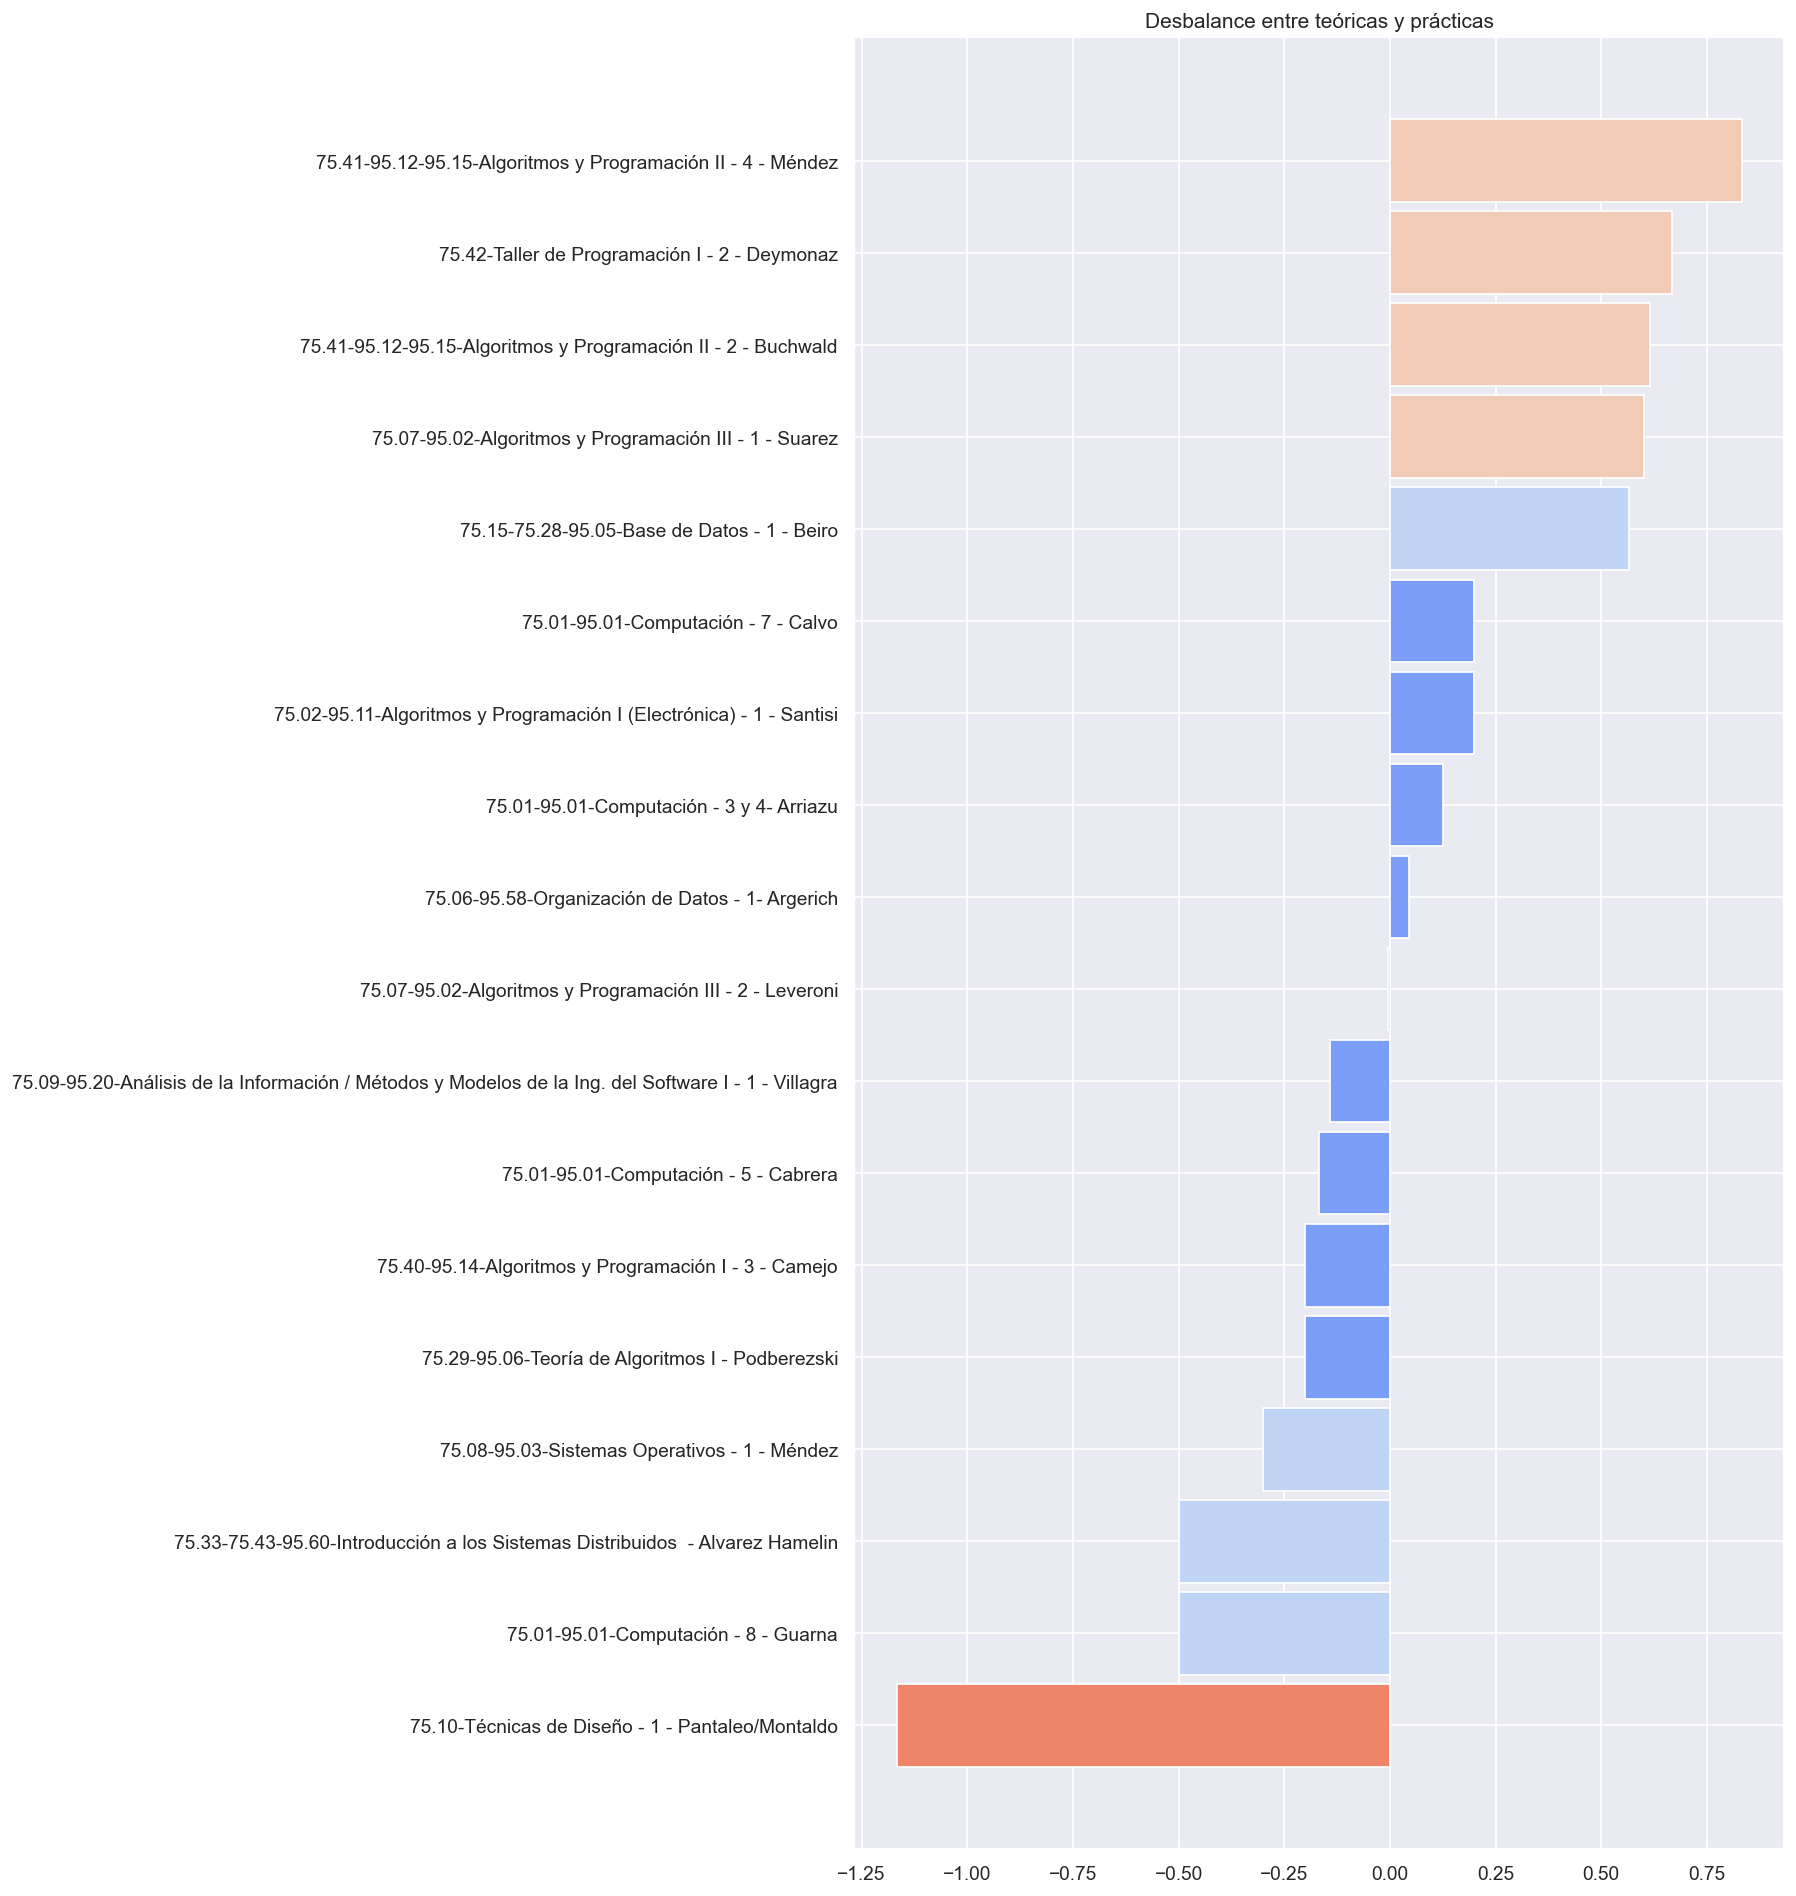

In [17]:
diff_teo_prac = (
    comp_5p_mean["Nivel de las clases teóricas del curso"]
    - comp_5p_mean["Nivel de las clases prácticas del curso"]
).sort_values()

plt.figure(dpi=125, figsize=(6.4 * 1.5, 4.8 * 4))

c = pd.cut(
    diff_teo_prac.abs(), bins=4, labels=sns.color_palette("coolwarm", n_colors=4),
)

plt.barh(diff_teo_prac.index, diff_teo_prac.values, color=c, height=0.9)

plt.title("Desbalance entre teóricas y prácticas")
plt.ylabel("")
plt.xlabel("")

plt.show()

## Emails

La pregunta del mail no fue incluida en esta ocasión. Pero al menos podemos ver la intención de la gente:

¿Permiten que se comparta al docente?

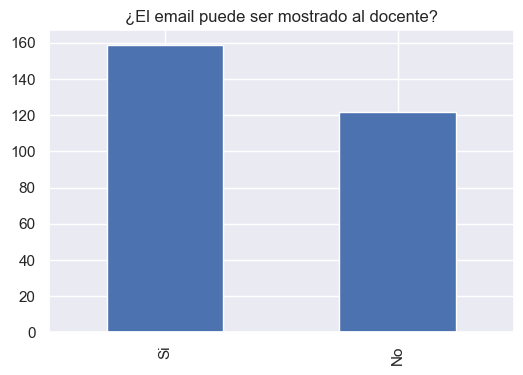

In [18]:
plt.figure(dpi=100)
comp["¿El email puede ser mostrado al docente?"].value_counts().plot(kind="bar")
plt.title("¿El email puede ser mostrado al docente?")
plt.show()

# Comentarios sobre la cursada virtual

In [19]:
def procesar_comentario(c):
    lineas = c.split("\n")
    return "\n".join([f"{l}" for l in lineas])


for curso in sorted(comp["Elige el curso"].unique()):
    display(Markdown(f"## Curso {curso}"))
    com = comp[comp["Elige el curso"] == curso][
        "¿Tenés algún otro comentario o sugerencia sobre el curso y la cursada virtual de este cuatrimestre?"
    ].dropna()
    if com.empty:
        display(Markdown("_No hay comentarios_"))
    else:
        todos_los_comentarios = com.str.capitalize().value_counts()
        for comentario, count in todos_los_comentarios.to_dict().items():
            if comentario == "":
                continue
            count_suffix = ""
            if count > 1:
                count_suffix = f"**({count} respuestas iguales)**"
            display(Markdown(f"- {procesar_comentario(comentario)} {count_suffix}\n\n"))

## Curso 75.01-95.01-Computación - 1 - Burin

_No hay comentarios_

## Curso 75.01-95.01-Computación - 2  - Servetto

_No hay comentarios_

## Curso 75.01-95.01-Computación - 3 y 4- Arriazu

_No hay comentarios_

## Curso 75.01-95.01-Computación - 5 - Cabrera

_No hay comentarios_

## Curso 75.01-95.01-Computación - 7 - Calvo

_No hay comentarios_

## Curso 75.01-95.01-Computación - 8 - Guarna

_No hay comentarios_

## Curso 75.01-95.01-Computación- 6 - Costa

- No 



## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 1 - Santisi

- - 



## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 2 - Azcurra

- Ojalá todas las demás materias fueran llevadas como esta cátedra lleva esta materia, un ejemplo a seguir. 



## Curso 75.03-95.57-Organización del Computador - 1 - Benitez

- Por favor no puede ser que el 90% del final sean preguntas teoricas, no hay chance de que toda la cursada sea de assembler, numeracion y abacus full practico y que en el final te pregunten 4 caracteristicas de los procesadores cisc tipo ??????????????????? 



- Tienen que cambiar completamente la forma de evaluar. 



- Si bien algunos docentes son muy buenos, otros ayudan poco y son irresponsables con los horarios de entrega de notas. 



## Curso 75.06-95.58-Organización de Datos - 1- Argerich

- Nada particularmente. 



- No. 



- Fue una experiencia muy enriquecedora. les agradezco por el trabajo que hicieron 



- Ojalá fuesen así el resto de cursos... 



- Esta materia es óptima para ser virtual, por usar mucho código y computadora  



- No 



- De las materias que curse de mi carrera hasta ahora (ing. informática) es lejos la que más interesante me resultó. me hubiera encantado explorarla un poco más si no fuera por los tiempos y las otras materias, pero igual me deja una base importante para el futuro. en cuanto a sugerencias, yo personalmente sufrí un poco los plazos entre cada tp. me pasó que terminé haciendo un esfuerzo importante con el primer tp (también es culpa mía porque lo arranqué pasada una semana) y ya al poco tiempo arrancó el segundo. quizás no vendría mal una pausa entre cada uno y terminar de digerir los nuevos temas. entiendo que el cuatri es corto y quizás no dan los tiempos, pero lo dejo como crítica constructiva por si sirviera para inspirar alguna idea. 



- Algunas clases teoricas tienen errores en el audio 



- Me gustaron mucho los temas y la manera en que fueron dados. la cursada es muy pesada pero vale la pena. siento que el último mes, sin embargo, fue muy liviano con respecto a los anteriores. esto no está mal porque en el último mes siempre en las demás materias se está muy exigido, pero se podría acomodar un poquito esto. la cantidad de contenidos e intensidad desde el tp1 hasta el tp3 es bastante alta. 
me gustó la modalidad de teóricas asincrónicas, kahoot, y luego práctica, porque te permite ver los contenidos bien, pausando y tomando apuntes, e incentiva a hacerlo debido al kahoot. lo único que creo que se podría probar es hacer un repaso teórico en la clase sincrónica, porque seguramente quedan muchas dudas, o cosas no tan claras, o incluso gente que no llegó a ver la teórica y por ende no va a sacar absolutamente nada de la clase. igualmente si se mantiene el formato actual creo que funciona dentro de todo muy bien.
por último, algunas clases teóricas creo que podrían ser mejoradas. gran parte de ellas están muy bien dadas y son entretenidas, pero algunas son mejorables. 
agrego una última cosa, el apunte de la materia es excelente, deberían sacarle más jugo. 
 



- Me parece que los contenidos de la materia se tendrían que organizar mejor, como en un drive. 
los notebooks que usábamos para las clases muchas veces estaban dispersos y los tenías que ir a buscar en diferentes lugares. las diapositivas de las clases teóricas directamente no estaban en ningún lado, por lo que si querías revisarlas sí o sí había que ir a los videos.
también creo que los notebooks podrían tener más texto explicando qué se hace o algo de teoría. hay varios notebooks que tienen puro código y a veces era difícil entender. 
fuera de esto la cátedra tiene unos docentes muy bien capacitados que sabían lo necesario para responder nuestras dudas y muchísimo más, y lo que explicaban en clase estaba muy bien. tal vez alguna vez con los últimos temas sentí que íbamos muy rápido, en especial en redes neuronales, en donde pienso que empezar por ejemplos más simples en vez de con imágenes nos hubiera servido más.
la verdad estoy contento con la experiencia, es una materia exigente en especial en el tp1, pero siento que aprendí bien y que era una dificultad "justa", pues siempre que consultabas alguien te ayudaba y había mucho material. 



## Curso 75.06-95.58-Organización de Datos - 2 - Rodríguez

- Ninguno en particular. 



## Curso 75.07-95.02-Algoritmos y Programación III - 1 - Suarez

- . 



## Curso 75.07-95.02-Algoritmos y Programación III - 2 - Leveroni

- No, nada 



- No 



- Al menos a mi parecer seria mejor fomentar más la virtualidad, es dificil seguir la clase de forma presencial cuando tenemos que ver codigo o incluso para los docentes a la hora de armar todo para presentar la clase cuando en la virtualidad es con unos clics  



## Curso 75.07-95.02-Algoritmos y Programación III - 3 - Corsi

- Estaría bueno separar presantaciones y guía teórica. 



- No realmente 



## Curso 75.08-95.03-Sistemas Operativos - 1 - Méndez

_No hay comentarios_

## Curso 75.09-95.20-Análisis de la Información / Métodos y Modelos de la Ing. del Software I - 1 - Villagra

- No 



- Empezar un poco antes con el tpg 



## Curso 75.09-Análisis de la Información - 2 - González

- No 



- Considero que se debería poner un límite de 4-5 alumnos por grupo porque la masividad de los grupos se presta a problemas o incomodidades que incluso afectan el aprendizaje. considero que las clases virtual teóricas no fueron las mejores y gran parte del cuatrimestre me sentí a tientas con los tps. 



## Curso 75.10-95.21-Técnicas de Diseño/Métodos y Modelos de la Ing. del Software II - 2 - Paez

_No hay comentarios_

## Curso 75.10-Técnicas de Diseño - 1 - Pantaleo/Montaldo

_No hay comentarios_

## Curso 75.12-95.04-95.10-95.13-Análisis Numérico I/Modelación Numérica/Métodos Matemáticos y Numéricos - 4 - Schwarz

_No hay comentarios_

## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 2 - Tarela

_No hay comentarios_

## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 3 - Griggio

- No 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 5 - Sassano

_No hay comentarios_

## Curso 75.12-95.04-95.13-Análisis Numérico/Métodos Matemáticos y Numéricos - 6 - Rodríguez

- Como es posible que no se den las clases por problemas de conectividad? una puede pasar, pero varias ya es molesto 



## Curso 75.12-95.04-95.13-Análisis Numérico/Métodos Matemáticos y Numéricos - 7 y 8 - Cavaliere

- No es una materia que se fortalezca en modalidad virtual. en el curso hubo muy poca interaccion entre docente-alumno y entre pares. 



## Curso 75.12-95.10-95.13-Análisis Numérico/Modelación Numérica/Métodos Matemáticos y Numéricos  - 1 - Menéndez

_No hay comentarios_

## Curso 75.14/95.48-Lenguajes Formales - Corsi

_No hay comentarios_

## Curso 75.15-75.28-95.05-Base de Datos - 1 - Beiro

_No hay comentarios_

## Curso 75.18-75.44-95.24-Proyectos Informáticos/Adm. y Control de Proyectos Informáticos I - Fontela

_No hay comentarios_

## Curso 75.24-75.31-95.07-Teoría de la Programación/Teoría del Lenguaje/Teoria de Leng. de Prog. - Ferrigno

- Excelente curso, recomendadísimo. 



## Curso 75.26-95.19-Simulación - Caiafa

_No hay comentarios_

## Curso 75.29-95.06-Teoría de Algoritmos I - Podberezski

_No hay comentarios_

## Curso 75.33-75.43-95.60-Introducción a los Sistemas Distribuidos  - Alvarez Hamelin

- No aplica 



## Curso 75.40-95.14-Algoritmos y Programación I - 1 -Guarna

_No hay comentarios_

## Curso 75.40-95.14-Algoritmos y Programación I - 3 - Camejo

_No hay comentarios_

## Curso 75.40-95.14-Algoritmos y Programación I - 4 - Essaya

_No hay comentarios_

## Curso 75.40-95.14-Algoritmos y Programación I - 5 - Costa

- Quedé encantado con los docentes de la catedra 



- No 



- No dejar consulta sin contestar. 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 1 - Calvo

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 2 - Buchwald

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 3 - Juárez

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 4 - Méndez

- Ninguna sugerencia en particular, creería que está bien el curso y la cursada virtual 



- . 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 5 - Calvo

_No hay comentarios_

## Curso 75.42-95.08-Taller de Programación I - 1 -Veiga

_No hay comentarios_

## Curso 75.42-Taller de Programación I - 2 - Deymonaz

- No 



- Algunas clases teóricas me parecieron prescindibles pero las clases en general fueron buenas 



- Estuvo todo muy bien 



## Curso 75.45-Taller de Desarrollo de Proyectos I - Piñeiro

_No hay comentarios_

## Curso 75.46-Administración y Control de Proyectos Informáticos II - Álvaro

- Temas demasiado similares a taller de desarrollo de proyectos i, y aquella materia se enseñaba y evaluaba de mejor forma. 



## Curso 75.47-Taller de Desarrollo de Proyectos II - Degiovannini

- Es un taller, por lo que no se explican prácticamente cosas nuevas, pero si se integran muchas que ya se vieron en otras materias. 



## Curso 75.50-Introducción a los Sistemas Inteligentes - Ochoa

- El docente de la practica no fue a clases el 80% de la veces y no aviso que no se presentaria. los tps de la practica se aprobaron con solo entregarlos, sin correccion. la teorica dura 40 minutos, se lee por arriba algun documento (cuando va) y no se profundiza ningun tema salvo, quiza, crisp. 



## Curso 75.51-Técnicas de Producción de Software I - Turri

_No hay comentarios_

## Curso 75.52-Taller de Programación II - Calónico

- Mejoren la ayuda respecto de las herramientas propuestas o cámbienlas, ya que se dificulta bastante  



## Curso 75.59-95.09-Técnicas de Programación Concurrente I - Deymonnaz

- Graben las clases teóricas 



## Curso 75.66-Manufactura Integrada por Computadora II - Ierache

_No hay comentarios_

## Curso 75.68-Sistemas de Celdas de Producción Flexible - Merlino

- El final debería ser virtual o almenos promocionable con un tp entregado virtual. 



## Curso 75.69-Sistemas Automáticos de Diagnóstico y Detección de Fallas II - Merlino

_No hay comentarios_

## Curso 75.71-75.72-95.68-Seminario de Ingeniería Informática I y II/Desarrollo Con Nuevas Tecnologías - 1 - Cosso

_No hay comentarios_

## Curso 75.71-75.72-Seminario de Ing. Informática I y II - 2- Caram

_No hay comentarios_

## Curso 75.71-Seminario de Ing. Informática I y II - Servetto

_No hay comentarios_

## Curso 75.73-Arquitectura de Software - Calónico

- Muy buena materia y muy cómoda la cursada virtual. temas que no había escuchado nunca aunque recomiendo cursarla después de taller 2 y preferentemente habiendo trabajado para poder sacarle todo el jugo 



# Comentarios sobre la cursada presencial

In [20]:
def procesar_comentario(c):
    lineas = c.split("\n")
    return "\n".join([f"{l}" for l in lineas])


for curso in sorted(comp["Elige el curso"].unique()):
    display(Markdown(f"## Curso {curso}"))
    com = comp[comp["Elige el curso"] == curso][
        "¿Tenés algún otro comentario o sugerencia sobre el curso y la cursada presencial de este cuatrimestre?"
    ].dropna()
    if com.empty:
        display(Markdown("_No hay comentarios_"))
    else:
        todos_los_comentarios = com.str.capitalize().value_counts()
        for comentario, count in todos_los_comentarios.to_dict().items():
            if comentario == "":
                continue
            count_suffix = ""
            if count > 1:
                count_suffix = f"**({count} respuestas iguales)**"
            display(Markdown(f"- {procesar_comentario(comentario)} {count_suffix}\n\n"))

## Curso 75.01-95.01-Computación - 1 - Burin

_No hay comentarios_

## Curso 75.01-95.01-Computación - 2  - Servetto

_No hay comentarios_

## Curso 75.01-95.01-Computación - 3 y 4- Arriazu

_No hay comentarios_

## Curso 75.01-95.01-Computación - 5 - Cabrera

_No hay comentarios_

## Curso 75.01-95.01-Computación - 7 - Calvo

_No hay comentarios_

## Curso 75.01-95.01-Computación - 8 - Guarna

_No hay comentarios_

## Curso 75.01-95.01-Computación- 6 - Costa

_No hay comentarios_

## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 1 - Santisi

- Me hubiera gustado que haya más talleres después de hora, pero entiendo que los problemas edilicios complicaron su realización. 



- - 



- Para ser una materia que te introduce a la programación, sentí que se avanzaba demasiado rápido con el temario y si no tenes conocimientos previos se hace cuesta arriba 



## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 2 - Azcurra

_No hay comentarios_

## Curso 75.03-95.57-Organización del Computador - 1 - Benitez

_No hay comentarios_

## Curso 75.06-95.58-Organización de Datos - 1- Argerich

_No hay comentarios_

## Curso 75.06-95.58-Organización de Datos - 2 - Rodríguez

_No hay comentarios_

## Curso 75.07-95.02-Algoritmos y Programación III - 1 - Suarez

- El parcial deberia ser mas teórico y se deberia centrar la evaluacion practica en los trabajos practicos 



- Mas acompañamiento de correctores en los tps. 



## Curso 75.07-95.02-Algoritmos y Programación III - 2 - Leveroni

- Vale la pena asistir a las clases presenciales. la catedra tiene muchos ayudantes lo cual facilita el aprendizaje y la manera de resolver consultas. 



- No, nada 



- No 



- Muy buen clima en el aula, el interés de los alumnos y el conocimiento de los colaboradores generaron intercambios constructivos que creo que en virtualidad no se habrían dado con tanta fluidez. 



- Agregar un par de clases virtuales más estaría bien, algo así como un 30 o 20% virtual  



## Curso 75.07-95.02-Algoritmos y Programación III - 3 - Corsi

_No hay comentarios_

## Curso 75.08-95.03-Sistemas Operativos - 1 - Méndez

_No hay comentarios_

## Curso 75.09-95.20-Análisis de la Información / Métodos y Modelos de la Ing. del Software I - 1 - Villagra

_No hay comentarios_

## Curso 75.09-Análisis de la Información - 2 - González

_No hay comentarios_

## Curso 75.10-95.21-Técnicas de Diseño/Métodos y Modelos de la Ing. del Software II - 2 - Paez

_No hay comentarios_

## Curso 75.10-Técnicas de Diseño - 1 - Pantaleo/Montaldo

_No hay comentarios_

## Curso 75.12-95.04-95.10-95.13-Análisis Numérico I/Modelación Numérica/Métodos Matemáticos y Numéricos - 4 - Schwarz

_No hay comentarios_

## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 2 - Tarela

_No hay comentarios_

## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 3 - Griggio

- El principal problema de esta catedra es el profesor griggio, sus clases son totalmente soporiferas, hace demostraciones gigantescas de temas totalmente sin sentido durante las primeras clases, en lugar de aprovechar el tiempo para sentar bien las bases y explicar el sentido de la materia. la materia se da desde un punto de vista totalmente teorico, creo que seria una catedra mucho mejor, si lo encarara desde un punto de vista mas practico, al estilo de sassano (por poner un ejemplo) 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 5 - Sassano

_No hay comentarios_

## Curso 75.12-95.04-95.13-Análisis Numérico/Métodos Matemáticos y Numéricos - 6 - Rodríguez

- Nunca se cumplieron los horarios, las clases terminaban siempre tarde 



- La presencialidad es lo mismo que la virtualidad tomando en cuenta como son las clases presenciales de la materia. la teóricas son ver y escuchar las mismas diapositivas que están en el campus, no hay diferencia destacable. las prácticas se sienten vagas y que no aportan lo verdaderamente necesario para poder resolver las cosas. los profesores parecen no tener ganas ni ellos de dar la materia. 



## Curso 75.12-95.04-95.13-Análisis Numérico/Métodos Matemáticos y Numéricos - 7 y 8 - Cavaliere

_No hay comentarios_

## Curso 75.12-95.10-95.13-Análisis Numérico/Modelación Numérica/Métodos Matemáticos y Numéricos  - 1 - Menéndez

- No 



- Me parece que seria mejor que las teoricas sean virtuales 



- Estoy de acuerdo con la modalidad 100% presencial.
las clases teoricas y practicas fueron muy claras. las consignas del tp estuvieron bien pero en mi caso me costó agarrarle la mano a la programación. 



## Curso 75.14/95.48-Lenguajes Formales - Corsi

_No hay comentarios_

## Curso 75.15-75.28-95.05-Base de Datos - 1 - Beiro

_No hay comentarios_

## Curso 75.18-75.44-95.24-Proyectos Informáticos/Adm. y Control de Proyectos Informáticos I - Fontela

_No hay comentarios_

## Curso 75.24-75.31-95.07-Teoría de la Programación/Teoría del Lenguaje/Teoria de Leng. de Prog. - Ferrigno

_No hay comentarios_

## Curso 75.26-95.19-Simulación - Caiafa

_No hay comentarios_

## Curso 75.29-95.06-Teoría de Algoritmos I - Podberezski

_No hay comentarios_

## Curso 75.33-75.43-95.60-Introducción a los Sistemas Distribuidos  - Alvarez Hamelin

- No 



- La presencialidad obligatoria para las clases teóricas no tiene sentido, ya que al leer el material obligatorio, luego los temas en la clase son redundantes. es ver el mismo contenido dos veces, y ambas veces de manera obligatoria, cuando podría leer el libro por mi cuenta y ya está.

adicionalmente el profesor hamelin nunca da feedback para los trabajos prácticos y parcialitos que él corrije, por lo cuál nunca me entero de qué podría haber mejorado o qué me faltó entender. 



- Que tomen asistencia es innecesario, algunos llegaban tarde al tren por mala suerte de que su apellido salga último en la lista. 



- En general, me pareció bien la cursada. la práctica sentí que se perdieron tiempo en cosas que no tenían mucho sentido solo para llegar a las 3 horas de clases. acá se podría haber utilizado ese tiempo para o bien realizar consultas, o practicar más ejercicios para el parcial. en las clases teóricas sucede algo similar, el ritmo de hamelin es bien lento y se ven  temas que ya se traen leidos para la semana cosa que puede parecer innecesario para la mayoria. por otro lado, siento que el hecho de tener un porcentaje de asistencia obligatoria genera ir a "perder tiempo" siendo que los temas ya lo traiamos leidos, por más que hamelin le de otra visión. 



- Si, las clases presenciales de la teorica no me sirvieron de absolutamente nada. debido a que debiamos leer el material, uno leia con mucha mayor profundidad acerca del tema que se iba a dar en clase que lo que daba el profesor durante su clase. el unico motivo por el cual los alumnos seguiamos yendo a clase es debido a que las clases son de asistencia obligatoria sino creo que la mitad hubiera dejado de ir tanto por el contenido de las clases como por la forma de evaluar estos contenidos (nunca se nos evaluo tan detalladamente ninguno de los conceptos de la materia)
respecto a la clase en si, no me gustaron las diapositivas del profesor (que segun sus recomendaciones para el tp de la teorica son brillantes) debido a que es imposible seguir una clase si lo unico que se tiene es dos palabras clave para toda la clase. no se para que se tomaba la molestia de presentar con un ppt si ni siquiera se tomaba la molestia de seguirlo

respecto a la clase practica, la mitad de las clases podrian tardar la mitad del tiempo si los profesores no se quedaran haciendo tiempo para que duren. la mayor parte de las clases era el docente señalando personas random para que respondan consultas que se habian visto hace varias clases de la teorica. 

otro detalle importante, los profesores no responden por los canales de consulta que ellos proponen (slack) a ningun tipo de consulta por parte de los alumnos. hubo un caso puntual de una clase practica en la cual surgieron dudas bastante interesantes y no fueron respondidas nunca
 



- Las teóricas me parecieron aburridas e innecesaria la presencialidad. dice lo mismo que el libro que te va haciendo leer y toma asistencia al final de la clase y es obligatoria. la gente va a dar el presente nomás prácticamente. las consultas a la práctica por slack hay veces que te las contestan y otras no o tardan semanas. además de que el jtp llega tarde todas las clases. incluso el día del parcial no podíamos arrancar por qué el los tenis y no había llegado. 



- Los profesores odian a los alumnos, y solo dan clases para sentirse superiores. esto se nota mucho viendo que en la practica tenes 2 fracasados, un ayudante que es un completo forro y un jtp que se nota que da clases para castigar a los demas porque tardo 15 anios en hacer la licenciatura. una y otra vez se negaron a responder consultas, evaluaron temas que no dieron en clase (de forma practica, ya que esta es la forma que se evaluo). tambien mienten respecto a los tps, te dicen que corresponden a 6 horas fuera de clase, cuando son en realidad como 15. se apalancan mucho en que nadie les va a decir nada. por citar al fantastico lic pecora en una de sus muchas frases: "consultas por slack? jodanse, jodanse por no caer con dudas ahora, y si me preguntan durante el fin de semana (que es donde todos tienen mas tiempo) jodanse".
(pd: cuando responde dudas en clase, se las responde a todos, asi no tiene por que tomar ese tema/ejercicio) 



## Curso 75.40-95.14-Algoritmos y Programación I - 1 -Guarna

_No hay comentarios_

## Curso 75.40-95.14-Algoritmos y Programación I - 3 - Camejo

_No hay comentarios_

## Curso 75.40-95.14-Algoritmos y Programación I - 4 - Essaya

_No hay comentarios_

## Curso 75.40-95.14-Algoritmos y Programación I - 5 - Costa

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 1 - Calvo

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 2 - Buchwald

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 3 - Juárez

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 4 - Méndez

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 5 - Calvo

_No hay comentarios_

## Curso 75.42-95.08-Taller de Programación I - 1 -Veiga

_No hay comentarios_

## Curso 75.42-Taller de Programación I - 2 - Deymonaz

_No hay comentarios_

## Curso 75.45-Taller de Desarrollo de Proyectos I - Piñeiro

_No hay comentarios_

## Curso 75.46-Administración y Control de Proyectos Informáticos II - Álvaro

_No hay comentarios_

## Curso 75.47-Taller de Desarrollo de Proyectos II - Degiovannini

_No hay comentarios_

## Curso 75.50-Introducción a los Sistemas Inteligentes - Ochoa

_No hay comentarios_

## Curso 75.51-Técnicas de Producción de Software I - Turri

_No hay comentarios_

## Curso 75.52-Taller de Programación II - Calónico

_No hay comentarios_

## Curso 75.59-95.09-Técnicas de Programación Concurrente I - Deymonnaz

_No hay comentarios_

## Curso 75.66-Manufactura Integrada por Computadora II - Ierache

_No hay comentarios_

## Curso 75.68-Sistemas de Celdas de Producción Flexible - Merlino

_No hay comentarios_

## Curso 75.69-Sistemas Automáticos de Diagnóstico y Detección de Fallas II - Merlino

_No hay comentarios_

## Curso 75.71-75.72-95.68-Seminario de Ingeniería Informática I y II/Desarrollo Con Nuevas Tecnologías - 1 - Cosso

_No hay comentarios_

## Curso 75.71-75.72-Seminario de Ing. Informática I y II - 2- Caram

- Para el curso 1, la cursada esta buena que sea más liviana de lo general, porque la mayoría la cursamos como 3ra o 4ta materia del cuatrimestre, si fuera más pesada llevaría a más abandonos.
lo que si cambiaria, es que se repiten dentro de la materia muchos conceptos. hay clases que era reperit literalmente cosas de clases anteriores.
creo que esa es la mayor critica, había demasiada informacion (sobre todo en los pdfs) que era totalmente obviable, porque se había dicho lo mismo 2 parrafos antes. 
pero en general las clases en las que se ven cosas nuevas, son bastante interantes.
la materia más que nada ves notacion de dirac, y como representar circuitos cuanticos con expresiones matematicas. no se llega a ver algoritmos cuanticos en si, eso esta en la 2da parte. 



- Muy buena cátedra, una pena las correlativas necesarias para seminario ii 



## Curso 75.71-Seminario de Ing. Informática I y II - Servetto

_No hay comentarios_

## Curso 75.73-Arquitectura de Software - Calónico

_No hay comentarios_

# Comentarios sobre la cursada mixta

In [21]:
def procesar_comentario(c):
    lineas = c.split("\n")
    return "\n".join([f"{l}" for l in lineas])


for curso in sorted(comp["Elige el curso"].unique()):
    display(Markdown(f"## Curso {curso}"))
    com = comp[comp["Elige el curso"] == curso][
        "¿Tenés algún otro comentario o sugerencia sobre el curso y la cursada mixta de este cuatrimestre?"
    ].dropna()
    if com.empty:
        display(Markdown("_No hay comentarios_"))
    else:
        todos_los_comentarios = com.str.capitalize().value_counts()
        for comentario, count in todos_los_comentarios.to_dict().items():
            if comentario == "":
                continue
            count_suffix = ""
            if count > 1:
                count_suffix = f"**({count} respuestas iguales)**"
            display(Markdown(f"- {procesar_comentario(comentario)} {count_suffix}\n\n"))

## Curso 75.01-95.01-Computación - 1 - Burin

_No hay comentarios_

## Curso 75.01-95.01-Computación - 2  - Servetto

_No hay comentarios_

## Curso 75.01-95.01-Computación - 3 y 4- Arriazu

- Excelentes profesionales. clases muy dinámicas. 



- No 



- Agreguen más horas. 



- Personalmente me hubiera gustado tener más clases presenciales, pero durante la cursada decidí no compartir mi opinión porque el resto de los alumnos parecía conforme con la modalidad virtual 



- Para esta materia me resulto mucho mas conveniente tener clases virtuales para trabajar con python. ambas profesoras siempre dsipuestas a responder dudas, y me gusto la modalidad de la cursada.  



## Curso 75.01-95.01-Computación - 5 - Cabrera

- No **(2 respuestas iguales)**



- La manera en la que se manejaron fue apropiada 



## Curso 75.01-95.01-Computación - 7 - Calvo

- Sería mejor todo presencial 



- La clases presenciales carecen de sentido. en esta catedra tardan muchisimo en corregir, son desorganizados. las clases teoricas de calvo son buenas, a veces es dificil seguirla por su velocidad pero responde todas las dudas y intenta que le sigamos el ritmo. las de su ayudante no se entienden mucho, parece como que quiere ir un poco mas produndo con los temas, o llevarlos mas a lo terrenal, y suele confundir. las correcciones son muy pobres, o a veces ni si quiere recibimos correcciones. este ultimo es el punto mas critico de la catedra.  



- La cursada virtual en materias de este estilo me parece excelente. el docente puede explicar todo desde su propia pc sin necesidad de un proyector y con total claridad. cada alumno puede contar con su propia pc y practicar de manera muy efectiva con ella, cosa que de manera presencial podría no cumplirse.
en caso de que un alumno no cuente con una pc o notebook, puede seguir recurriendo a su celular, que hoy en día hay muchas aplicaciones que permiten programar en python. 



- A veces las clases virtuales se hacen más difíciles de llevar 



- Si fuera posible agregar más clases presenciales para practicar, ya q por modalidad virtual es más complicado consultar a veces 



- No, considero que de manera mixta se aprovechan los aspectos positivos de cada una.  



- Hay que mejorar el tiempo de corrección de los trabajos prácticos.  



- Nada 



## Curso 75.01-95.01-Computación - 8 - Guarna

- Opino que es un curso apto para darlo totalmente virtual, aunque la cursada mixta también está bien 



- Las clases llegaban a ser muy pesadas debido a que no eran dinámicas las clases y era mas conveniente que fueran todas virtuales para que fuera mas facil la parte practica y poder  usar el python en la computadora 



## Curso 75.01-95.01-Computación- 6 - Costa

_No hay comentarios_

## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 1 - Santisi

- - 



## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 2 - Azcurra

- Se necesitan más materias adheridas a este sistema. 



- La modalidad de videos y encuestas en las clases teóricas me pareció muy buena. también, la división en grupos de trabajo en las prácticas. 



## Curso 75.03-95.57-Organización del Computador - 1 - Benitez

- Si, revean la materia. 



- Si bien algunos docentes son muy buenos, otros ayudan poco y son irresponsables con los horarios de entrega de notas. 



## Curso 75.06-95.58-Organización de Datos - 1- Argerich

- No **(2 respuestas iguales)**



- Excelente curso, muy exigente pero aprendí muchísimo. 



- Muy buen curso, las practicas a veces son un poco aburridas o pesadas, fuera de eso la posibilidad de ver todo posteriormente suma un monton a la hora de hacer tps o guias practicas 



- No. 



## Curso 75.06-95.58-Organización de Datos - 2 - Rodríguez

- Ninguno en particular. la adaptación a la modalidad virtual/mixta ha sido beneficiosa. 



## Curso 75.07-95.02-Algoritmos y Programación III - 1 - Suarez

- Los exámenes son muy difíciles y en mi opinión qué tan bien puedas pensar un modelo y diagramarlo sin equivocarte en un lapso de dos horas y media no termina de definir si un alumno sabe los contenidos o no los sabe. si durante el examen te diste cuenta que hay un error en tu modelo no alcanza el tiempo a corregirlo, para nada. por otro lado, como se han manejado en la entrega de notas me resultó, con todo respeto, una falta de respeto a los alumnos. las correcciones llegaron sumamente a destiempo, algunos compañeros recién pudieron ver su corrección de parcial la noche anterior al recuperatorio. hay un reglamento y tiene que ser cumplido por todos, alumnos y docentes, el cual indica que se deben entregar los parciales por lo menos 7 dias corridos antes de la instancia de recuperación. la consigna del tp bueno, sinceramente imponía más temor que organización. me resultó muy poco práctica para entender además de larga. podrían intentar hacer cosas que sean más factibles para los alumnos, como hicieron 2 años atras con el tp de la herramienta para dibujar un algoritmo según el bloque que el usuario seleccionaba. ese es un enunciado que lo lees y lo entendés, el de este cuatrimestre parecía que fue hecho adrede para que los alumnos abandonen. es una pena porque cuando cursé esta cátedra anteriormente me encontré con que la materia estaba bien llevada y quedé muy conforme, ahora siento que acabo de tener mi peor experiencia con una cátedra en el tiempo que llevo en fiuba. 



- Va bien 



## Curso 75.07-95.02-Algoritmos y Programación III - 2 - Leveroni

- No **(4 respuestas iguales)**



- Si es mixto mejor  



- Nada que agregar 



- Estaria bueno que las clases donde se ve la resolución de los tp o que se dan cosas teoricas sean virtuales y las presenciales dedicadas a todo lo que es practica 



- Me senti apoyado por los docentes 



- Me gusto la modalidad mixta que se dio porque cerraron la facu, senti que pude entender mejor desde mi casa pero hacer los tps con mi compañero de manera presencial me parecio mejor 



- .  



- Agradezco mucho el tiempo y dedicación que dieron para que la cursada sea mixta, pero pienso que deberia darse de forma virtual y dejar de intentar centrarse en lo presencial (tal vez las aulas pueden quedar dispuestas para que los estudiantes vean las clases virtuales y trabajar si así les conviene más que nada) 



- Excelente curso, muy recomendable 



- - 



## Curso 75.07-95.02-Algoritmos y Programación III - 3 - Corsi

- - 



## Curso 75.08-95.03-Sistemas Operativos - 1 - Méndez

- Estaría bueno que hubiera otra cátedra, porque la materia está buenísima, pero con la cantidad de anotados estuvieron muy sobrepasados para corregir. también -y esta es una opinión personal- me encantaría que fuera anual; la materia es muy importante y hay algunos temas que no se llegó a ver en profundidad (concurrencia, seguridad), pero entiendo que la disponibilidad de los profesores y ayudantes no lo permita. 



- Creo que este curso en particular se beneficiaría de ser 100% virtual o por lo menos brindar esa posibilidad para los alumnos que lo prefieran. 



- Las teoricas podrían ser virtuales y todo funcionaría igual de bien. 



- Las teóricas podrías ser virtuales sin ningún problema 



- No 



## Curso 75.09-95.20-Análisis de la Información / Métodos y Modelos de la Ing. del Software I - 1 - Villagra

- Las clases que fueron presenciales, tranquilamente podrían haber sido virtuales. 



- No 



- Creo que la materia esta buena como esta ahora 



## Curso 75.09-Análisis de la Información - 2 - González

- No 



## Curso 75.10-95.21-Técnicas de Diseño/Métodos y Modelos de la Ing. del Software II - 2 - Paez

_No hay comentarios_

## Curso 75.10-Técnicas de Diseño - 1 - Pantaleo/Montaldo

- Si, estuvo buena la modalidad mixta. sobre todo, que las teóricas fueran presenciales sumó mucho. 



- No 



- El curso es una mezcla de temas, muchos ya vistos en otras materias. hay un tp individual y dos tp grupales con consignas poco claras. las clases virtuales se graban.  



- Sobre cursada mixta fue genial.

es un curso "tranquilo" a comparacion de otros. pero enseñan lo justo y necesario. ni mas, ni menos. es lo ideal que debe existir en los cursos a esta altura de la carrera.

se vuelve pesado el tp si no laburaste nunca en front/back end, pero se llega bien.

la unica critica es que no senti un gran vinculo del tp con las clases teoricas. algun que otro patron de diseño usamos en el tp,  los populares, pero luego hay muchas cosas de la teoria que me cuesta verlo en la practica.  



## Curso 75.12-95.04-95.10-95.13-Análisis Numérico I/Modelación Numérica/Métodos Matemáticos y Numéricos - 4 - Schwarz

- Lo mixto es ver unos videos de la practica previamente a la cursada presencial, eso se deberia mantener en mi opinion ya que ayuda a la comprension. creo que la parte presencial es necesaria ya que fomenta la participacion en la resolucion de los metodos y ayuda la comprension.
creo que la teorica deberia ser virtual ya que se pasan graficos en el proyector y en la presencialidad no se ven. si fueran virtuales se podria ver lo que esta mostrando el profesor y aprovechar el contenido. ademas se podira dar mas contenido de programacion que aportaria mucho a la materia. 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 2 - Tarela

- Los videos de la teorica me resultaron un poco dificiles de seguir, pero en las prácticas se me aclararon todas las dudas. 



- A mi particularmente me gustó mucho, intenté llevar la materia al día, capaz podrían hacer algún ejercicio en clase del estilo del final/parcial para tener un poco más de idea de como se toma, pero a mi me resultó muy fácil el parcial, el final lo voy a rendir en la primer fecha y espero estar preparado con lo que vimos en clase más las guías.

pero haciendo algunas guías me encontré con que no hay mucho material para corroborar si lo que estoy haciendo esta bien o mal planteado, ya que no tienen los resultados. 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 3 - Griggio

- No 



- Las clases virtuales eran un poco monótonas, leíamos un pdf que era presentado por el docente. se podría hacer más dinámico haciendo eso mismo con una presentación, o que el docente vaya escribiendo a medida que explica, al igual que lo hace presencialmente, de esa manera sería más fácil seguirlo. 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 5 - Sassano

_No hay comentarios_

## Curso 75.12-95.04-95.13-Análisis Numérico/Métodos Matemáticos y Numéricos - 6 - Rodríguez

- El curso es muy malo, los profesores demoran mucho en explicar y lo hacen mal, terminas muy confundido. 
no terminas de entender los temas porque los profesores no te demuestran con ejemplos llevados a tierra los temas teoricos que dan.
además es un bochorno que la profesora se pida licencia en plena cursada por tener un altercado con un alumno.
a esta catedra le faltan ganas de explicar los temas, es eso básicamente 



## Curso 75.12-95.04-95.13-Análisis Numérico/Métodos Matemáticos y Numéricos - 7 y 8 - Cavaliere

_No hay comentarios_

## Curso 75.12-95.10-95.13-Análisis Numérico/Modelación Numérica/Métodos Matemáticos y Numéricos  - 1 - Menéndez

_No hay comentarios_

## Curso 75.14/95.48-Lenguajes Formales - Corsi

_No hay comentarios_

## Curso 75.15-75.28-95.05-Base de Datos - 1 - Beiro

- No **(2 respuestas iguales)**



- Yo creo que si es posible que sea totalmente virtual estaria bueno. pero de igual forma se llevo muy bien a cabo la cursada mixta 



- Fnbc es el tema mas complicado de la primera parte y se deja para el ultimo, ese tema te puede hacer aprobar el parcial o desaprobar, deberían darle más importancia. deberían evaluar en los tps consultas sql más similares a los parciales, sobre todo el tema de las tablas y si se van a hacer tan complejas deberia darte esa clases de ejemplos en las practicas. eliminaría la regla de si tenes mas de dos sin hacer o mal y 3 bien uno de cada modulo que te desaprueben. los parciales son de 3 horas o si no que saquen ejercicios, unifiquen criterios de corrección, no puede ser que misma consulta myql resolución casi idéntica se un bien menos, con un profesor y un regular con otro. supuestamente los tps te ayudan si tenes un regular en un ejercicio y te pueden subir la nota, lamentablemente no tuve la suerte.  



- Las clases grabadas mejoran la calidad de vida de un estudiante que trabaja 



- Es genial tener la posibilidad de poder asistir a una clase que es presencial, de forma virtual. cuando tenés un problema te salva 



- Deberían agregarse cuestionarios y parcialitos de los temas que entran en el segundo parcial 



- El curso tiene un parcial y 5 parcialitos que te dan una semana para resolver y ayudan mucho a estar al día con la materia. este cuatrimestre además agregaron un segundo parcial opcional para promocionar. grababan todas las clases, incluso las presenciales. tenían un calendario donde mostraban que clases eran virtuales y cuales presenciales. muy recomendable el curso y muy bien organizado. 



- Es de las mejores de la fiuba lejos. muy buen material y programacion. 



- Sobre la cursada mixta: ningun comentario, fue genial.

resumidamente: es un curso con mucha teoria, muy bien dada, pero son un monton de temas a evaluar. recortaria un poco de temas ahi, pero por lo demas es excelente curso, el trato y todo excelente.  



- Mas % de virtualidad 



## Curso 75.18-75.44-95.24-Proyectos Informáticos/Adm. y Control de Proyectos Informáticos I - Fontela

_No hay comentarios_

## Curso 75.24-75.31-95.07-Teoría de la Programación/Teoría del Lenguaje/Teoria de Leng. de Prog. - Ferrigno

_No hay comentarios_

## Curso 75.26-95.19-Simulación - Caiafa

- Respecto de la matería creería que al ser una materia de simulación se podría evitar el final y poner más trabajos prácticos, ya que es interesante hacer las simulaciones. igualmente están los ejercicios para hacerlos. 



- Muy buena predisposición y buena onda por parte de los profesores 



## Curso 75.29-95.06-Teoría de Algoritmos I - Podberezski

- No, muy conforme con el regimen y modalidad de cursada. se podria mejorar el audio de los videos teóricos de la cátedra. 



- La cursada se hizo muy pesada con la cantidad de tps, especialmente por la dificultad de los mismos.  



- Me parece que la carga en la mitad del cuatrimestre es un poco excesiva, ya que se junta una cantidad elevada de videos por semana, sumado a preparar el primer parcialito y la realización de entregas o reentregas de los 3 trabajos prácticos. realmente son 3 o 4 semanas a mitad de cuatrimestre que se hace bastante dificil seguir la materia, aunque luego ya se estabiliza y cierra bien. 



## Curso 75.33-75.43-95.60-Introducción a los Sistemas Distribuidos  - Alvarez Hamelin

- No 



- Si la cursada fuera mixta, con al menos la teórica virtual, seria buenisimo, 



## Curso 75.40-95.14-Algoritmos y Programación I - 1 -Guarna

- Es importante hacer la cursada mixta , tendria que hacer hincapie en teoria + practica de manera simultanea ,asi se puede practicar sobtte la compu y consultar al docente .todos los docentes son generosos y atentos . 



- Creo que la materia seria mejor dictada de forma virtual, exceptuando las primeras 3 clases para formar grupos para la materia(pues en caso contrario seria un contrario por wpp unicamente). la ventaja de la virtualidad es la posibilidad de probar con la computadora y/o grabar la clase, lo que permite no perderse nada y que nada se pase al momento de tomar apuntes o entender los temas, esto ya que uno puede repetir la grabacion hasta entender el tema en cuestion. 



- Cursada mixta si. falta mucho aporte de los docentes 



## Curso 75.40-95.14-Algoritmos y Programación I - 3 - Camejo

- La parte social se pierde muchísimo si es solamente virtual y tener ese contacto con compañeros termina ayudando 



- Este curso podria ser virtual 



- No 



## Curso 75.40-95.14-Algoritmos y Programación I - 4 - Essaya

- Que añadan un proyector en los cursos de practica para hacer la clase mas practica 



## Curso 75.40-95.14-Algoritmos y Programación I - 5 - Costa

- No **(2 respuestas iguales)**



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 1 - Calvo

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 2 - Buchwald

- Si los viernes fueran virtuales y los lunes presenciales sería mejor. 



- El curso y los docentes me parecieron excelentes, no cambiaria nada. 



- Mayor feedback o claritud en la correccion de los  tps no vendria mal 



- Me fascina la forma en la que hacen la cursada, permitiendo a quienes lo desean hacer la materia completamente virtual sin quitarle la posibilidad a los demás de tener una cursada mixta. es el equilibrio perfecto en mi opinión y está muy bien logrado. se aprecia mucho realmente que así sea, espero lo mantengan!  



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 3 - Juárez

- Únicamente trataría de corregir como se diagramaron las últimas clases de la cursada, ya que algunas se notaron un poco desorganizadas.  



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 4 - Méndez

- Creería que no hubo cursada mixta, sacando un par de clases de consulta presenciales en la facultad que estuvieron bien, no creo que cuente como "mixta". 



- . 



- Los videos de youtube de las clases grabadas se cortaban antes de las consultas. también, el horario de cursada es incómodo siendo que se cruza con los de la única cátedra de organización del computador, que según el plan de estudio se cursan en el mismo cuatri. 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 5 - Calvo

- A pesar de ser buena la metodología de evaluación, las evaluaciones tenían criterios de evaluación dispersos y no podría considerar que los criterios existentes estuvieran bien tomados, puesto que no se llega a evaluar los temas que verdaderamente deberían ser importantes para la materia. 



## Curso 75.42-95.08-Taller de Programación I - 1 -Veiga

- No 



## Curso 75.42-Taller de Programación I - 2 - Deymonaz

- Muy bueno el curso y como se evalua. el tp en si no es demasiado difícil, la cuestión es que lleva demasiado tiempo pero se aprende bastante. algunas clases fueron aburridas que terminabas sin prestar atención, pero en general buenas te dan una base para poder arrancar y entender. si bien nunca se cursaron las 4 horas semanales, por el tiempo que lleva el tp debería dar más que 4 créditos. 



- Las demos sería mejor que sean virtuales también más con el problema de este año de paseo colon 



## Curso 75.45-Taller de Desarrollo de Proyectos I - Piñeiro

_No hay comentarios_

## Curso 75.46-Administración y Control de Proyectos Informáticos II - Álvaro

_No hay comentarios_

## Curso 75.47-Taller de Desarrollo de Proyectos II - Degiovannini

- La materia se puede hacer virtual. quizás la exposición final podría ser presencial. este cuatrimestre por las cuestiones edilicias de paseo colón, se hizo también virtual. 



## Curso 75.50-Introducción a los Sistemas Inteligentes - Ochoa

- Sobre la cursada mixta, no. sobre la materia en si, si. es un bochorno y una perdida de tiempo. trata temas que son importantes en la actualidad y creo que yo con los links de wikipedia aprendi mas. para dar un ejemplo, en la materia se habla de redes neuronales, pero jamas se explico que son. 



## Curso 75.51-Técnicas de Producción de Software I - Turri

_No hay comentarios_

## Curso 75.52-Taller de Programación II - Calónico

- Podrían grabar las clases de entrada y dejar que las veamos en la clase 1  



## Curso 75.59-95.09-Técnicas de Programación Concurrente I - Deymonnaz

- Fue totalmente virtual, no fue mixta. hubiera estado bueno algunas clases teóricas presenciales para mejorar la interacción y dinámica con el docente. 



## Curso 75.66-Manufactura Integrada por Computadora II - Ierache

_No hay comentarios_

## Curso 75.68-Sistemas de Celdas de Producción Flexible - Merlino

- La presencialidad no sirve en michas materias y esta es una de esas. de modo presencial el profesor necesitaría ir a la facultad con una pc y hacer todo lo que puede hacer comodamente de forma virtual pero de forma incómoda con un proyector 



## Curso 75.69-Sistemas Automáticos de Diagnóstico y Detección de Fallas II - Merlino

_No hay comentarios_

## Curso 75.71-75.72-95.68-Seminario de Ingeniería Informática I y II/Desarrollo Con Nuevas Tecnologías - 1 - Cosso

- Estaría bueno que suban los pdf de las clases prácticas con groovy y grails que no están en el campus, también sería algo muy bueno que se disponga de clases dichas clases grabadas. 



## Curso 75.71-75.72-Seminario de Ing. Informática I y II - 2- Caram

_No hay comentarios_

## Curso 75.71-Seminario de Ing. Informática I y II - Servetto

- No 



## Curso 75.73-Arquitectura de Software - Calónico

- Excelente curso, muy predispuestos todos los profesores  



# Analisis de la cursada virtual

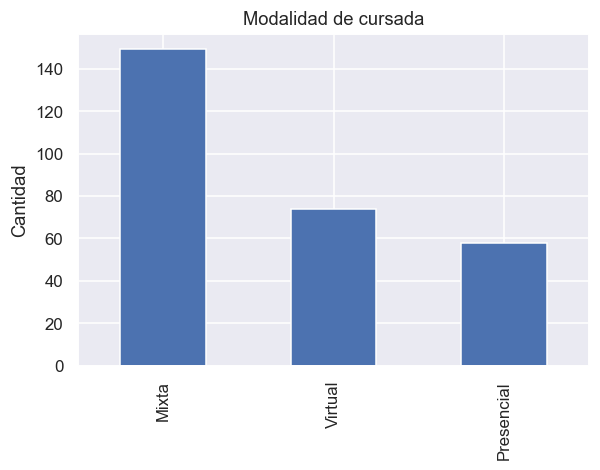

In [22]:
plt.figure(dpi=110)
comp['¿Qué modalidad de cursada tuviste?'].value_counts().plot(kind="bar")
plt.title("Modalidad de cursada")
plt.ylabel("Cantidad")
plt.show()

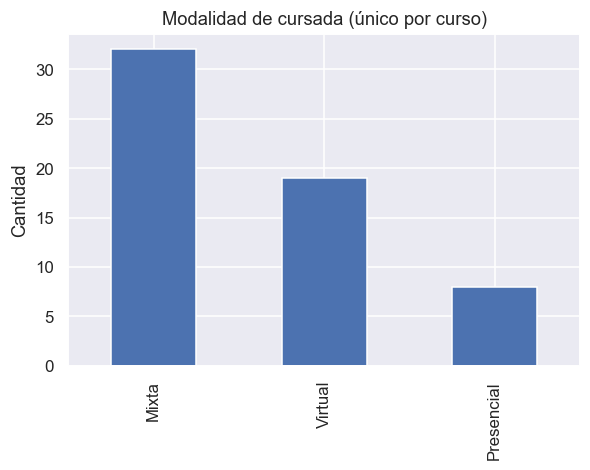

In [23]:
plt.figure(dpi=110)
comp.drop_duplicates(subset=["Elige el curso"])['¿Qué modalidad de cursada tuviste?'].value_counts().plot(kind="bar")
plt.title("Modalidad de cursada (único por curso)")
plt.ylabel("Cantidad")
plt.show()

In [24]:
orden_virtual = ["NC", "No aplica", "Peor", "Similar", "Mejor"]
reemplazos_virtual = {"Si": "Sí"}

columas_virtual = [
 '¿Cómo te parece que serían las clases si fueran virtuales en los siguientes aspectos?  [Clases teóricas]',
 '¿Cómo te parece que serían las clases si fueran virtuales en los siguientes aspectos?  [Clases prácticas]',
 '¿Cómo te parece que serían las clases si fueran virtuales en los siguientes aspectos?  [Trabajos prácticos]',
 '¿Cómo te parece que serían las clases si fueran virtuales en los siguientes aspectos?  [Instancias de consulta]',
 '¿Cómo te parece que serían las clases si fueran virtuales en los siguientes aspectos?  [Tiempos de respuesta ante consultas]',
]

## ¿Cómo te parece que serían las clases si fueran virtuales en los siguientes aspectos?  [Clases teóricas]

### Histograma por respuesta

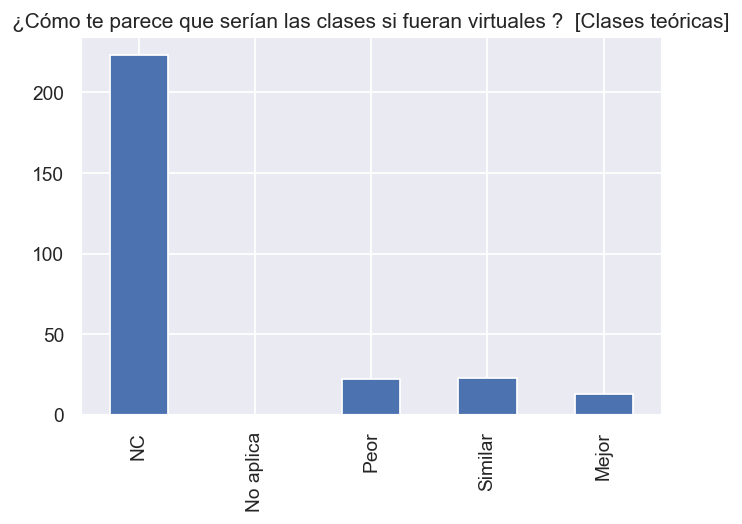

### Respuestas por curso

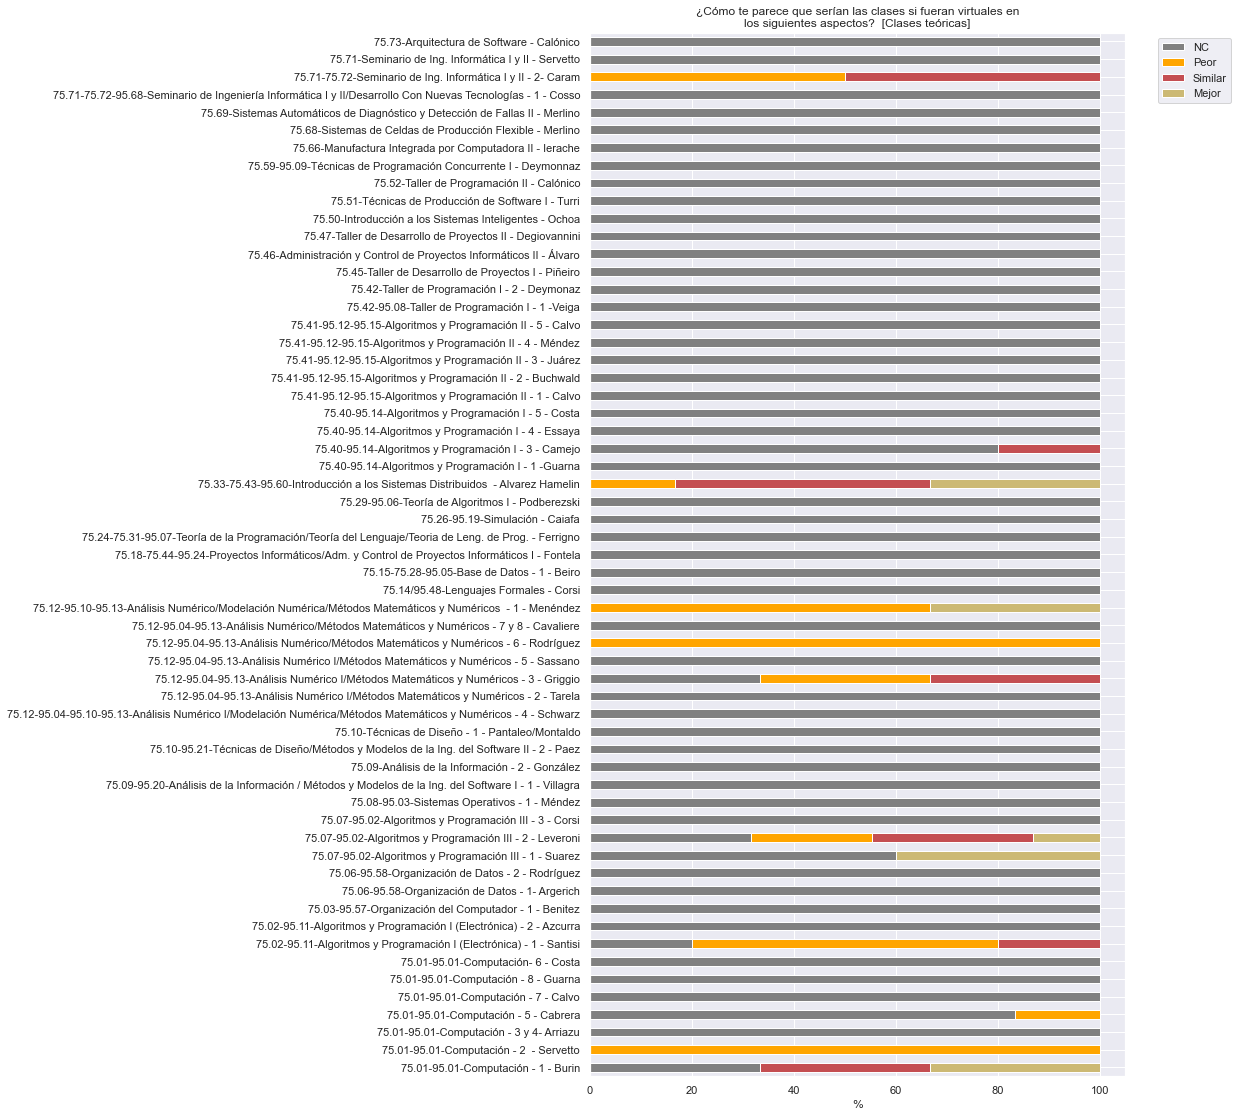

## ¿Cómo te parece que serían las clases si fueran virtuales en los siguientes aspectos?  [Clases prácticas]

### Histograma por respuesta

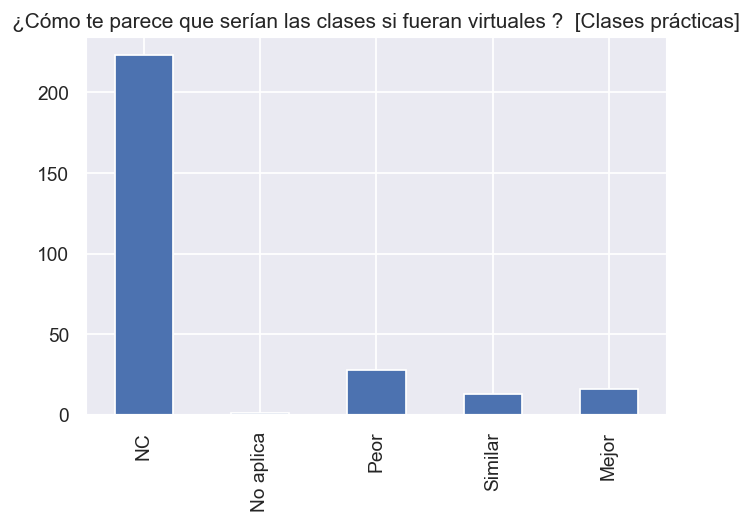

### Respuestas por curso

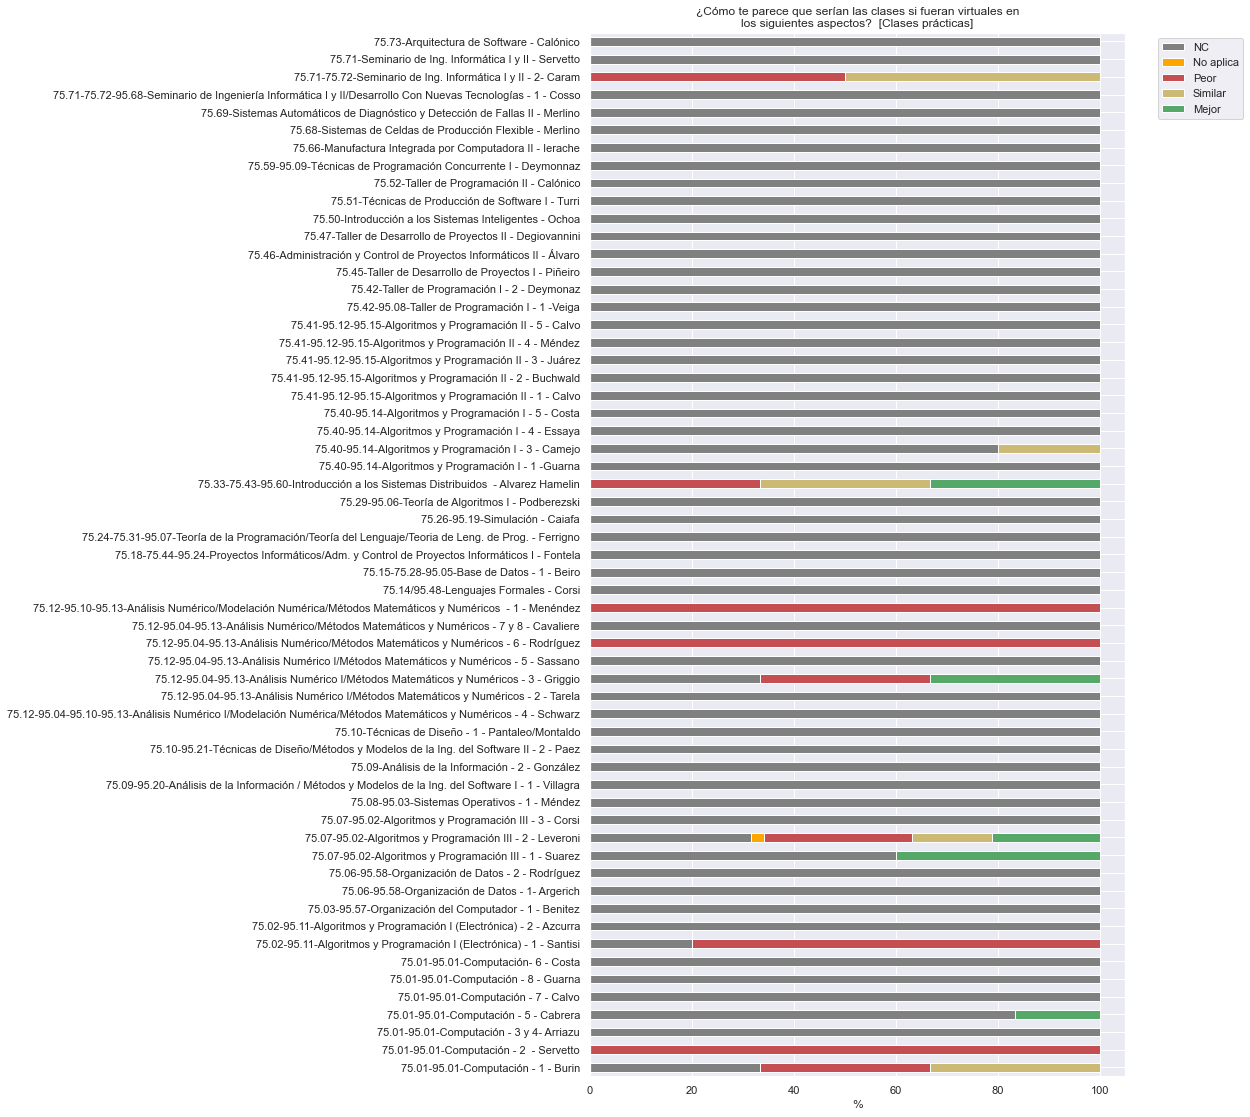

## ¿Cómo te parece que serían las clases si fueran virtuales en los siguientes aspectos?  [Trabajos prácticos]

### Histograma por respuesta

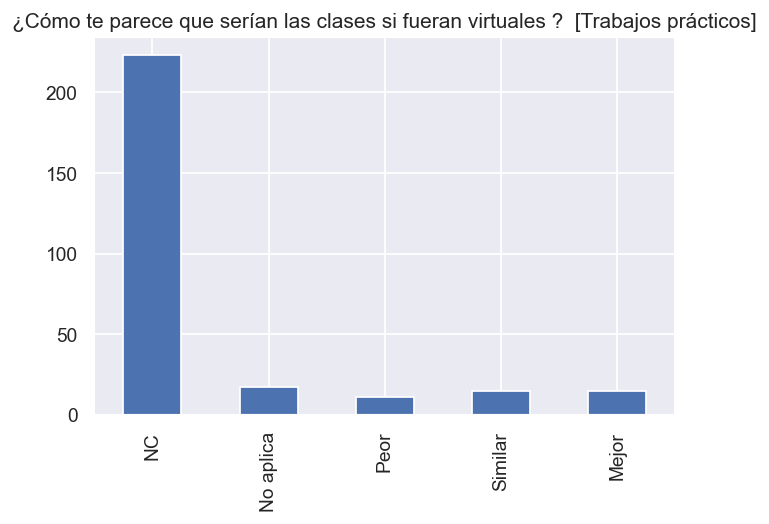

### Respuestas por curso

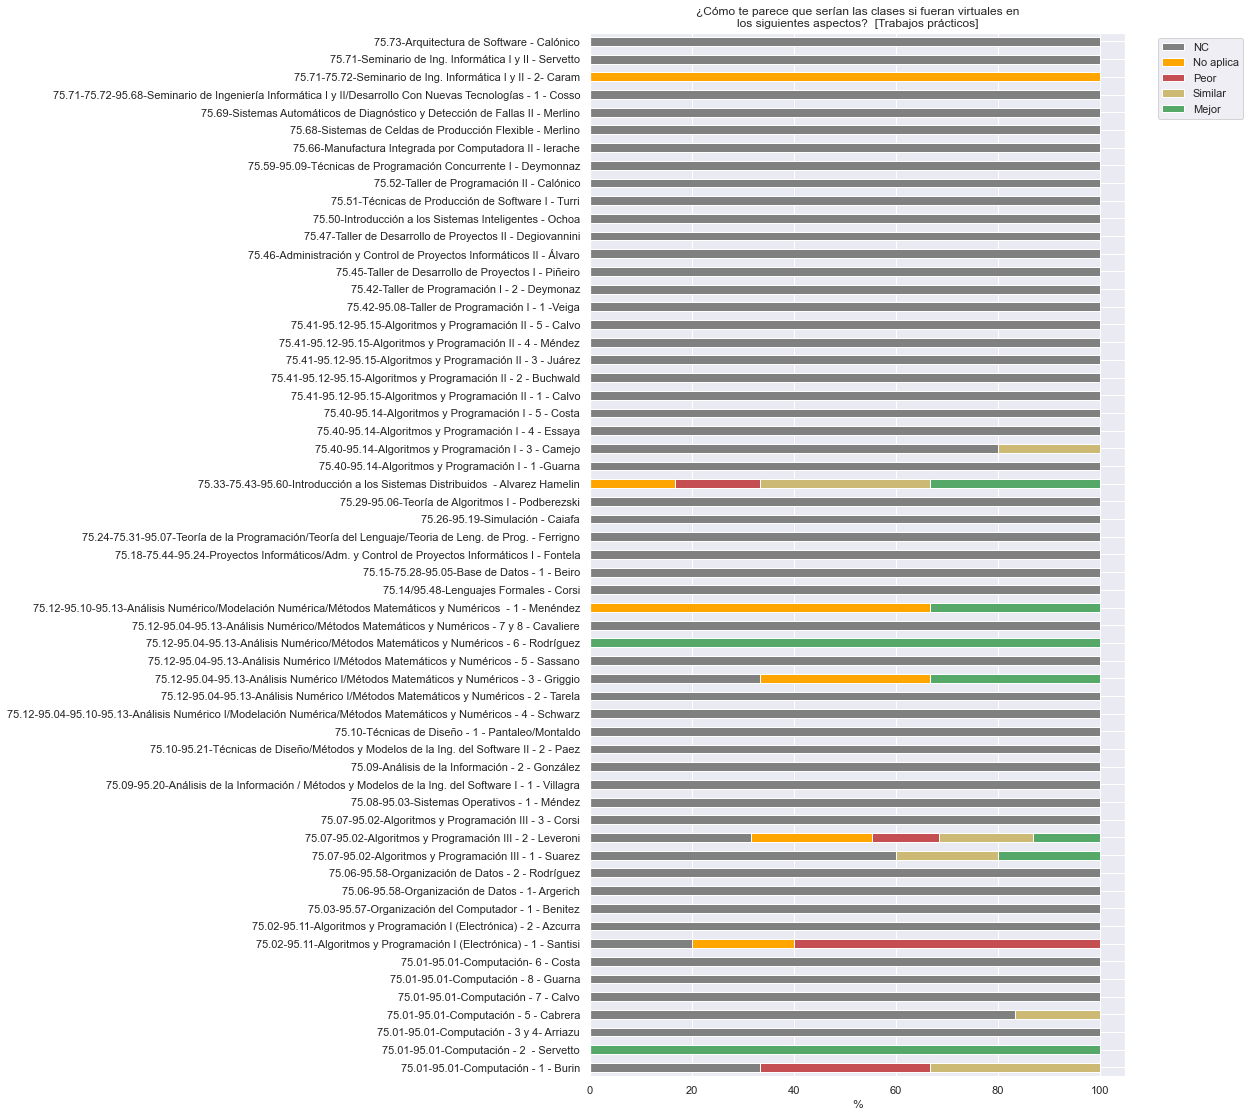

## ¿Cómo te parece que serían las clases si fueran virtuales en los siguientes aspectos?  [Instancias de consulta]

### Histograma por respuesta

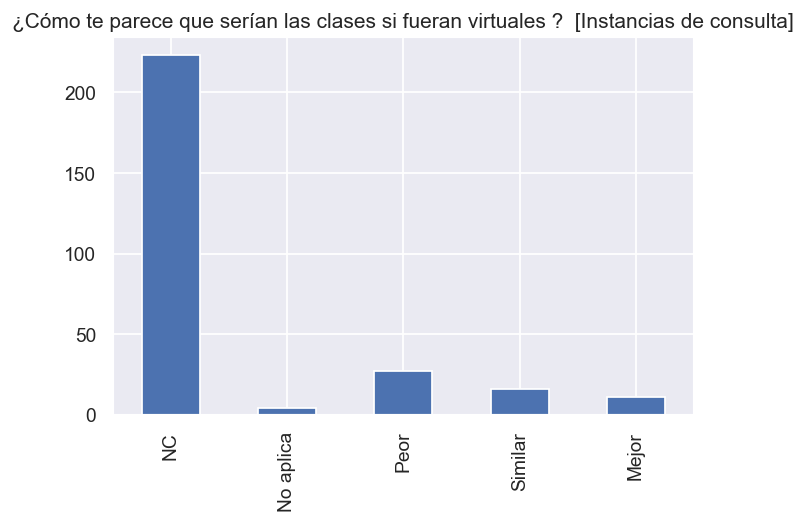

### Respuestas por curso

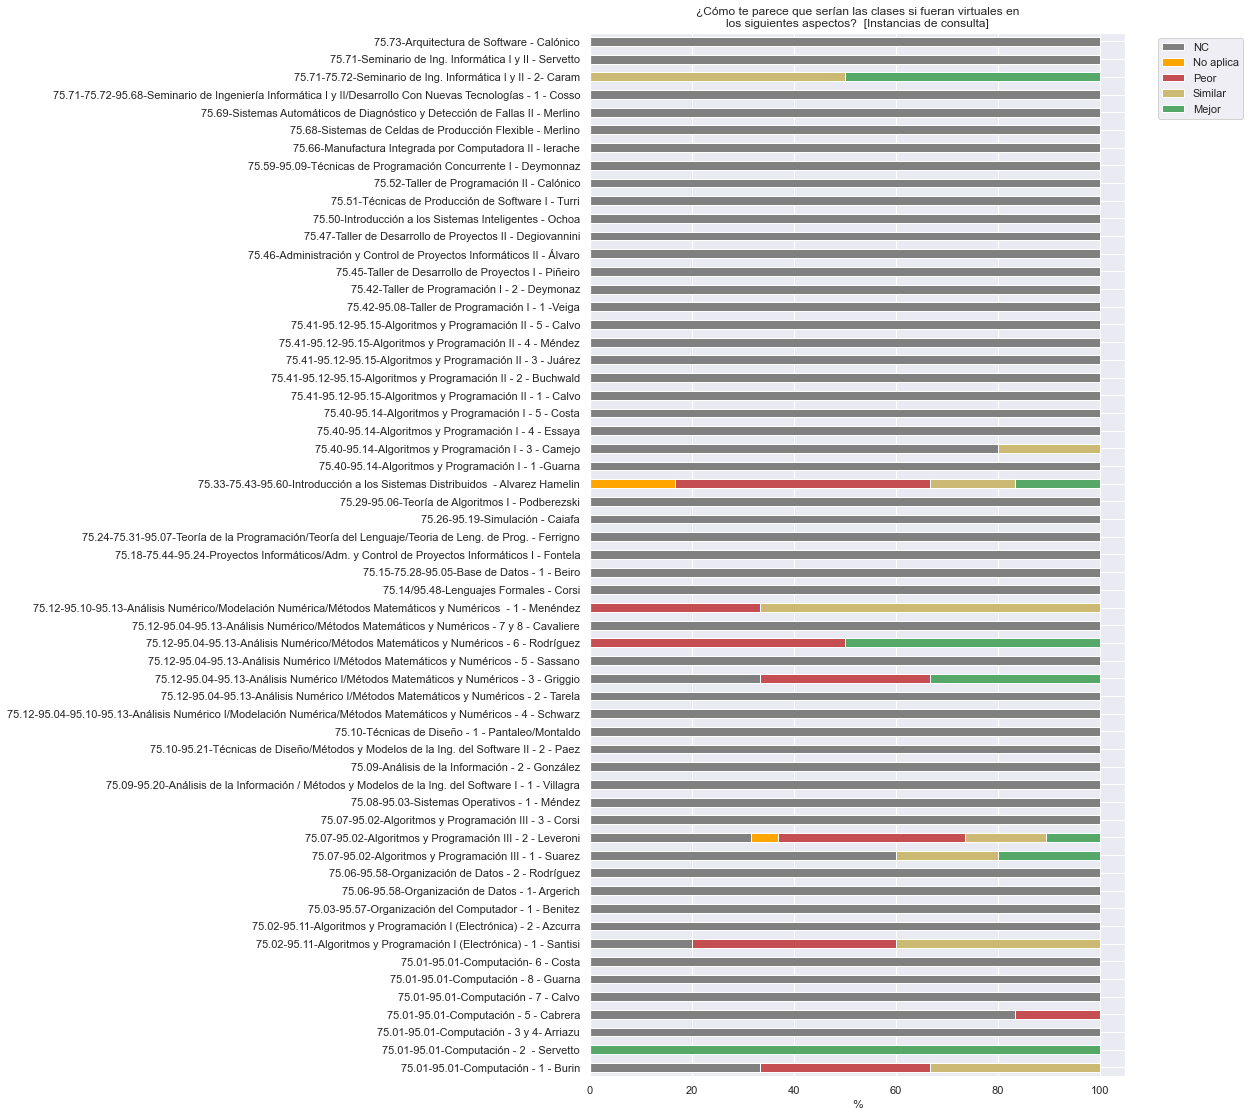

## ¿Cómo te parece que serían las clases si fueran virtuales en los siguientes aspectos?  [Tiempos de respuesta ante consultas]

### Histograma por respuesta

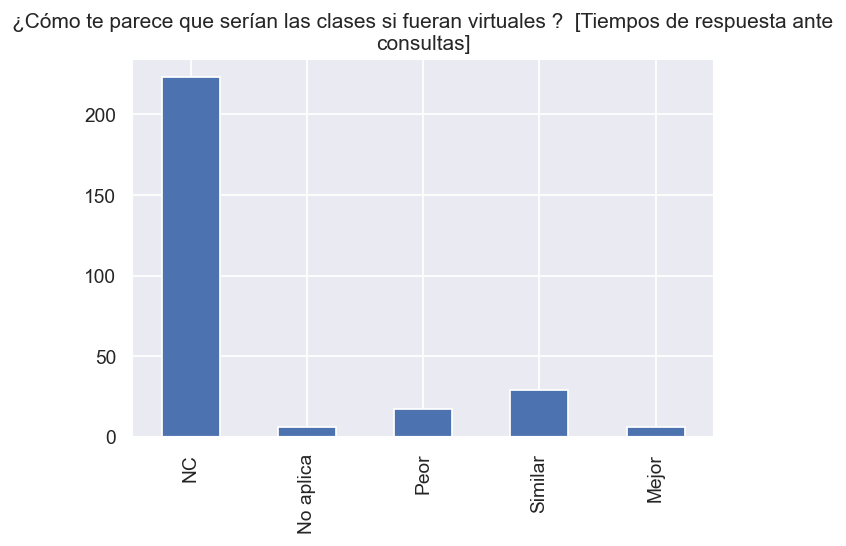

### Respuestas por curso

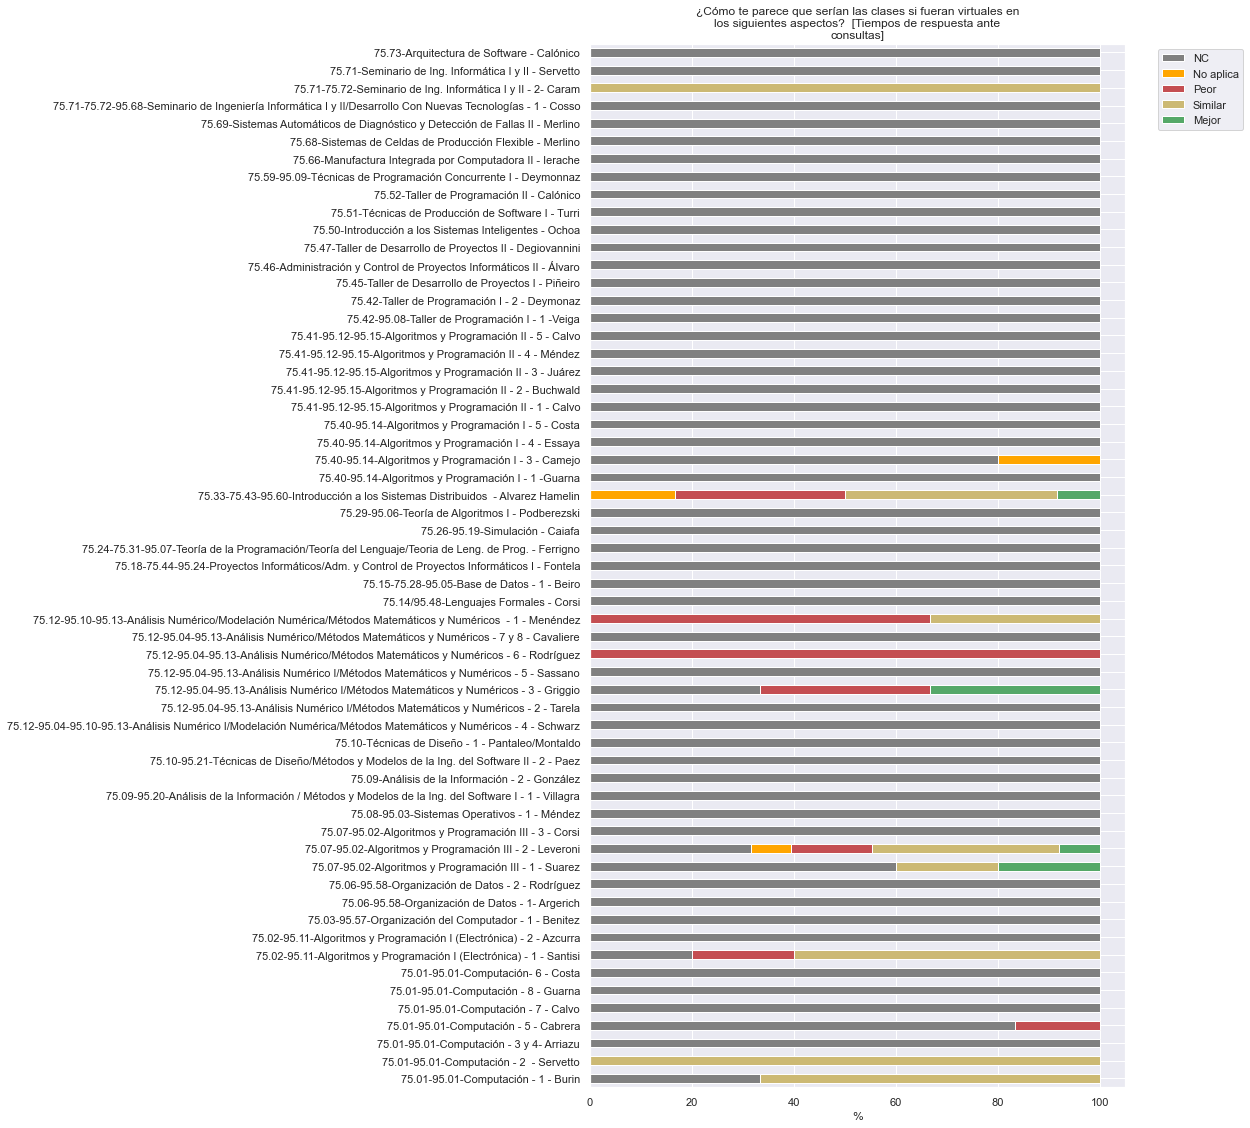

In [25]:
for col in columas_virtual:
    display(Markdown(f"## {col}"))
    display(Markdown(f"### Histograma por respuesta"))
    plt.figure(dpi=125)
    comp[col].replace(reemplazos_virtual, inplace=True)
    comp[col].fillna("NC", inplace=True)
    try:
        _x = comp[col].value_counts()
        for ov in orden_virtual:
            if ov not in _x.index:
                _x[ov] = 0
        _x[orden_virtual].plot(kind="bar")
    except KeyError:
        comp[col].value_counts().plot(kind="bar")
    plt.title(
        "\n".join(wrap(col.replace("en los siguientes aspectos", ""), 88)), wrap=False
    )
    plt.show()

    display(Markdown(f"### Respuestas por curso"))
    newcol = col.replace(
        "¿Cómo te parece que serían las clases si fueran virtuales en los siguientes aspectos?",
        "",
    ).strip(" []")
    agg_col = (
        comp.rename(columns={col: newcol})
        .groupby(["Elige el curso", newcol])
        .size()
        .unstack(fill_value=0)
    )
    try:
        agg_col_pcts = agg_col.div(agg_col.sum(axis=1).values, axis=0).mul(100)
        agg_col_pcts = agg_col_pcts[
            [ov for ov in orden_virtual if ov in agg_col_pcts.columns]
        ]
        ax = agg_col_pcts.sort_index().plot.barh(
            stacked=True,
            figsize=(6.4 * 1.5, 4.8 * 4),
            color=["gray", "orange", "r", "y", "g"],
            title="\n".join(wrap(col, 60)),
            ylabel="%",
            legend=False,
        )
        ax.set_ylabel("")
        ax.set_xlabel("%")
    except KeyError:
        agg_col_pcts = agg_col.div(agg_col.sum(axis=1).values, axis=0).mul(100)[
            ["No", "Sí", "NC"]
        ]
        ax = agg_col_pcts.sort_index().plot.barh(
            stacked=True,
            figsize=(6.4 * 1.5, 4.8 * 4),
            color=["r", "g", "gray"],
            title="\n".join(wrap(col, 60)),
            ylabel="%",
            legend=False,
        )
        ax.set_ylabel("")
        ax.set_xlabel("%")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

## ¿Qué aspectos valorás positivamente de la cursada remota?

Entendemos que estos aspectos no se corresponden con cada cátedra, si no en general.

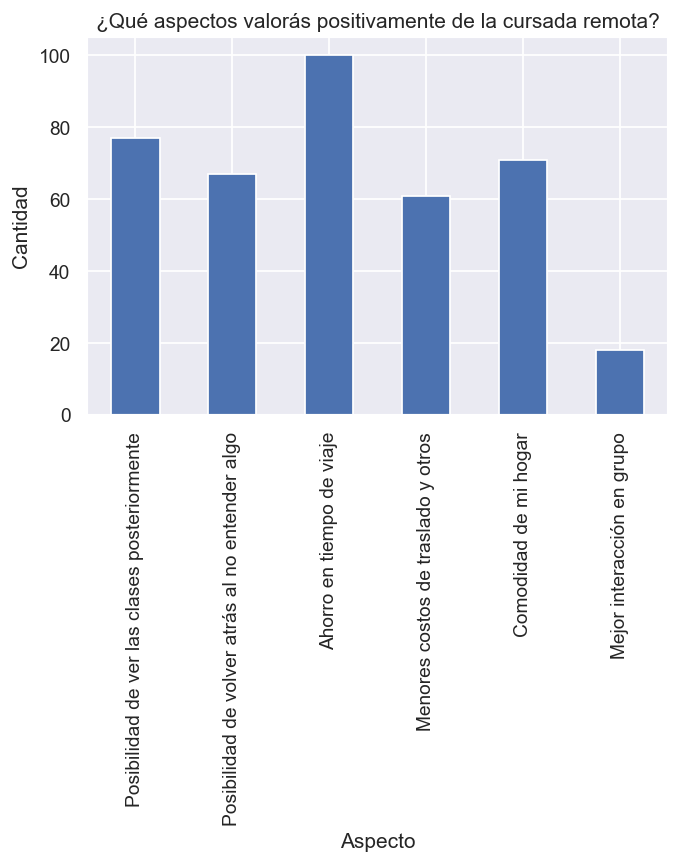

In [26]:
plt.figure(dpi=125)

aspectos = [
    "Posibilidad de ver las clases posteriormente",
    "Posibilidad de volver atrás al no entender algo",
    "Ahorro en tiempo de viaje",
    "Menores costos de traslado y otros",
    "Comodidad de mi hogar",
    "Mejor interacción en grupo",
    "Ahorro en tiempo de viaje",
]

df_aspectos_pos = pd.DataFrame()

column_text = comp[
    "¿Qué aspectos valorás positivamente de la cursada virtual? (elegí todas las que apliquen)"
].dropna()

for aspecto in aspectos:
    df_aspectos_pos[aspecto] = column_text.str.contains(aspecto)

df_aspectos_pos.sum().plot(kind="bar")
plt.ylabel("Cantidad")
plt.xlabel("Aspecto")
plt.title("¿Qué aspectos valorás positivamente de la cursada remota?")
plt.show()

## ¿Qué aspectos valorás negativamente de la cursada remota?

Entendemos que estos aspectos no se corresponden con cada cátedra, si no en general.

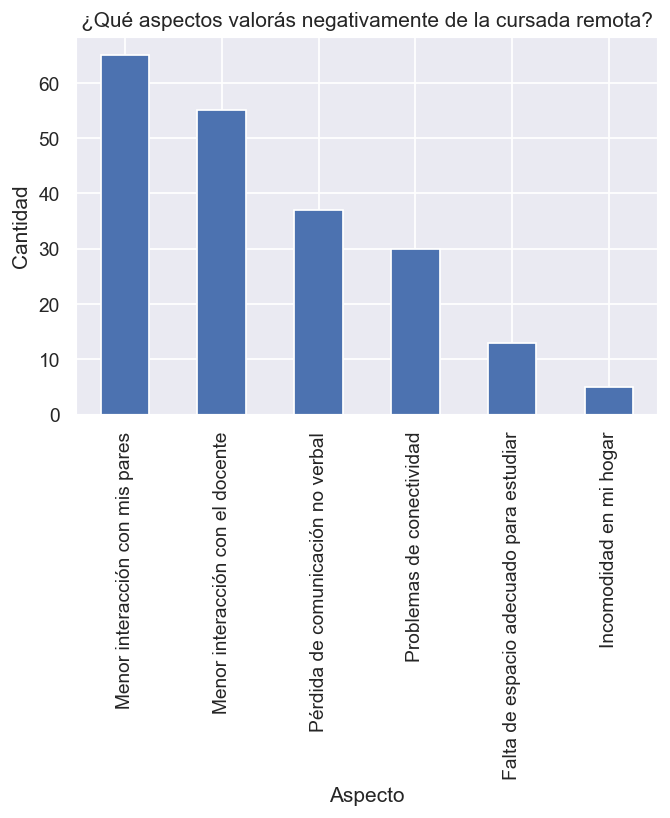

In [27]:
plt.figure(dpi=125)

aspectos = [
    "Menor interacción con mis pares",
    "Menor interacción con el docente",
    "Pérdida de comunicación no verbal",
    "Problemas de conectividad",
    "Falta de espacio adecuado para estudiar",
    "Incomodidad en mi hogar",
]

df_aspectos_neg = pd.DataFrame()

column_text = comp[
    "¿Qué aspectos valorás negativamente de la cursada remota? (elegí todas las que apliquen)"
].dropna()

for aspecto in aspectos:
    df_aspectos_neg[aspecto] = column_text.str.contains(aspecto)

df_aspectos_neg.sum().plot(kind="bar")
plt.ylabel("Cantidad")
plt.xlabel("Aspecto")
plt.title("¿Qué aspectos valorás negativamente de la cursada remota?")
plt.show()

## Correlación entre aspectos positivos y negativos

In [28]:
df_aspectos = (
    df_aspectos_pos.join(df_aspectos_neg, how="outer").fillna(False).astype(int)
)
cooc = df_aspectos.T.dot(df_aspectos)
mask = np.zeros_like(cooc)
mask[np.triu_indices_from(mask)] = True

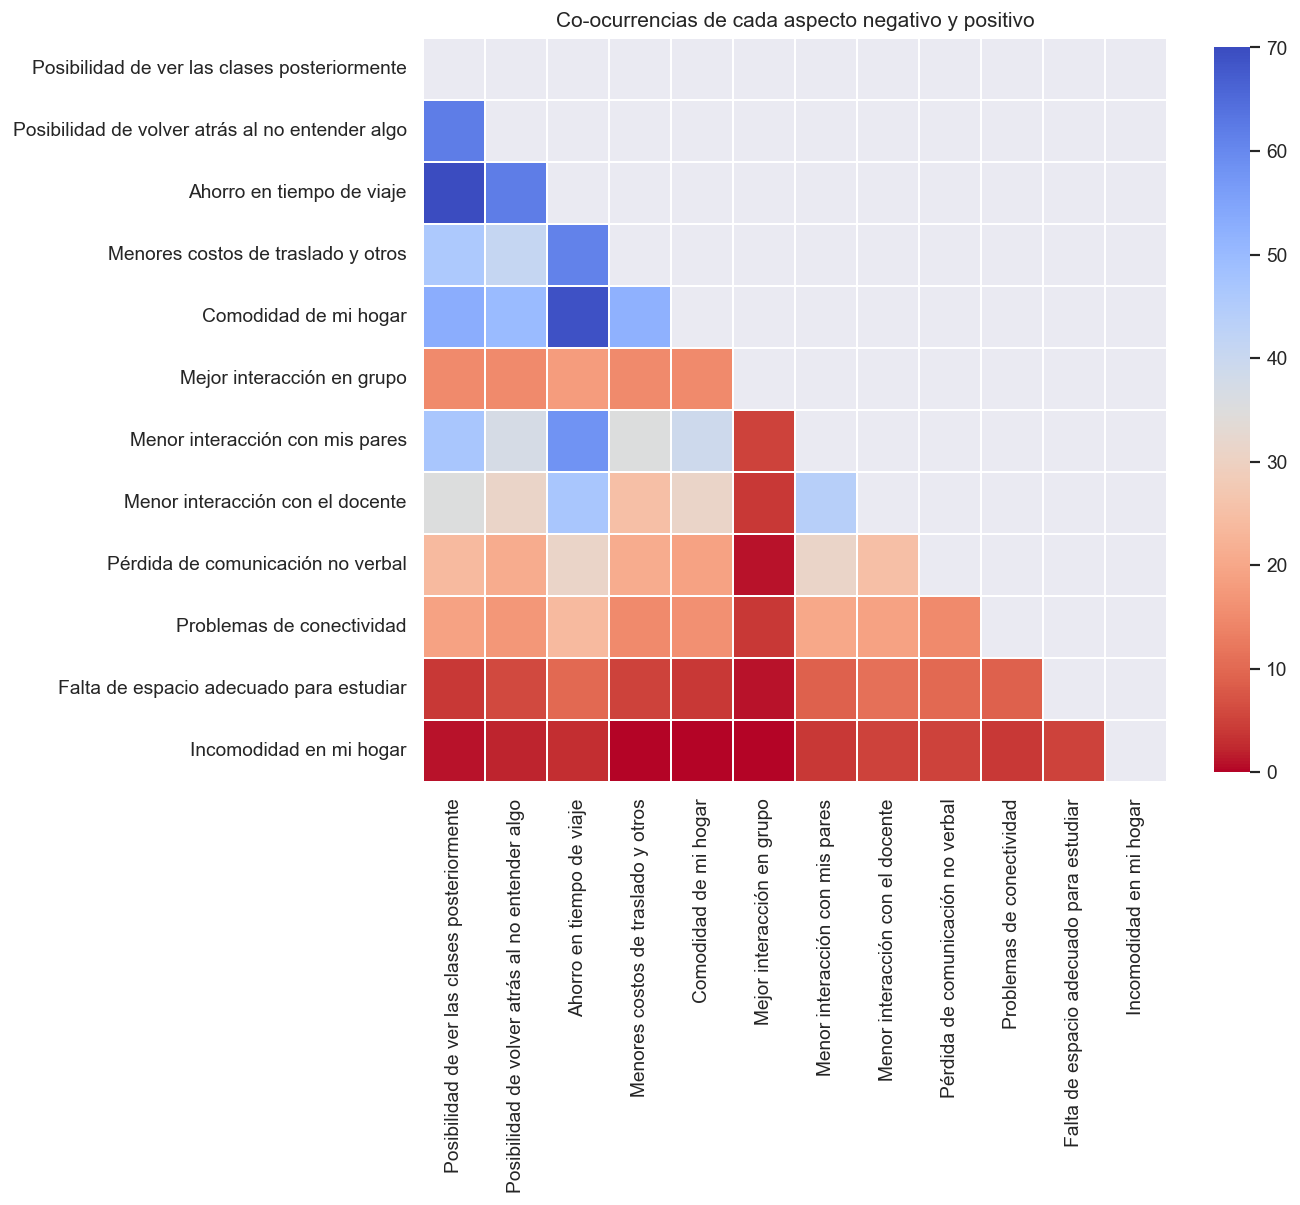

In [29]:
plt.figure(dpi=125, figsize=(6.4 * 1.5, 4.8 * 4))

sns.heatmap(
    data=cooc,
    cmap="coolwarm_r",
    linewidths=0.2,
    square=True,
    cbar_kws={"shrink": 0.4},
    mask=mask,
)
plt.ylabel("")
plt.title("Co-ocurrencias de cada aspecto negativo y positivo")
plt.show()

## ¿Qué aspectos valorás positivamente de la cursada presencial?

Entendemos que estos aspectos no se corresponden con cada cátedra, si no en general.

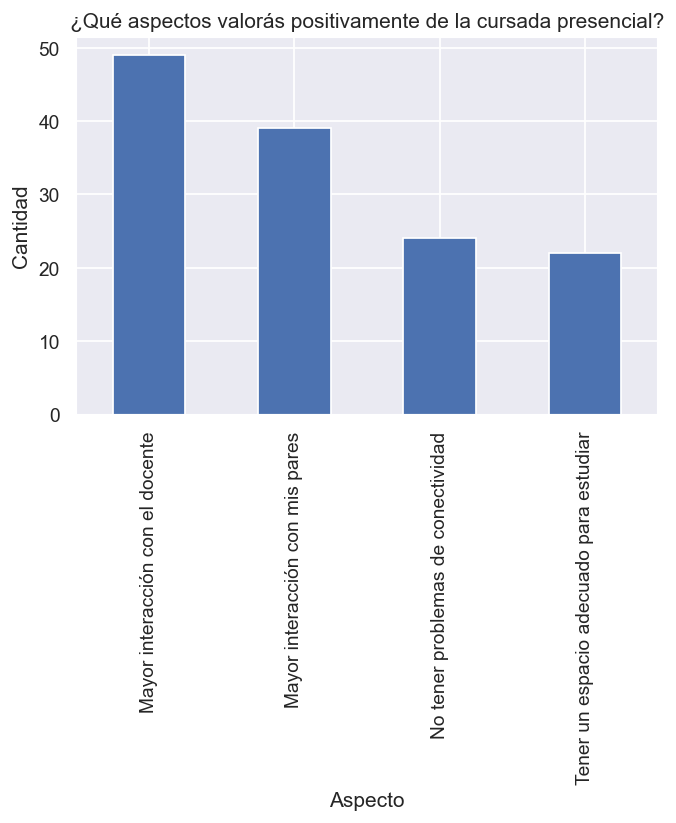

In [30]:
plt.figure(dpi=125)

aspectos = ['Mayor interacción con el docente',
 'Mayor interacción con mis pares',
 'No tener problemas de conectividad',
 'Tener un espacio adecuado para estudiar']

df_aspectos_pos = pd.DataFrame()

column_text = comp[
    "¿Qué aspectos valorás positivamente de la cursada presencial? (elegí todas las que apliquen)"
].dropna()

for aspecto in aspectos:
    df_aspectos_pos[aspecto] = column_text.str.contains(aspecto)

df_aspectos_pos.sum().plot(kind="bar")
plt.ylabel("Cantidad")
plt.xlabel("Aspecto")
plt.title("¿Qué aspectos valorás positivamente de la cursada presencial?")
plt.show()

## ¿Qué aspectos valorás negativamente de la cursada presencial?

Entendemos que estos aspectos no se corresponden con cada cátedra, si no en general.

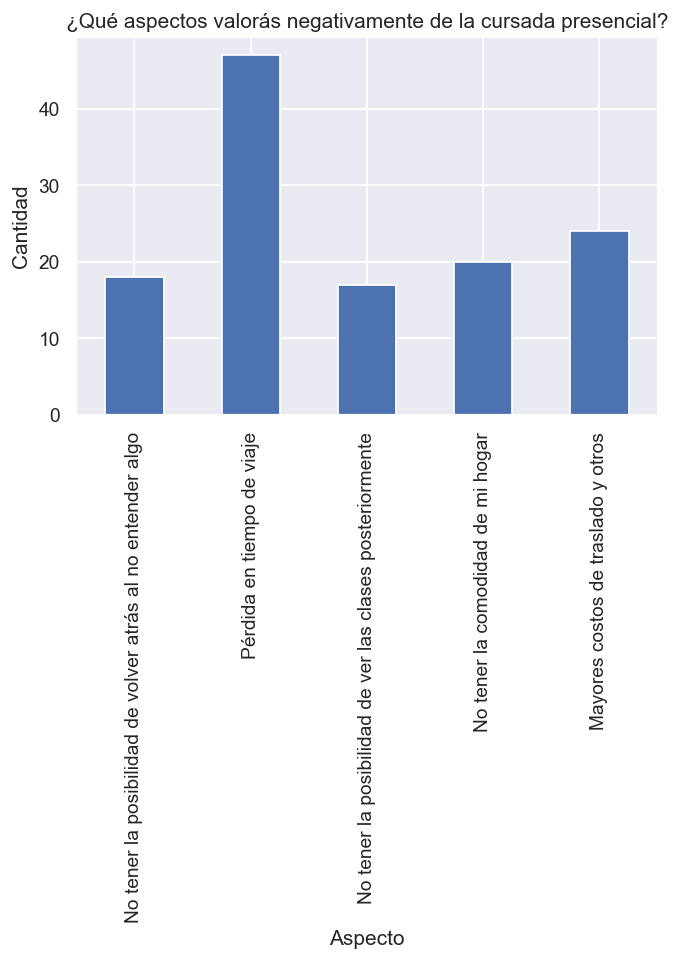

In [31]:
plt.figure(dpi=125)

aspectos = ['No tener la posibilidad de volver atrás al no entender algo',
 'Pérdida en tiempo de viaje',
 'No tener la posibilidad de ver las clases posteriormente',
 'No tener la comodidad de mi hogar',
 'Mayores costos de traslado y otros']

df_aspectos_neg = pd.DataFrame()

column_text = comp[
    "¿Qué aspectos valorás negativamente de la cursada presencial? (elegí todas las que apliquen)"
].dropna()

for aspecto in aspectos:
    df_aspectos_neg[aspecto] = column_text.str.contains(aspecto)

df_aspectos_neg.sum().plot(kind="bar")
plt.ylabel("Cantidad")
plt.xlabel("Aspecto")
plt.title("¿Qué aspectos valorás negativamente de la cursada presencial?")
plt.show()

## Correlación entre aspectos positivos y negativos

In [32]:
df_aspectos = (
    df_aspectos_pos.join(df_aspectos_neg, how="outer").fillna(False).astype(int)
)
cooc = df_aspectos.T.dot(df_aspectos)
mask = np.zeros_like(cooc)
mask[np.triu_indices_from(mask)] = True

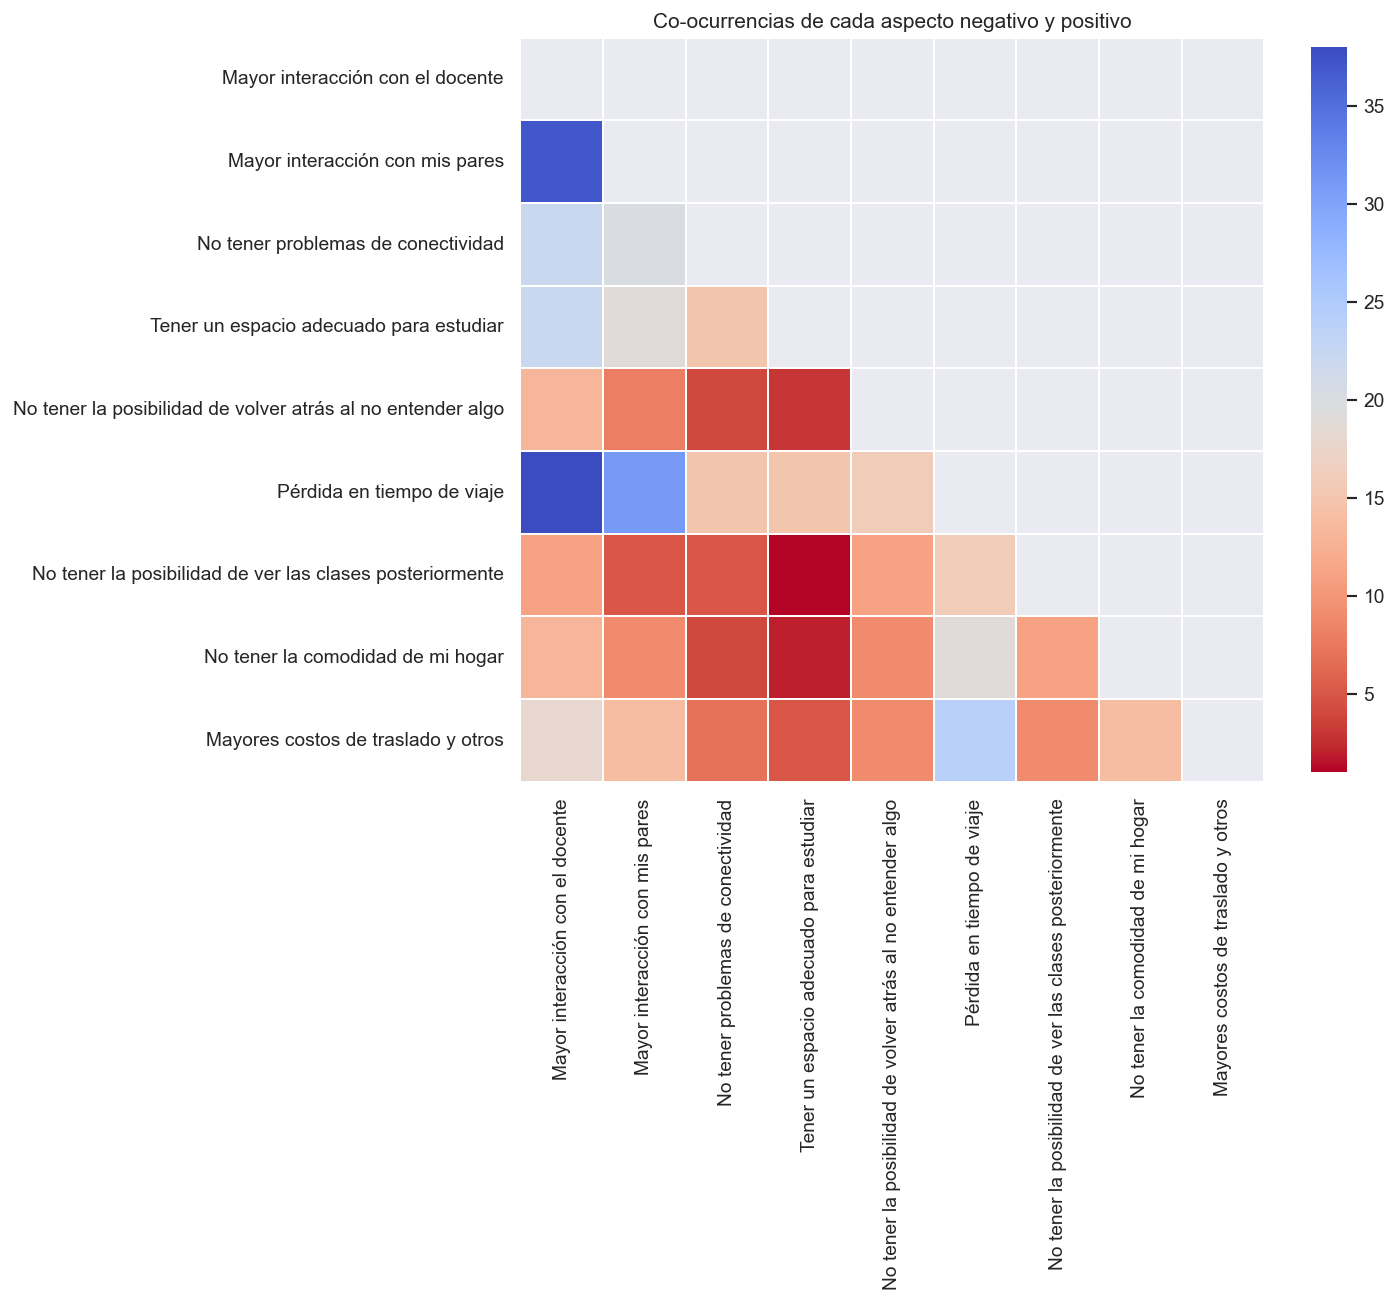

In [33]:
plt.figure(dpi=125, figsize=(6.4 * 1.5, 4.8 * 4))

sns.heatmap(
    data=cooc,
    cmap="coolwarm_r",
    linewidths=0.2,
    square=True,
    cbar_kws={"shrink": 0.4},
    mask=mask,
)
plt.ylabel("")
plt.title("Co-ocurrencias de cada aspecto negativo y positivo")
plt.show()

# ¿Creés que la cátedra estuvo a la altura de una cursada virtual? En cuanto a herramientas, comunicación, material, etc

In [34]:
def procesar_comentario(c):
    try:
        lineas = c.split("\n")
    except:
        print(c)
        raise
    return "\n".join([f"{l}" for l in lineas])


for curso in sorted(comp["Elige el curso"].unique()):
    display(Markdown(f"## Curso {curso}"))
    com = comp[comp["Elige el curso"] == curso][
        "¿Creés que la cátedra estuvo a la altura de una cursada virtual? En cuanto a herramientas, comunicación, material, etc"
    ].dropna()
    if com.empty:
        display(Markdown("_No hay comentarios_"))
    else:
        todos_los_comentarios = com.str.capitalize().value_counts().to_dict()
        for comentario, count in todos_los_comentarios.items():
            try:
                if comentario == "":
                    continue
                count_suffix = ""
                if count > 1:
                    count_suffix = f"**({count} comentarios idénticos)**"
                display(
                    Markdown(f"- {procesar_comentario(comentario)} {count_suffix}\n\n")
                )
            except:
                # print(todos_los_comentarios, curso)
                raise

## Curso 75.01-95.01-Computación - 1 - Burin

- Si 



## Curso 75.01-95.01-Computación - 2  - Servetto

_No hay comentarios_

## Curso 75.01-95.01-Computación - 3 y 4- Arriazu

- 100%, las clases muy organizadas con mucho material que era subido previamente al campus para poder hacer una lectura antes de entrar a clase. 



## Curso 75.01-95.01-Computación - 5 - Cabrera

_No hay comentarios_

## Curso 75.01-95.01-Computación - 7 - Calvo

_No hay comentarios_

## Curso 75.01-95.01-Computación - 8 - Guarna

_No hay comentarios_

## Curso 75.01-95.01-Computación- 6 - Costa

- Totalmente 



- Más o menos. les falta contestar cuando se les envían consultas 



## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 1 - Santisi

- Tuvimos 2 o 3 clases virtuales muy bien dadás por el docente. no fue una cursada virtual.  



- Si  



## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 2 - Azcurra

- La cursada es perfecta. 



## Curso 75.03-95.57-Organización del Computador - 1 - Benitez

- Si 



- La verdad que no, los textos tienen mucho relleno y son realmente dificiles de leer. en cuanto a programar faltan mas ejemplos para poder realizar un tp y una evaluacion tan complejos. 



- Sí. 



## Curso 75.06-95.58-Organización de Datos - 1- Argerich

- Si **(4 comentarios idénticos)**



- Sí, siempre hubo excelente material a nuestra disposición de todos los temas, además de los videos teóricos y las clases prácticas. y siempre contestan rápido en slack, tanto en los hilos generales como los correctores. 



- La cursada de esta materia es virtual, seria un completo desperdicio hacer este tipo de clases prescenciales 



- Sí. 



- Si, la página con todas las clases es buena. 



- Estuvo a la altura y las herramientas que se usan son claras y simples de usar. la comunicación por slack es excelente porque los ayudantes están constantemente resolviendo dudas.  



- Sí, excelente 



- 10/10 



- Totalmente, están perfectamente adecuados 



- Si, fue muy bueno. grupo de slack muy activo, muy buenos tiempos de respuesta. calendario de clases claro y actualizado. muy buena disponibilidad por parte de todo el cuerpo docente a la hora de resolver dudas y/o consultas.  



- Estuvo a la altura. la organización de la materia estuvo bien explicada desde un principio y los contenidos fueron presentados de forma organizada y en tiempo y forma. 



- Obvio, la mejor adaptada 



- Obvio 



- Si, estuvo a la altura, muy buena catedra!. pero si tengo que elegir, prefiero la presencialidad, por los otros aspectos no tan vinculados con el aprendizaje. 



- Sí, en general aprovechan muy bien las ventajas que otorga la virtualidad. 



- Me parece que sí. 
las clases fueron todas grabadas y subidas, por lo que las podíamos revisar luego.
teníamos que ver videos teóricos antes de cada clase, los cuales estaban subidos a youtube. 



## Curso 75.06-95.58-Organización de Datos - 2 - Rodríguez

- Si, aunque para el tp2 senti que faltó un poco de clases prácticas  



- Si. sentí que faltó material teorico pero eso aplicaria tambien a una cursada presencial 



- Absolutamente 



## Curso 75.07-95.02-Algoritmos y Programación III - 1 - Suarez

- Si 



## Curso 75.07-95.02-Algoritmos y Programación III - 2 - Leveroni

- Si **(6 comentarios idénticos)**



- No fue virtual. solo las ultimas dos semanas por el problema edilicio de nuestra facultad. 



- Si, pese a no tener planeado la virtualidad, se adaptaron perfectamente a ella. 



- Si, aunque fue en su mayoría presencial 



- Si, totalmente. 



- Si, no hubo ningun problema 



- Si, se las arreglaron hasta para grabar las clases presenciales, después en el discord daban ayuda por canales de voz de discord lo cual es muy util 



- Si, incluso es más fácil para los docentes subir las clases grabadas lo cual ayuda muchísimo además de que las clases pueden comenzar puntualmente y terminar de forma más cómoda 



- Si, cuentan un grupo de discord donde estan siempre activos respondiendo dudas y siempre graban sus clases.  



## Curso 75.07-95.02-Algoritmos y Programación III - 3 - Corsi

- Si, totalmente 



- Si, el material sirvió mucho y slack y github resultaron buenos medios de comunicación con los docentes. 



## Curso 75.08-95.03-Sistemas Operativos - 1 - Méndez

_No hay comentarios_

## Curso 75.09-95.20-Análisis de la Información / Métodos y Modelos de la Ing. del Software I - 1 - Villagra

- Sí 



- Si 



- Ninguna queja 



## Curso 75.09-Análisis de la Información - 2 - González

- Si 



- Sí 



- Si, enviaban el material a utilizar en la clase con tiempo para poder tenerlo a la hora de la clase 



## Curso 75.10-95.21-Técnicas de Diseño/Métodos y Modelos de la Ing. del Software II - 2 - Paez

_No hay comentarios_

## Curso 75.10-Técnicas de Diseño - 1 - Pantaleo/Montaldo

_No hay comentarios_

## Curso 75.12-95.04-95.10-95.13-Análisis Numérico I/Modelación Numérica/Métodos Matemáticos y Numéricos - 4 - Schwarz

_No hay comentarios_

## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 2 - Tarela

_No hay comentarios_

## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 3 - Griggio

- No 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 5 - Sassano

_No hay comentarios_

## Curso 75.12-95.04-95.13-Análisis Numérico/Métodos Matemáticos y Numéricos - 6 - Rodríguez

- No, en general la catedra no esta a la altura de nada 



- No fue virtual 



## Curso 75.12-95.04-95.13-Análisis Numérico/Métodos Matemáticos y Numéricos - 7 y 8 - Cavaliere

- No, catedra muy desactualizada. el campus casi sin pdfs teoricos. solo guias de trabajo y algun que otro ejercicio. 



## Curso 75.12-95.10-95.13-Análisis Numérico/Modelación Numérica/Métodos Matemáticos y Numéricos  - 1 - Menéndez

_No hay comentarios_

## Curso 75.14/95.48-Lenguajes Formales - Corsi

- Si, cumplieron horarios, tenian muy buen material. 



- Sí 



## Curso 75.15-75.28-95.05-Base de Datos - 1 - Beiro

_No hay comentarios_

## Curso 75.18-75.44-95.24-Proyectos Informáticos/Adm. y Control de Proyectos Informáticos I - Fontela

_No hay comentarios_

## Curso 75.24-75.31-95.07-Teoría de la Programación/Teoría del Lenguaje/Teoria de Leng. de Prog. - Ferrigno

- Absolutamente 



## Curso 75.26-95.19-Simulación - Caiafa

- Todo excelente, la única crítica la haría a la comunicación fuera de horario de clase. si bien el campus cumple con la funcionalidad de comunicación entre docente y alumno, muchas veces el campus notifica mucho tiempo después o a veces ni siquiera notifica. con lo que dificulta la comunicación asincronica. en muchas materias se utiliza slack, esta bueno porque incluso fomenta a la interacción entre alumnos respondiéndose entre ellos. 



## Curso 75.29-95.06-Teoría de Algoritmos I - Podberezski

_No hay comentarios_

## Curso 75.33-75.43-95.60-Introducción a los Sistemas Distribuidos  - Alvarez Hamelin

- Hay consultas de slack que nunca se responden. 



- No fue virtual 



- No aplica, la cursada fue 100% presencial salvo por las ultimas 2 semanas que fueron virtuales por los problemas en paseo colon. 



- No 



## Curso 75.40-95.14-Algoritmos y Programación I - 1 -Guarna

_No hay comentarios_

## Curso 75.40-95.14-Algoritmos y Programación I - 3 - Camejo

- Si 



## Curso 75.40-95.14-Algoritmos y Programación I - 4 - Essaya

_No hay comentarios_

## Curso 75.40-95.14-Algoritmos y Programación I - 5 - Costa

- Totalmente, la cátedra se manejo con excelencia  



- Faltaban mas ejercicios para practicar 



- Si, siempre 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 1 - Calvo

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 2 - Buchwald

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 3 - Juárez

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 4 - Méndez

- Si **(2 comentarios idénticos)**



- El ida y vuelta entre los ayudantes por discord estuvo perfecto, respondiendo dudas rápidamente, además de tener asignado un colaborador especifico ayudó mucho 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 5 - Calvo

_No hay comentarios_

## Curso 75.42-95.08-Taller de Programación I - 1 -Veiga

_No hay comentarios_

## Curso 75.42-Taller de Programación I - 2 - Deymonaz

- Si **(3 comentarios idénticos)**



- Completamente  



- Sí 



## Curso 75.45-Taller de Desarrollo de Proyectos I - Piñeiro

_No hay comentarios_

## Curso 75.46-Administración y Control de Proyectos Informáticos II - Álvaro

- No había campus, solo comunicación esporádica via mail por parte del equipo docente. algunas clases se terminaban cancelando a último momento y en otras semanas no tuvimos novedad, aviso, ni clase alguna.
bibliografía/links ofrecidos fueron muy poco relevantes a cada entrega que se correspondía hacer. 



## Curso 75.47-Taller de Desarrollo de Proyectos II - Degiovannini

- Si 



## Curso 75.50-Introducción a los Sistemas Inteligentes - Ochoa

- Si 



## Curso 75.51-Técnicas de Producción de Software I - Turri

- Si 



## Curso 75.52-Taller de Programación II - Calónico

- Si, un poco de mejor organización falto, pero bien  



## Curso 75.59-95.09-Técnicas de Programación Concurrente I - Deymonnaz

- Si 



- Si, se utilizó discord para la comunicación con los alumnos y para publicar las clases grabadas 



- Las clases eran virtuales pero las teóricas o no se grababan o se grababan pero no se publicaban entonces no podías verla grabada. en cuanto a material, un par de teóricas fueron insuficientes, entonces leí el ben-ari que proponen y me resultó insuficiente también. 



## Curso 75.66-Manufactura Integrada por Computadora II - Ierache

_No hay comentarios_

## Curso 75.68-Sistemas de Celdas de Producción Flexible - Merlino

- No tendría sentido que fuera presencial. 



- Si 



## Curso 75.69-Sistemas Automáticos de Diagnóstico y Detección de Fallas II - Merlino

- Si 



## Curso 75.71-75.72-95.68-Seminario de Ingeniería Informática I y II/Desarrollo Con Nuevas Tecnologías - 1 - Cosso

_No hay comentarios_

## Curso 75.71-75.72-Seminario de Ing. Informática I y II - 2- Caram

_No hay comentarios_

## Curso 75.71-Seminario de Ing. Informática I y II - Servetto

_No hay comentarios_

## Curso 75.73-Arquitectura de Software - Calónico

- Si 



- Completamente, clases claras que lo mejor es participar del día y vuelta que buscan generar. 



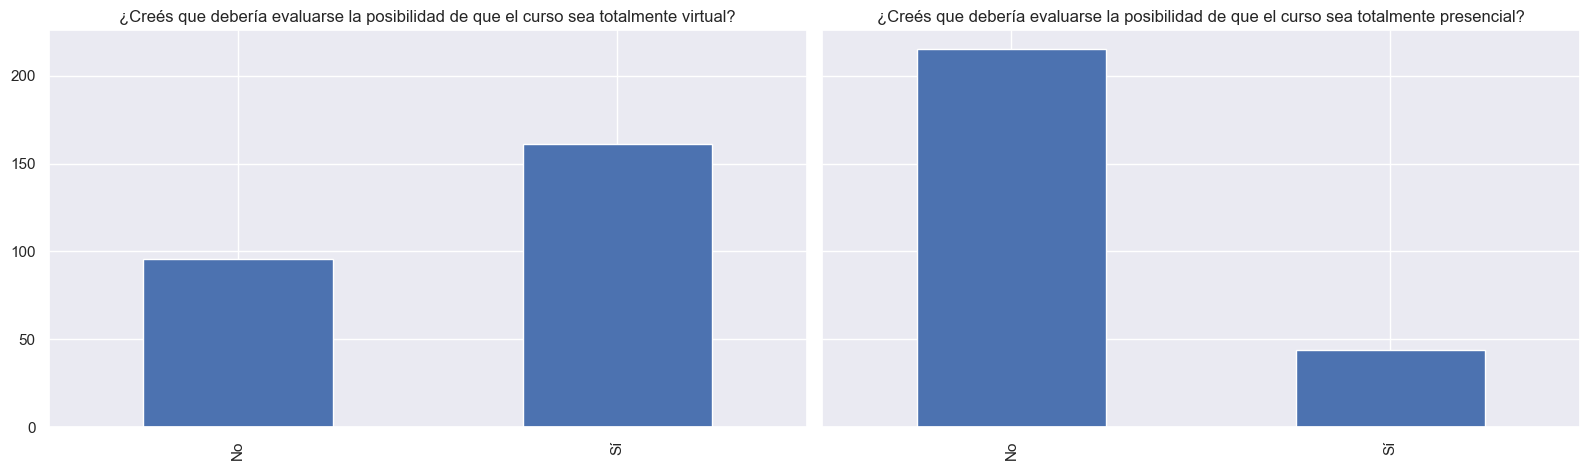

In [35]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6.4 * 2.5, 4.8), dpi=100, sharey=True)

comp[
    "¿Creés que debería evaluarse la posibilidad de que el curso sea totalmente virtual?"
].replace({"Si": "Sí"}, inplace=True)

(
    comp[
        "¿Creés que debería evaluarse la posibilidad de que el curso sea totalmente virtual?"
    ]
    .value_counts()
    .sort_index()
    .plot(
        kind="bar",
        title="""¿Creés que debería evaluarse la posibilidad de que el curso sea totalmente virtual?""",
        ax=ax1
    )
)

comp[
    "¿Creés que debería evaluarse la posibilidad de que el curso sea totalmente presencial?"
].replace({"Si": "Sí"}, inplace=True)

(
    comp[
        "¿Creés que debería evaluarse la posibilidad de que el curso sea totalmente presencial?"
    ]
    .value_counts()
    .sort_index()
    .plot(
        kind="bar",
        title="""¿Creés que debería evaluarse la posibilidad de que el curso sea totalmente presencial?""",
        ax=ax2
    )
)

plt.tight_layout()

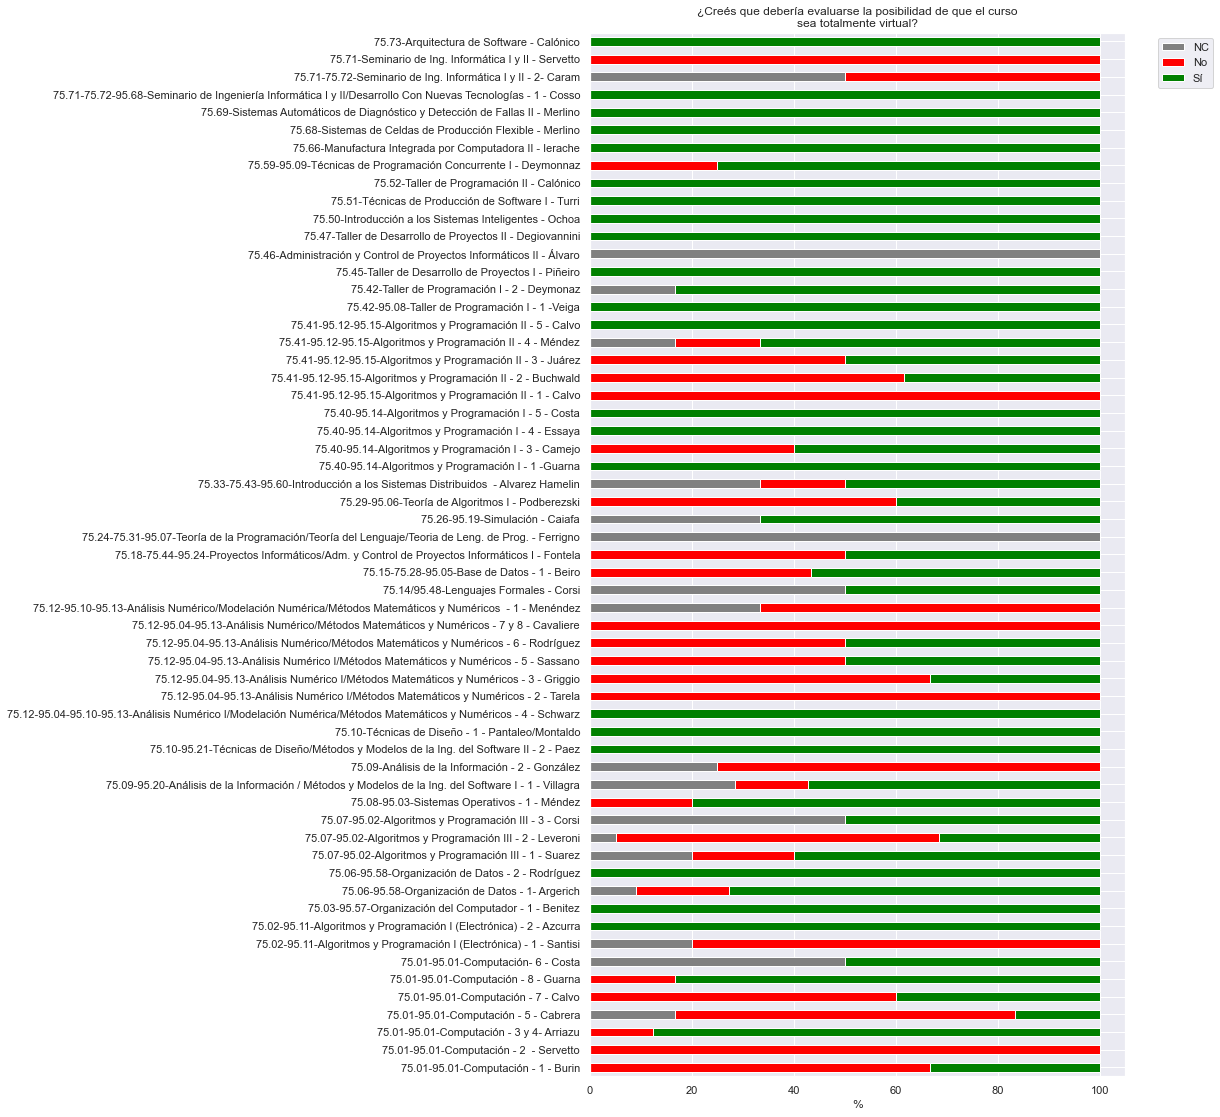

In [36]:
agg = (
    comp.fillna(
        {
            "¿Creés que debería evaluarse la posibilidad de que el curso sea totalmente virtual?": "NC"
        }
    )
    .groupby("Elige el curso")[
        "¿Creés que debería evaluarse la posibilidad de que el curso sea totalmente virtual?"
    ]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .mul(100)
)

ax = agg.sort_index().plot.barh(
    stacked=True,
    figsize=(6.4 * 1.5, 4.8 * 4),
    color=["gray", "red", "green"],
    title="\n".join(
        wrap(
            "¿Creés que debería evaluarse la posibilidad de que el curso sea totalmente virtual?",
            60,
        )
    ),
    ylabel="%",
    legend=False,
)

ax.set_ylabel("")
ax.set_xlabel("%")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

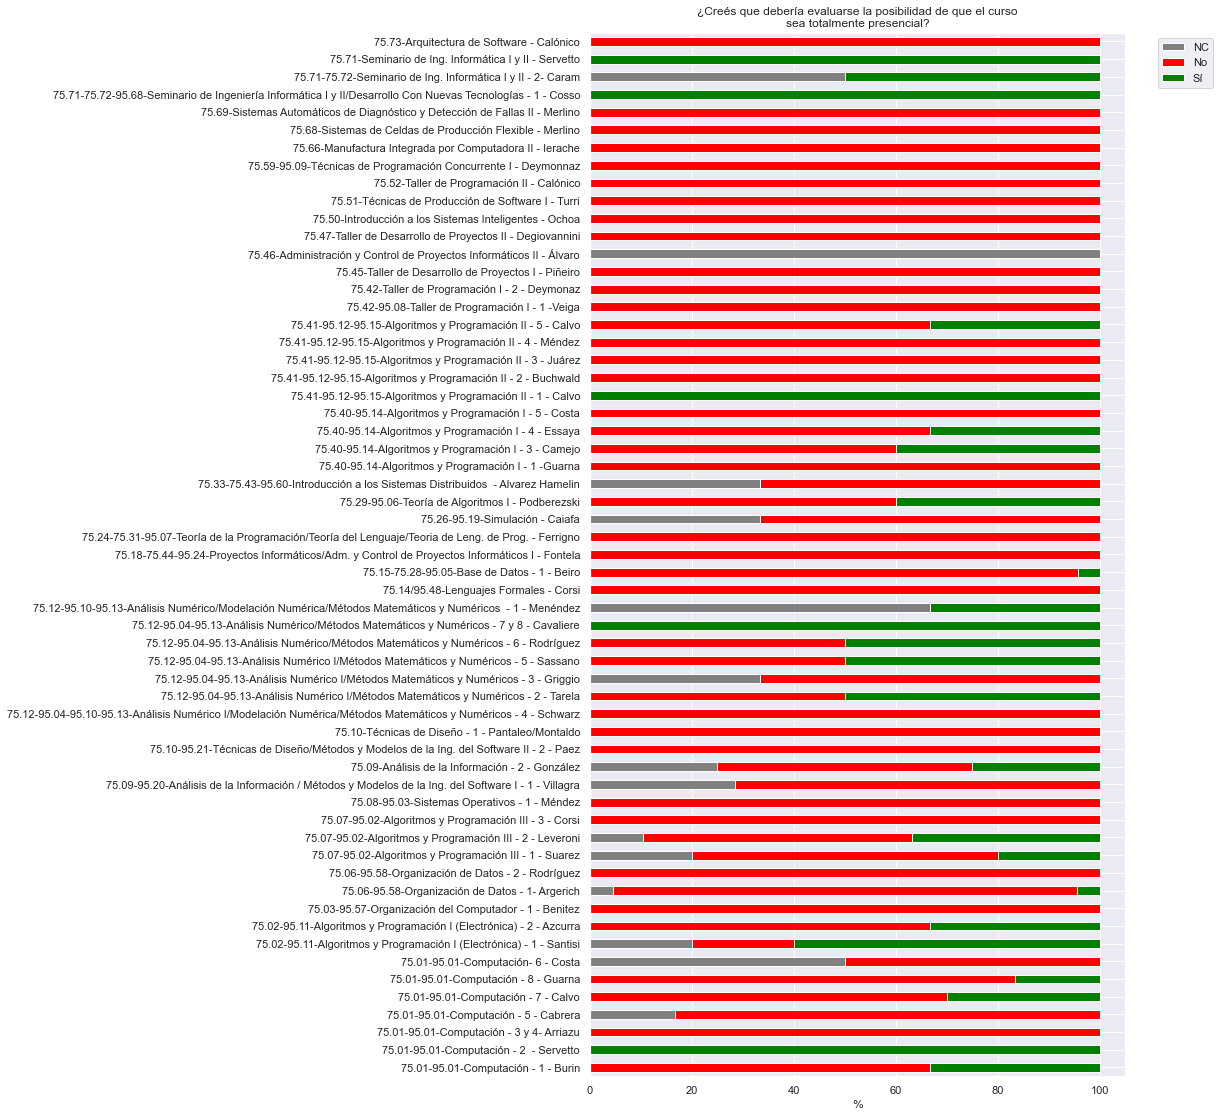

In [37]:
agg = (
    comp.fillna(
        {
            "¿Creés que debería evaluarse la posibilidad de que el curso sea totalmente presencial?": "NC"
        }
    )
    .groupby("Elige el curso")[
        "¿Creés que debería evaluarse la posibilidad de que el curso sea totalmente presencial?"
    ]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .mul(100)
)

ax = agg.sort_index().plot.barh(
    stacked=True,
    figsize=(6.4 * 1.5, 4.8 * 4),
    color=["gray", "red", "green"],
    title="\n".join(
        wrap(
            "¿Creés que debería evaluarse la posibilidad de que el curso sea totalmente presencial?",
            60,
        )
    ),
    ylabel="%",
    legend=False,
)

ax.set_ylabel("")
ax.set_xlabel("%")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

## ¿Estás conforme con la forma en que el curso evaluó sus contenidos? ¿Te sentiste cómodo/a?

In [38]:
for curso in sorted(comp["Elige el curso"].unique()):
    display(Markdown(f"## Curso {curso}"))
    com = (
        comp[comp["Elige el curso"] == curso][
            "¿Estás conforme con la forma en que el curso evaluó sus contenidos? ¿Te sentiste cómodo/a?"
        ]
        .dropna()
        .drop_duplicates()
    )
    if com.empty:
        display(Markdown("_No hay comentarios_"))
    else:
        com_count = com.str.capitalize().value_counts().to_dict()
        for com, count in com_count.items():
            com_suffix = ""
            if count > 1:
                com_suffix = f"**({count} respuestas idénticas)**"
            display(Markdown(f"- {com} {com_suffix}\n\n"))

## Curso 75.01-95.01-Computación - 1 - Burin

- Si 



## Curso 75.01-95.01-Computación - 2  - Servetto

_No hay comentarios_

## Curso 75.01-95.01-Computación - 3 y 4- Arriazu

_No hay comentarios_

## Curso 75.01-95.01-Computación - 5 - Cabrera

- Si, estoy conforme. 



## Curso 75.01-95.01-Computación - 7 - Calvo

_No hay comentarios_

## Curso 75.01-95.01-Computación - 8 - Guarna

_No hay comentarios_

## Curso 75.01-95.01-Computación- 6 - Costa

_No hay comentarios_

## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 1 - Santisi

- Si, creo que se evaluaron correctamente. me pareció particularmente cómodo tener varios parcialitos en lugar de uno o dos exámenes largos, así como la posibilidad de promocionar la materia. 



- Muy conforme.  



- Si 



- Bastante cómodo 



## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 2 - Azcurra

_No hay comentarios_

## Curso 75.03-95.57-Organización del Computador - 1 - Benitez

_No hay comentarios_

## Curso 75.06-95.58-Organización de Datos - 1- Argerich

_No hay comentarios_

## Curso 75.06-95.58-Organización de Datos - 2 - Rodríguez

_No hay comentarios_

## Curso 75.07-95.02-Algoritmos y Programación III - 1 - Suarez

- El parcial fue bastante largo 



- Mas o menos. 



## Curso 75.07-95.02-Algoritmos y Programación III - 2 - Leveroni

- Si **(2 respuestas idénticas)**



- Si, una catedra muy organizada y muy respetuosa. 



- Las primeras clases tuve que faltar por todos los paros de transporte que hubo, y al darse igual presencial perdí mucho el hilo del primer tramo de la cursada. hubiera estado bueno que se hayan dado de manera virtual  



- Si, porque se evaluo identico a lo enseñado, y no un "desafio" con cosas raras y trampas para idear una estrategia nunca antes vista, que a pocos se nos ocurre. 



- Muy conforme  



- Si, muy comoda. 



- Si estoy conforme 



- Si, relativamente.  



- Si, totalmente. 



- Si. si. 



- Sí. 



- Totalmente 



- Muy conforme. 



- Si, totalmente 



- Si, te dan tiempo suficiente para pensar bien el parcial y no correr con la entrega 



## Curso 75.07-95.02-Algoritmos y Programación III - 3 - Corsi

_No hay comentarios_

## Curso 75.08-95.03-Sistemas Operativos - 1 - Méndez

_No hay comentarios_

## Curso 75.09-95.20-Análisis de la Información / Métodos y Modelos de la Ing. del Software I - 1 - Villagra

_No hay comentarios_

## Curso 75.09-Análisis de la Información - 2 - González

_No hay comentarios_

## Curso 75.10-95.21-Técnicas de Diseño/Métodos y Modelos de la Ing. del Software II - 2 - Paez

_No hay comentarios_

## Curso 75.10-Técnicas de Diseño - 1 - Pantaleo/Montaldo

_No hay comentarios_

## Curso 75.12-95.04-95.10-95.13-Análisis Numérico I/Modelación Numérica/Métodos Matemáticos y Numéricos - 4 - Schwarz

_No hay comentarios_

## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 2 - Tarela

_No hay comentarios_

## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 3 - Griggio

- No 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 5 - Sassano

_No hay comentarios_

## Curso 75.12-95.04-95.13-Análisis Numérico/Métodos Matemáticos y Numéricos - 6 - Rodríguez

- Si 



- Conforme, pero no con el curso 



## Curso 75.12-95.04-95.13-Análisis Numérico/Métodos Matemáticos y Numéricos - 7 y 8 - Cavaliere

_No hay comentarios_

## Curso 75.12-95.10-95.13-Análisis Numérico/Modelación Numérica/Métodos Matemáticos y Numéricos  - 1 - Menéndez

- Si 



- Si, estuvo bien y acorde a lo que vimos en clase 



- Sí 



## Curso 75.14/95.48-Lenguajes Formales - Corsi

_No hay comentarios_

## Curso 75.15-75.28-95.05-Base de Datos - 1 - Beiro

_No hay comentarios_

## Curso 75.18-75.44-95.24-Proyectos Informáticos/Adm. y Control de Proyectos Informáticos I - Fontela

_No hay comentarios_

## Curso 75.24-75.31-95.07-Teoría de la Programación/Teoría del Lenguaje/Teoria de Leng. de Prog. - Ferrigno

_No hay comentarios_

## Curso 75.26-95.19-Simulación - Caiafa

_No hay comentarios_

## Curso 75.29-95.06-Teoría de Algoritmos I - Podberezski

_No hay comentarios_

## Curso 75.33-75.43-95.60-Introducción a los Sistemas Distribuidos  - Alvarez Hamelin

- Si 



- El parcial y los trabajos prácticos fueron justos. los parcialitos que había en las clases teóricas no le sirven al alumno para aprender pues nunca hay corrección. la presencialidad obligatoria parece de colegio secundario y hace más difícil disfrutar la cursada. 



- El parcial fue una timba con las notas, no se porque paso eso. 



- Si, en la práctica dieron todas las instancias de recuperación con distintos métodos (recuperar todo el parcial o sólo algún ejercicio en particular) 



- El tiempo del parcial era poco. con 15 minutos más se hubiera sentido menos como una carrera contra el tiempo. 



- No estoy para nada conforme. la forma de evaluar es muy injusta con respecto al trabajo que uno hace. cada semana, se manda una lectura obligatoria de aproximadamente 50 hojas que luego es evaluada en unos parcialitos (aunque el profesor diga que solamente debemos hacer una lectura superficial y luego evalua detalles muy puntuales)

luego, hay 2 tps de la practica que estan ok pero tuvimos un tp de la teorica que el profesor decidio que coincidiera con la entrega de uno de estos tps de la practica (agrego que mientras tanto se siguio pidiendo las lecturas obligatorias + durante este periodo se tomo el recuperatorio del parcial de la materia. tener otras materias? tener un trabajo? tener vida? parece no importarle a nadie)

el parcial son ejercicios que como mucho se tiene 1 ejemplo de clase y cosas superficiales de teoria (que en la teorica se ven con una profundidad que no parece ser necesaria ni se evalua)

ademas, el profesor de la teorica dio una serie de tps no obligatorios de los cuales todavia estamos esperando alguna devolucion de su parte. no se para que un profesor toma trabajos practicos para despues no dar ningun tipo de devolucion al alumno 



- Si - si 



- Un parcial y un video sobre un paper que te da. luego hay 2 tps en grupo que hay que entregarlos y hacer una pequeña demo. el parcial no es difícil pero te salen con cualquier cosa en la corrección y por eso mucha gente desaprueba. los tps el primero es complicado pero el otro es accesible. el día de la demo nos hicieron ir a las 19 y no nos tocó hacerla hasta las 22 cuando podrían darles horarios los grupos en vez de hacerte ir y estar ahí esperando  



- No, para nada 



## Curso 75.40-95.14-Algoritmos y Programación I - 1 -Guarna

_No hay comentarios_

## Curso 75.40-95.14-Algoritmos y Programación I - 3 - Camejo

- Si 



## Curso 75.40-95.14-Algoritmos y Programación I - 4 - Essaya

_No hay comentarios_

## Curso 75.40-95.14-Algoritmos y Programación I - 5 - Costa

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 1 - Calvo

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 2 - Buchwald

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 3 - Juárez

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 4 - Méndez

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 5 - Calvo

_No hay comentarios_

## Curso 75.42-95.08-Taller de Programación I - 1 -Veiga

_No hay comentarios_

## Curso 75.42-Taller de Programación I - 2 - Deymonaz

_No hay comentarios_

## Curso 75.45-Taller de Desarrollo de Proyectos I - Piñeiro

_No hay comentarios_

## Curso 75.46-Administración y Control de Proyectos Informáticos II - Álvaro

_No hay comentarios_

## Curso 75.47-Taller de Desarrollo de Proyectos II - Degiovannini

_No hay comentarios_

## Curso 75.50-Introducción a los Sistemas Inteligentes - Ochoa

_No hay comentarios_

## Curso 75.51-Técnicas de Producción de Software I - Turri

_No hay comentarios_

## Curso 75.52-Taller de Programación II - Calónico

_No hay comentarios_

## Curso 75.59-95.09-Técnicas de Programación Concurrente I - Deymonnaz

_No hay comentarios_

## Curso 75.66-Manufactura Integrada por Computadora II - Ierache

_No hay comentarios_

## Curso 75.68-Sistemas de Celdas de Producción Flexible - Merlino

_No hay comentarios_

## Curso 75.69-Sistemas Automáticos de Diagnóstico y Detección de Fallas II - Merlino

_No hay comentarios_

## Curso 75.71-75.72-95.68-Seminario de Ingeniería Informática I y II/Desarrollo Con Nuevas Tecnologías - 1 - Cosso

_No hay comentarios_

## Curso 75.71-75.72-Seminario de Ing. Informática I y II - 2- Caram

- El curso (computacion cuantica 1) tiene un parcial, pero al final de la cursada. me parece que si tiene un unico parcial al final de cursada, debería tener opcion de promocion. pero en general, creo que sería mejor un parcial a mitad o 3/4 de cursada para tener un "checkpoint" para saber que tal vas con los contenidos.
igualmente la manera de evaluar fue excelente, me senti totalmente comodo rindiendo en la materia. los profes son generosos para ayudar, y si te olvidas algun detalle, podes preguntar, no te penalizan por detalles no demasiado importantes.  



- Sí, fue todo muy bien evaluado 



## Curso 75.71-Seminario de Ing. Informática I y II - Servetto

_No hay comentarios_

## Curso 75.73-Arquitectura de Software - Calónico

_No hay comentarios_